In [137]:
%load_ext autoreload
%autoreload 2


import queries.min_date_nbh_query as MinDateNBHQuery
import queries.nbh_trend_query as NBHTrendQuery
import queries.nbh_trend_date_query as NBHTrendDateQuery
import queries.nbh_raw_query as NBHRawQuery
import queries.raw_400_freq_query as Raw400FreqQuery

import executors.bigquery_executor as BigQueryExecutor
import helpers
import importlib

importlib.reload(MinDateNBHQuery)
importlib.reload(NBHTrendQuery)
importlib.reload(NBHTrendDateQuery)
importlib.reload(NBHRawQuery)
importlib.reload(Raw400FreqQuery)

importlib.reload(BigQueryExecutor)
importlib.reload(helpers)

import concurrent.futures
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Context
# Some reports were raised about the results returned from google engine for some queries as halussinations, 
# the issue is that we don't have a way to detect those halussinations, the only characteristic we know is that the number of hits (nbh) returned from google is 400 for those halussinations.

# Issues
# Its not guranteed that 400 is always a halussination, it could be a valid result, but we don't have a way to detect that.
# It's not known if there are other queries that are affected by this issue, and we don't have a way to detect those halussinations.

# Approach
# we have a list of queries that are known to be halussinations which were flaged to google in the Google 400 products cases Attribution CSV report,
# we also have historicly data for the queries in the even_misc, the only metric that might give us something to work with is the nbh (number of hits) returned from google,
# we will assume that if the nbh is 400 for a query, then it is a halussination, as this is the only characteristic we know about the halussinations,
# we can then detect the first time a halussination was detected for a query and we will assume that this is the start of the halussination,
# then we will consider the historcial data prior to the start of the halussination as the baseline of the analysis over the nbh,
# we will then compare the frequency of nbh before and after the start of the halussination, to get some insights about the halussination,
# along with some statitical metrics like mean and std deviation, to get some insights about the halussination,
# hopefully this will give us some insights on how to detect a halussination and to detect other queries that are affected by this issue.

In [ ]:
# 1st step is to get the list of queries that are known to be halussinations, and the start date of the halussination using the first time the nbh was 400.

In [31]:
# Get english search terms which are flagged to google as halussinations (ignore arabic as they causes some issues in the encoding)

csv_path = "./Google 400 products cases Attribution Tokens - Sheet1.csv"
search_terms_df = pd.read_csv(csv_path)
search_terms = search_terms_df['search_query'].tolist()

# Filter out Arabic search terms
search_terms = [term for term in search_terms if not helpers.is_arabic(term)]

# Remove duplicates
search_terms = list(set(search_terms))
search_terms.append("shoes")
print(f"Number of search terms: {len(search_terms)} , search terms: {search_terms}")

Number of search terms: 611 , search terms: ['tshirt women', 'light', 'brand Tshirt', 'pants for men', 'o r shoes', 'steel wardrobe', 'grill sandwich maker', 'bags for ladies', 'men makeup', 'womens shoe', 'sport shoes', 'maxi mini dress', 'tinsel', 'ladies footwear', 'shoe mens', 'photocard holdet', 'samsung galaxy a52 5g screen protector', 'anti slip shoes', 'oversize t sorts', 'dress', 'tshirts for ladies', 'x shus', 'colloidal silver', 'sport shoes for men', 'polo t shirt', 'king size fitted bed sheet', 'women tshirt', 'new phone', 'mobile 200', 'shouse for man', 'brown table mat', 'hoodi', 'dress vermoda', 'pants', 'samsung a25', 'gaming birthday decoration', 'ladies bag', 'slip ONS', 'costum', 'tee', 'shoes for mens', 'women dress evening', 'rubning shoes', 'mens fashion shirt', 'angle grinder pad', 'wifi adapter for pc', 'on on shoes', 'polo tee', 's24 ultra screen protector', 'footwear for men', 'type c chargee', 'night suit ladies', 'lattafa perfume for men', 's23 ultra lens p

In [48]:
project_id = "noonbisearch"
duration_months = 12 # Number of months to look back for the nbh 400 trend
target_nbh = 400

def get_query_start_halussination(search_term):
    """
    Get the start date of the halussination for a given search term
    """
    try:
        min_date_query = MinDateNBHQuery.MinDateNBHQuery(search_term= search_term,project_id= project_id, duration_months=duration_months , target_nbh=target_nbh)
        result = BigQueryExecutor.BigQueryExecutor().execute_query(min_date_query,cache=True)

        if result is None:
            return {"search_query"  : search_term, "min_date": None}
        if result.empty:
            return {"search_query"  : search_term, "min_date": None}
        return {"search_query"  : search_term, "min_date": result['event_date'].values[0]}
    except Exception as e:
        return {"search_query"  : search_term, "min_date": None}

results = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    future_to_term = {executor.submit(get_query_start_halussination, term): term for term in search_terms}
    for future in concurrent.futures.as_completed(future_to_term):
        result = future.result()
        results.append(result)


# Filter out queries that have no 400
results_without_400 = [result for result in results if result['min_date'] is None]

# Filter out queries that have 400 detected
results_with_400 = [result for result in results if result['min_date'] is not None]

# sort the results by min_date
results_with_400.sort(key=lambda x: x['min_date'])

# print the results
print(f"Results without 400 len {len(results_without_400)}:\n {results_without_400[:5]}...\n")

print(f"Results with 400 len {len(results_with_400)}:\n {results_with_400[:5]}...\n")
for result in results_with_400[:5]:
    print(f"Search term: {result['search_query']}, Min date: {result['min_date']}")
print("...\n"*3)
for result in results_with_400[-5:]:
    print(f"Search term: {result['search_query']}, Min date: {result['min_date']}")

# store the 400 in a csv file
results_with_400_df = pd.DataFrame(results_with_400)
results_with_400_df.to_csv("./final_outputs/results_with_400_first_date.csv", index=False)

    

Query failed: Command '['bq', 'query', '--project_id=noonbisearch', '--format=json', '--nouse_legacy_sql', '\n            SELECT\n                DATE(event_time) AS event_date,\n                MIN(CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC)) AS min_nbh\n            FROM\n                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`\n            WHERE\n                event_date BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 12 MONTH) AND CURRENT_DATE()\n                AND property_code = \'noon\'\n                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"\n                AND event_type = \'page_catalog\'\n                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = \'men\'s shoe\'\n                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = \'google\'\n                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"\n                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL\n                AND JSON_EXTRACT_SCAL

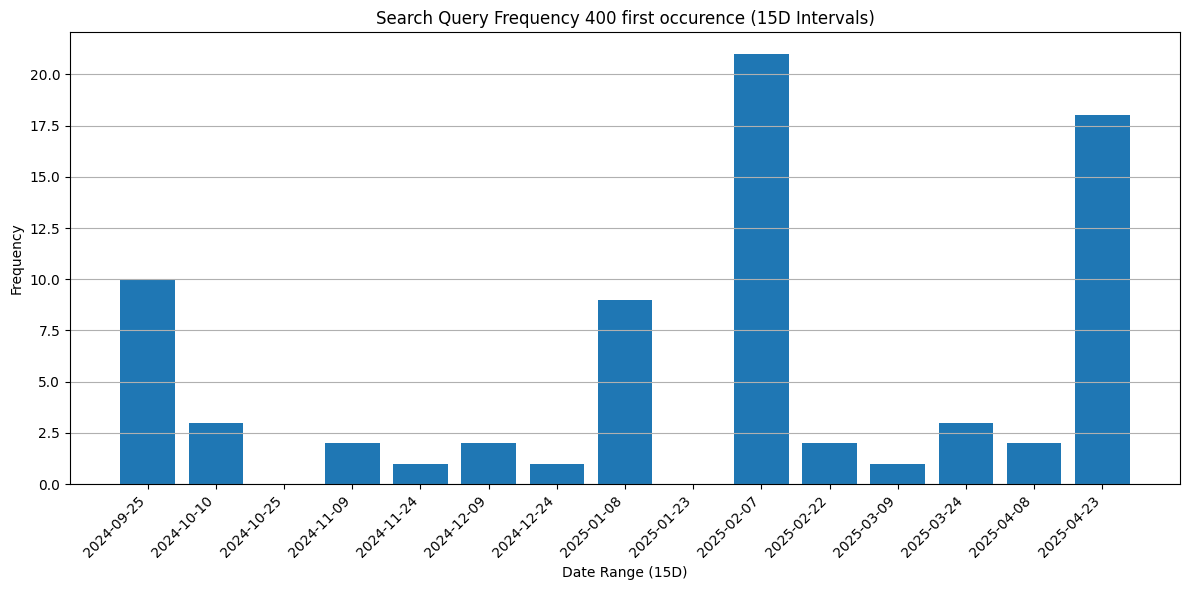

In [135]:
import pandas as pd
import matplotlib.pyplot as plt


def analyze_and_plot_search_query_frequency(df, range_threshold='15D'):
    # Convert 'min_date' to datetime objects
    df['min_date'] = pd.to_datetime(df['min_date'])

    # Group by the specified interval and count the occurrences
    grouped_counts = df.groupby(pd.Grouper(key='min_date', freq=range_threshold)).size().reset_index(name='frequency')

    # Extract the full date range for x-axis
    grouped_counts['date_range'] = grouped_counts['min_date'].dt.strftime('%Y-%m-%d')

    # Plot the grouped counts
    plt.figure(figsize=(12, 6))
    plt.bar(grouped_counts['date_range'], grouped_counts['frequency'])
    plt.xlabel(f'Date Range ({range_threshold})')
    plt.ylabel('Frequency')
    plt.title(f'Search Query Frequency 400 first occurence ({range_threshold} Intervals)')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

    # Example usage
analyze_and_plot_search_query_frequency(results_with_400_df, range_threshold='15D')


Date ranges: [('2025-05-01', '2025-05-06'), ('2025-04-01', '2025-04-30'), ('2025-03-02', '2025-03-31'), ('2025-01-31', '2025-03-01'), ('2025-01-01', '2025-01-30'), ('2024-12-02', '2024-12-31'), ('2024-11-02', '2024-12-01'), ('2024-10-03', '2024-11-01'), ('2024-09-03', '2024-10-02'), ('2024-08-04', '2024-09-02'), ('2024-07-05', '2024-08-03'), ('2024-06-05', '2024-07-04'), ('2024-05-06', '2024-06-04')]
Processing search term: sunglasses
Processing date range: 2025-05-01 to 2025-05-06

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-05-01') AND DATE('2025-05-06')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                

Python(55786) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-05-01', 'nbh': '1943'}, {'event_date': '2025-05-01', 'nbh': '8329'}, {'event_date': '2025-05-01', 'nbh': '8333'}, {'event_date': '2025-05-01', 'nbh': '43052'}, {'event_date': '2025-05-01', 'nbh': '43113'}, {'event_date': '2025-05-01', 'nbh': '43266'}, {'event_date': '2025-05-01', 'nbh': '48515'}, {'event_date': '2025-05-01', 'nbh': '48547'}, {'event_date': '2025-05-01', 'nbh': '48677'}, {'event_date': '2025-05-01', 'nbh': '48756'}, {'event_date': '2025-05-01', 'nbh': '48781'}, {'event_date': '2025-05-01', 'nbh': '48801'}, {'event_date': '2025-05-01', 'nbh': '50448'}, {'event_date': '2025-05-01', 'nbh': '50455'}, {'event_date': '2025-05-01', 'nbh': '50530'}, {'event_date': '2025-05-01', 'nbh': '50547'}, {'event_date': '2025-05-01', 'nbh': '50822'}, {'event_date': '2025-05-02', 'nbh': '1918'}, {'event_date': '2025-05-02', 'nbh': '1938'}, {'event_date': '2025-05-02', 'nbh': '1940'}, {'event_date': '2025-05-02', 'nbh': '8132'}, {'event_date': '2025-05-02', 'nbh': '460

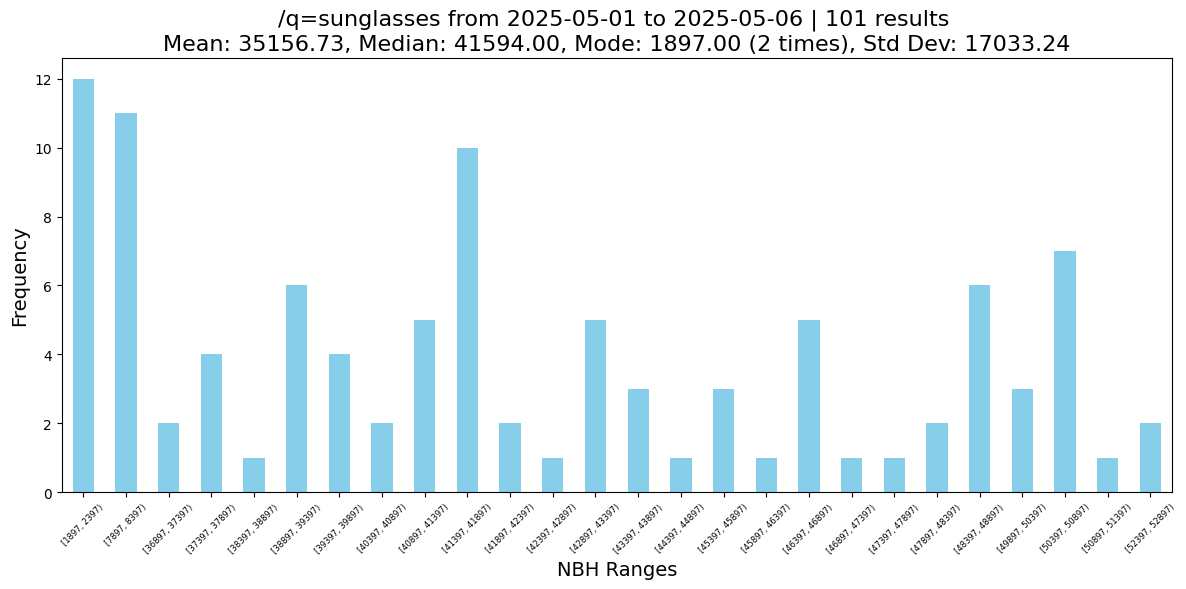

Processing date range: 2025-04-01 to 2025-04-30

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-04-01') AND DATE('2025-04-30')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'sunglasses'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=sunglasses%'
            ORDER BY
                event_date, nbh
       

Python(55879) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-04-01', 'nbh': '28282'}, {'event_date': '2025-04-01', 'nbh': '28294'}, {'event_date': '2025-04-01', 'nbh': '28305'}, {'event_date': '2025-04-01', 'nbh': '28330'}, {'event_date': '2025-04-01', 'nbh': '34390'}, {'event_date': '2025-04-02', 'nbh': '1904'}, {'event_date': '2025-04-02', 'nbh': '28910'}, {'event_date': '2025-04-02', 'nbh': '29184'}, {'event_date': '2025-04-02', 'nbh': '34979'}, {'event_date': '2025-04-02', 'nbh': '34980'}, {'event_date': '2025-04-02', 'nbh': '35051'}, {'event_date': '2025-04-02', 'nbh': '35055'}, {'event_date': '2025-04-02', 'nbh': '40474'}, {'event_date': '2025-04-03', 'nbh': '29781'}, {'event_date': '2025-04-03', 'nbh': '29856'}, {'event_date': '2025-04-03', 'nbh': '29925'}, {'event_date': '2025-04-03', 'nbh': '29939'}, {'event_date': '2025-04-03', 'nbh': '30037'}, {'event_date': '2025-04-03', 'nbh': '30104'}, {'event_date': '2025-04-03', 'nbh': '35427'}, {'event_date': '2025-04-03', 'nbh': '35497'}, {'event_date': '2025-04-03', 'nbh'

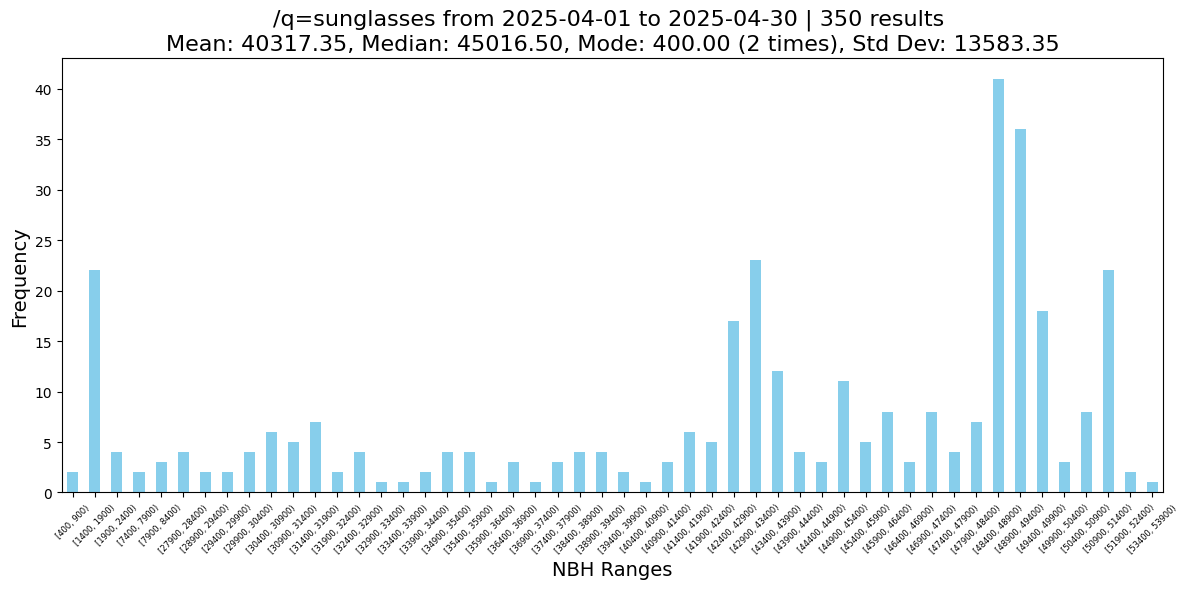

Processing date range: 2025-03-02 to 2025-03-31

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-03-02') AND DATE('2025-03-31')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'sunglasses'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=sunglasses%'
            ORDER BY
                event_date, nbh
       

Python(55972) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-03-02', 'nbh': '2087'}, {'event_date': '2025-03-02', 'nbh': '2122'}, {'event_date': '2025-03-02', 'nbh': '2123'}, {'event_date': '2025-03-02', 'nbh': '2128'}, {'event_date': '2025-03-02', 'nbh': '32837'}, {'event_date': '2025-03-02', 'nbh': '33414'}, {'event_date': '2025-03-02', 'nbh': '33701'}, {'event_date': '2025-03-02', 'nbh': '33820'}, {'event_date': '2025-03-02', 'nbh': '33864'}, {'event_date': '2025-03-02', 'nbh': '33888'}, {'event_date': '2025-03-02', 'nbh': '33918'}, {'event_date': '2025-03-02', 'nbh': '33927'}, {'event_date': '2025-03-02', 'nbh': '45171'}, {'event_date': '2025-03-02', 'nbh': '45378'}, {'event_date': '2025-03-02', 'nbh': '45396'}, {'event_date': '2025-03-02', 'nbh': '45430'}, {'event_date': '2025-03-02', 'nbh': '45442'}, {'event_date': '2025-03-02', 'nbh': '45679'}, {'event_date': '2025-03-02', 'nbh': '45855'}, {'event_date': '2025-03-02', 'nbh': '46068'}, {'event_date': '2025-03-03', 'nbh': '2086'}, {'event_date': '2025-03-03', 'nbh': '2

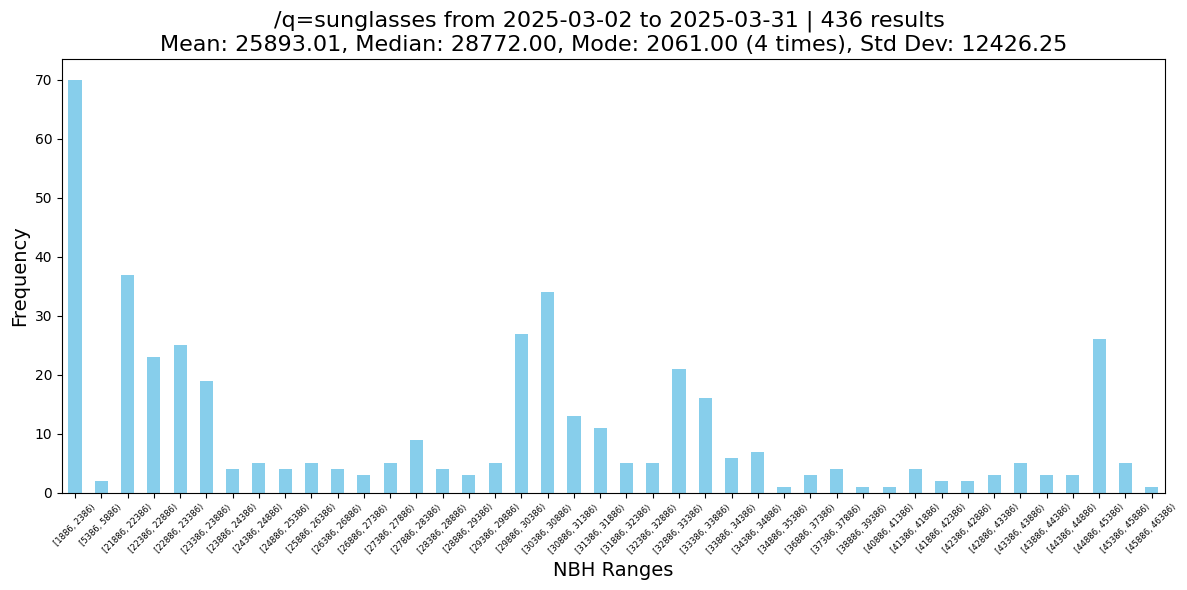

Processing date range: 2025-01-31 to 2025-03-01

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-01-31') AND DATE('2025-03-01')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'sunglasses'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=sunglasses%'
            ORDER BY
                event_date, nbh
       

Python(56056) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-01-31', 'nbh': '2043'}, {'event_date': '2025-01-31', 'nbh': '2043'}, {'event_date': '2025-01-31', 'nbh': '2044'}, {'event_date': '2025-01-31', 'nbh': '2073'}, {'event_date': '2025-01-31', 'nbh': '2078'}, {'event_date': '2025-01-31', 'nbh': '17315'}, {'event_date': '2025-01-31', 'nbh': '17484'}, {'event_date': '2025-01-31', 'nbh': '17487'}, {'event_date': '2025-01-31', 'nbh': '17501'}, {'event_date': '2025-01-31', 'nbh': '17508'}, {'event_date': '2025-01-31', 'nbh': '19403'}, {'event_date': '2025-01-31', 'nbh': '19489'}, {'event_date': '2025-01-31', 'nbh': '29137'}, {'event_date': '2025-01-31', 'nbh': '29238'}, {'event_date': '2025-01-31', 'nbh': '29493'}, {'event_date': '2025-01-31', 'nbh': '29496'}, {'event_date': '2025-01-31', 'nbh': '29498'}, {'event_date': '2025-01-31', 'nbh': '29498'}, {'event_date': '2025-01-31', 'nbh': '29499'}, {'event_date': '2025-01-31', 'nbh': '29565'}, {'event_date': '2025-02-01', 'nbh': '2024'}, {'event_date': '2025-02-01', 'nbh': '20

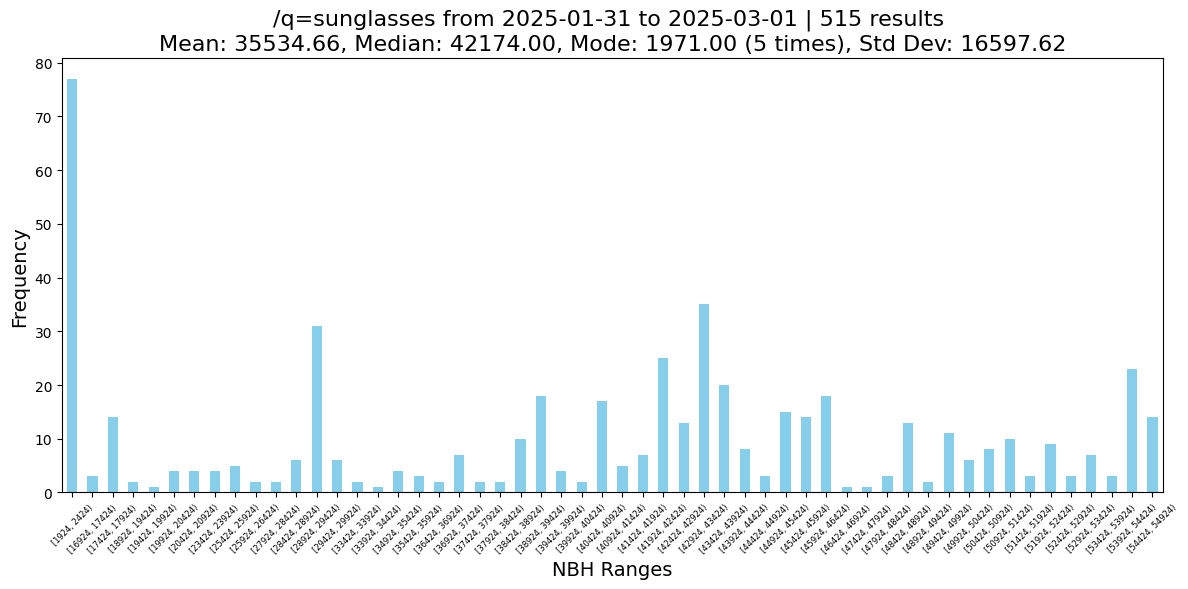

Processing date range: 2025-01-01 to 2025-01-30

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-01-01') AND DATE('2025-01-30')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'sunglasses'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=sunglasses%'
            ORDER BY
                event_date, nbh
       

Python(56181) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-01-01', 'nbh': '2191'}, {'event_date': '2025-01-01', 'nbh': '2225'}, {'event_date': '2025-01-01', 'nbh': '20408'}, {'event_date': '2025-01-01', 'nbh': '20417'}, {'event_date': '2025-01-01', 'nbh': '20491'}, {'event_date': '2025-01-01', 'nbh': '20499'}, {'event_date': '2025-01-01', 'nbh': '20990'}, {'event_date': '2025-01-01', 'nbh': '21057'}, {'event_date': '2025-01-01', 'nbh': '21067'}, {'event_date': '2025-01-01', 'nbh': '21086'}, {'event_date': '2025-01-01', 'nbh': '21212'}, {'event_date': '2025-01-01', 'nbh': '21392'}, {'event_date': '2025-01-01', 'nbh': '21406'}, {'event_date': '2025-01-01', 'nbh': '21880'}, {'event_date': '2025-01-01', 'nbh': '37195'}, {'event_date': '2025-01-01', 'nbh': '39335'}, {'event_date': '2025-01-02', 'nbh': '2132'}, {'event_date': '2025-01-02', 'nbh': '2139'}, {'event_date': '2025-01-02', 'nbh': '2170'}, {'event_date': '2025-01-02', 'nbh': '2188'}, {'event_date': '2025-01-02', 'nbh': '2233'}, {'event_date': '2025-01-02', 'nbh': '201

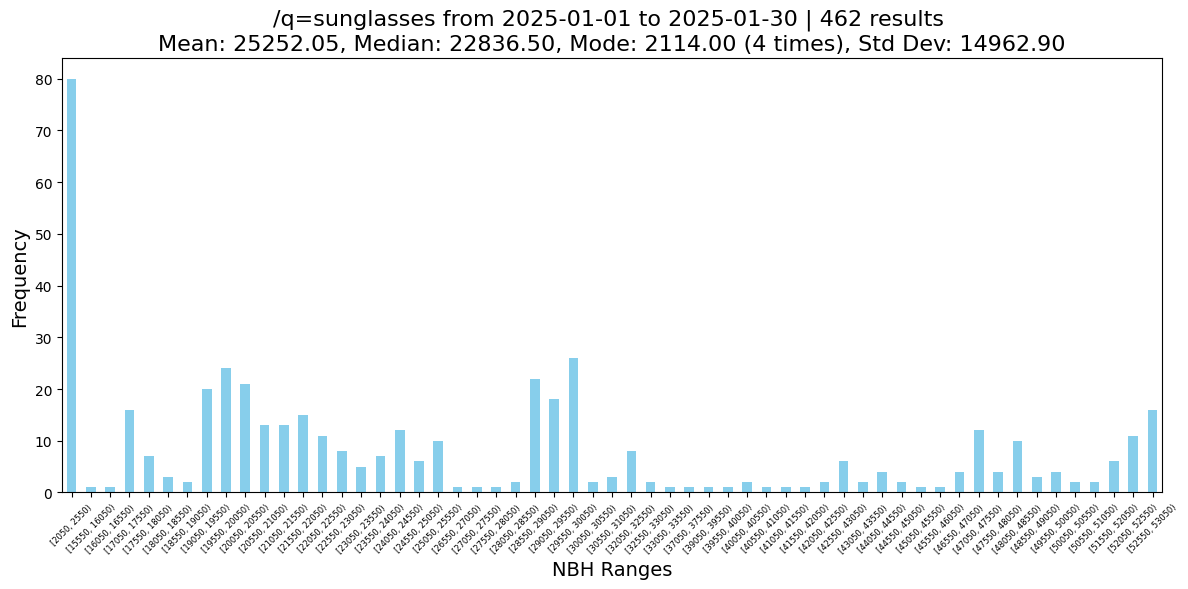

Processing date range: 2024-12-02 to 2024-12-31

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-12-02') AND DATE('2024-12-31')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'sunglasses'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=sunglasses%'
            ORDER BY
                event_date, nbh
       

Python(56284) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2024-12-02', 'nbh': '2237'}, {'event_date': '2024-12-02', 'nbh': '2237'}, {'event_date': '2024-12-02', 'nbh': '2238'}, {'event_date': '2024-12-02', 'nbh': '2269'}, {'event_date': '2024-12-02', 'nbh': '2270'}, {'event_date': '2024-12-02', 'nbh': '2270'}, {'event_date': '2024-12-02', 'nbh': '2270'}, {'event_date': '2024-12-02', 'nbh': '2270'}, {'event_date': '2024-12-02', 'nbh': '2270'}, {'event_date': '2024-12-02', 'nbh': '2270'}, {'event_date': '2024-12-02', 'nbh': '2270'}, {'event_date': '2024-12-02', 'nbh': '2271'}, {'event_date': '2024-12-02', 'nbh': '2278'}, {'event_date': '2024-12-02', 'nbh': '2279'}, {'event_date': '2024-12-02', 'nbh': '2279'}, {'event_date': '2024-12-02', 'nbh': '2279'}, {'event_date': '2024-12-02', 'nbh': '2280'}, {'event_date': '2024-12-02', 'nbh': '2280'}, {'event_date': '2024-12-02', 'nbh': '2282'}, {'event_date': '2024-12-02', 'nbh': '23582'}, {'event_date': '2024-12-02', 'nbh': '23628'}, {'event_date': '2024-12-02', 'nbh': '23641'}, {'even

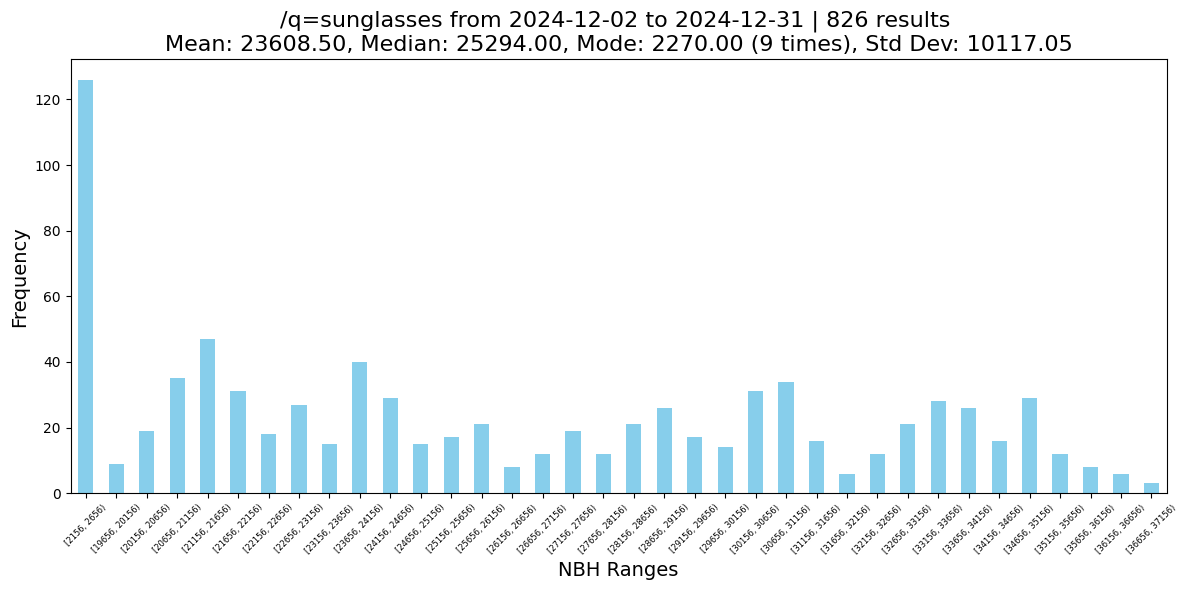

Processing date range: 2024-11-02 to 2024-12-01

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-11-02') AND DATE('2024-12-01')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'sunglasses'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=sunglasses%'
            ORDER BY
                event_date, nbh
       

Python(56384) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2024-11-02', 'nbh': '2754'}, {'event_date': '2024-11-02', 'nbh': '14795'}, {'event_date': '2024-11-02', 'nbh': '15063'}, {'event_date': '2024-11-02', 'nbh': '15103'}, {'event_date': '2024-11-02', 'nbh': '16478'}, {'event_date': '2024-11-02', 'nbh': '17004'}, {'event_date': '2024-11-02', 'nbh': '17254'}, {'event_date': '2024-11-02', 'nbh': '18066'}, {'event_date': '2024-11-02', 'nbh': '18208'}, {'event_date': '2024-11-02', 'nbh': '18805'}, {'event_date': '2024-11-02', 'nbh': '19156'}, {'event_date': '2024-11-02', 'nbh': '19520'}, {'event_date': '2024-11-02', 'nbh': '35682'}, {'event_date': '2024-11-02', 'nbh': '36077'}, {'event_date': '2024-11-02', 'nbh': '37090'}, {'event_date': '2024-11-02', 'nbh': '37859'}, {'event_date': '2024-11-03', 'nbh': '2735'}, {'event_date': '2024-11-03', 'nbh': '2739'}, {'event_date': '2024-11-03', 'nbh': '2739'}, {'event_date': '2024-11-03', 'nbh': '2800'}, {'event_date': '2024-11-03', 'nbh': '2877'}, {'event_date': '2024-11-03', 'nbh': '13

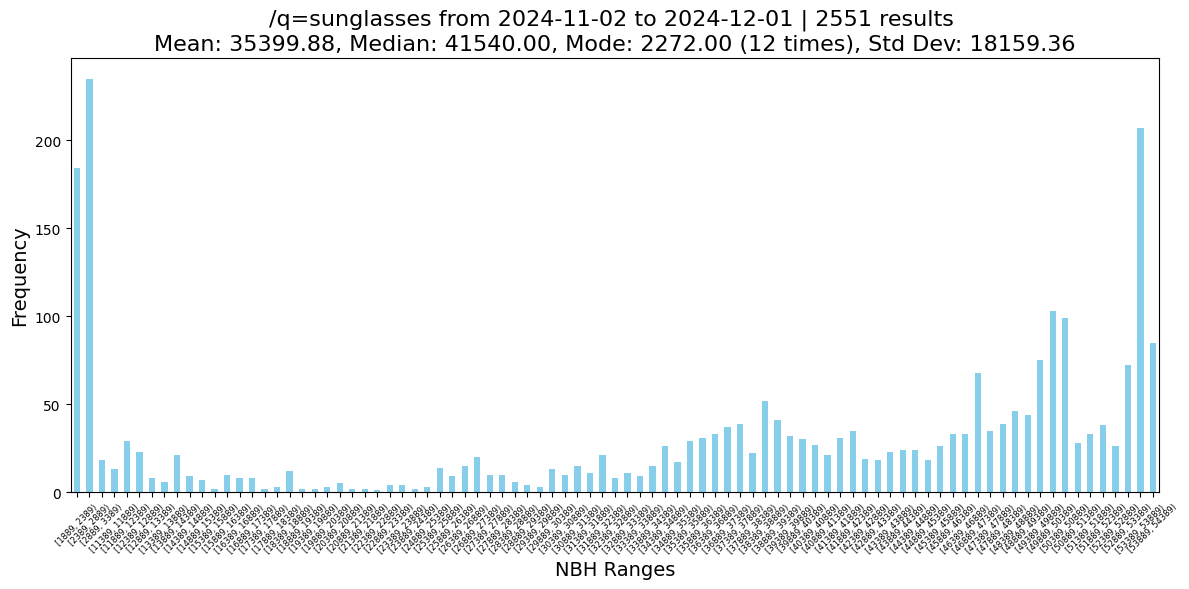

Processing date range: 2024-10-03 to 2024-11-01

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-10-03') AND DATE('2024-11-01')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'sunglasses'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=sunglasses%'
            ORDER BY
                event_date, nbh
       

Python(56488) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2024-10-03', 'nbh': '2285'}, {'event_date': '2024-10-03', 'nbh': '2285'}, {'event_date': '2024-10-03', 'nbh': '2285'}, {'event_date': '2024-10-03', 'nbh': '2290'}, {'event_date': '2024-10-03', 'nbh': '2291'}, {'event_date': '2024-10-03', 'nbh': '2292'}, {'event_date': '2024-10-03', 'nbh': '34024'}, {'event_date': '2024-10-03', 'nbh': '34085'}, {'event_date': '2024-10-03', 'nbh': '34085'}, {'event_date': '2024-10-03', 'nbh': '34090'}, {'event_date': '2024-10-03', 'nbh': '34094'}, {'event_date': '2024-10-03', 'nbh': '34099'}, {'event_date': '2024-10-03', 'nbh': '36413'}, {'event_date': '2024-10-03', 'nbh': '36413'}, {'event_date': '2024-10-03', 'nbh': '36423'}, {'event_date': '2024-10-03', 'nbh': '36424'}, {'event_date': '2024-10-03', 'nbh': '36477'}, {'event_date': '2024-10-03', 'nbh': '36497'}, {'event_date': '2024-10-03', 'nbh': '36497'}, {'event_date': '2024-10-03', 'nbh': '36498'}, {'event_date': '2024-10-03', 'nbh': '36505'}, {'event_date': '2024-10-03', 'nbh': '36

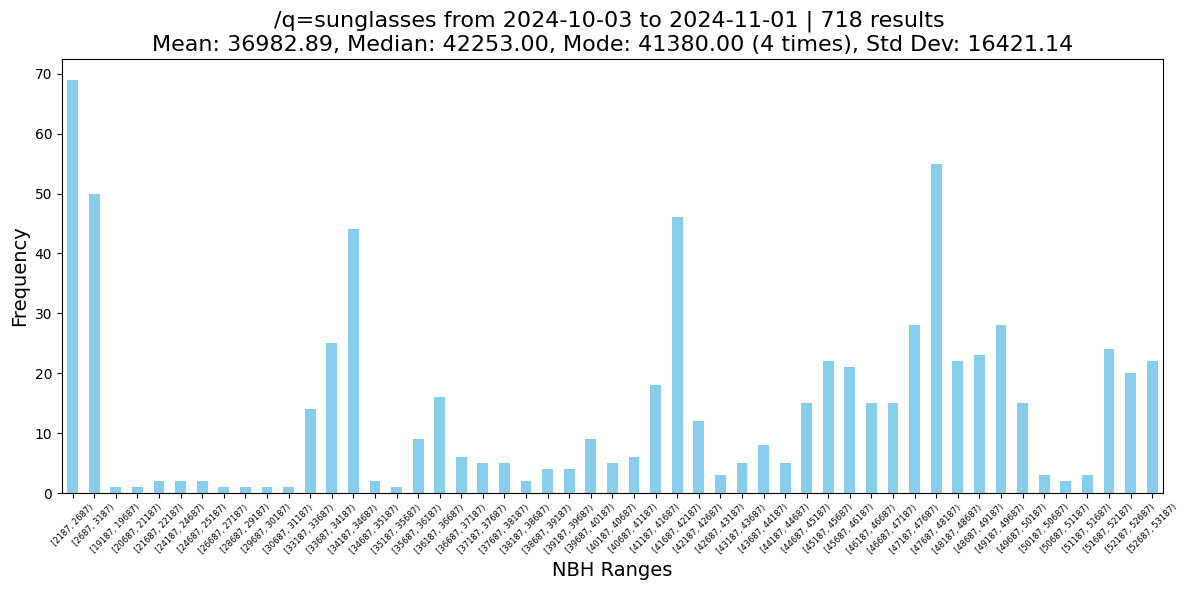

Processing date range: 2024-09-03 to 2024-10-02

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-09-03') AND DATE('2024-10-02')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'sunglasses'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=sunglasses%'
            ORDER BY
                event_date, nbh
       

Python(56576) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2024-09-25', 'nbh': '2208'}, {'event_date': '2024-09-25', 'nbh': '2212'}, {'event_date': '2024-09-25', 'nbh': '2222'}, {'event_date': '2024-09-25', 'nbh': '35018'}, {'event_date': '2024-09-25', 'nbh': '35065'}, {'event_date': '2024-09-25', 'nbh': '43031'}, {'event_date': '2024-09-25', 'nbh': '43065'}, {'event_date': '2024-09-25', 'nbh': '43118'}, {'event_date': '2024-09-25', 'nbh': '43303'}, {'event_date': '2024-09-25', 'nbh': '43368'}, {'event_date': '2024-09-26', 'nbh': '2199'}, {'event_date': '2024-09-26', 'nbh': '2204'}, {'event_date': '2024-09-26', 'nbh': '2222'}, {'event_date': '2024-09-26', 'nbh': '2223'}, {'event_date': '2024-09-26', 'nbh': '35057'}, {'event_date': '2024-09-26', 'nbh': '35161'}, {'event_date': '2024-09-26', 'nbh': '35195'}, {'event_date': '2024-09-26', 'nbh': '35204'}, {'event_date': '2024-09-26', 'nbh': '35204'}, {'event_date': '2024-09-26', 'nbh': '35209'}, {'event_date': '2024-09-26', 'nbh': '35216'}, {'event_date': '2024-09-26', 'nbh': '352

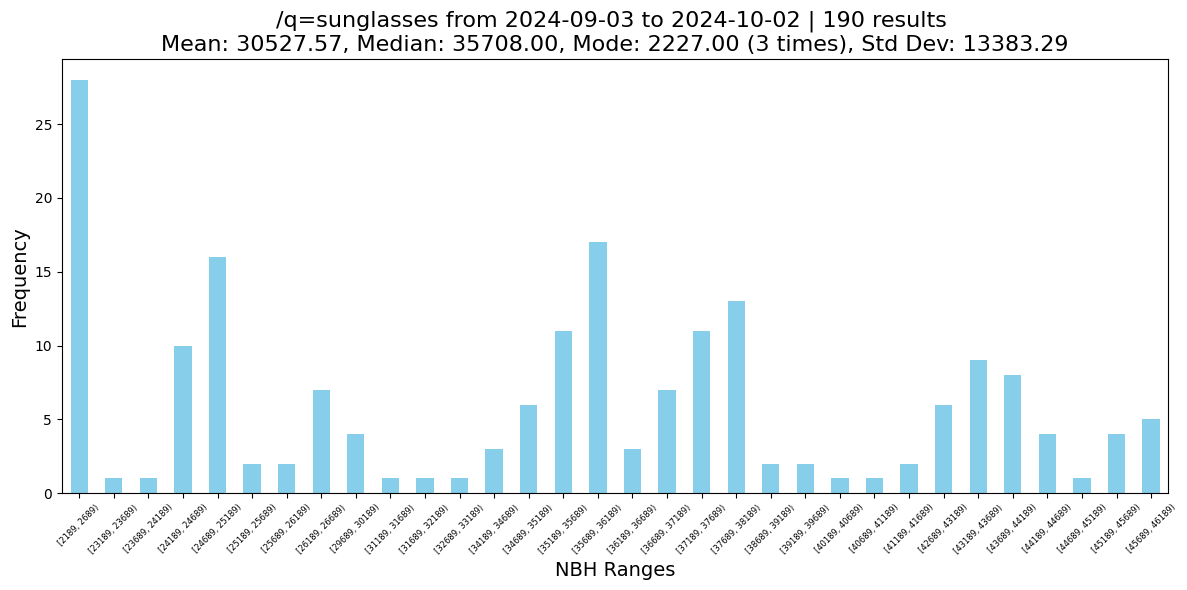

Processing date range: 2024-08-04 to 2024-09-02

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-08-04') AND DATE('2024-09-02')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'sunglasses'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=sunglasses%'
            ORDER BY
                event_date, nbh
       

Python(56658) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[]
Result saved to ./statistics_results/sunglasses/sunglasses_2024-08-04_2024-09-02.csv
No data found for search term: sunglasses in range 2024-08-04 to 2024-09-02
Processing date range: 2024-07-05 to 2024-08-03

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-07-05') AND DATE('2024-08-03')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'sunglasses'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st")

Python(56741) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[]
Result saved to ./statistics_results/sunglasses/sunglasses_2024-07-05_2024-08-03.csv
No data found for search term: sunglasses in range 2024-07-05 to 2024-08-03
Processing date range: 2024-06-05 to 2024-07-04

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-06-05') AND DATE('2024-07-04')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'sunglasses'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st")

Python(56828) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[]
Result saved to ./statistics_results/sunglasses/sunglasses_2024-06-05_2024-07-04.csv
No data found for search term: sunglasses in range 2024-06-05 to 2024-07-04
Processing date range: 2024-05-06 to 2024-06-04

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-05-06') AND DATE('2024-06-04')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'sunglasses'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st")

Python(56911) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[]
Result saved to ./statistics_results/sunglasses/sunglasses_2024-05-06_2024-06-04.csv
No data found for search term: sunglasses in range 2024-05-06 to 2024-06-04
Stats: [{'start_date': '2025-05-01', 'end_date': '2025-05-06', 'mean': np.float64(35156.732673267325), 'median': np.float64(41594.0), 'mode': np.float64(1897.0), 'std_dev': np.float64(17033.243467344142)}, {'start_date': '2025-04-01', 'end_date': '2025-04-30', 'mean': np.float64(40317.34857142857), 'median': np.float64(45016.5), 'mode': np.float64(400.0), 'std_dev': np.float64(13583.350838800969)}, {'start_date': '2025-03-02', 'end_date': '2025-03-31', 'mean': np.float64(25893.011467889908), 'median': np.float64(28772.0), 'mode': np.float64(2061.0), 'std_dev': np.float64(12426.251727595469)}, {'start_date': '2025-01-31', 'end_date': '2025-03-01', 'mean': np.float64(35534.66213592233), 'median': np.float64(42174.0), 'mode': np.float64(1971.0), 'std_dev': np.float64(16597.62177582235)}, {'start_date': '2025-01-01', 'end_date':

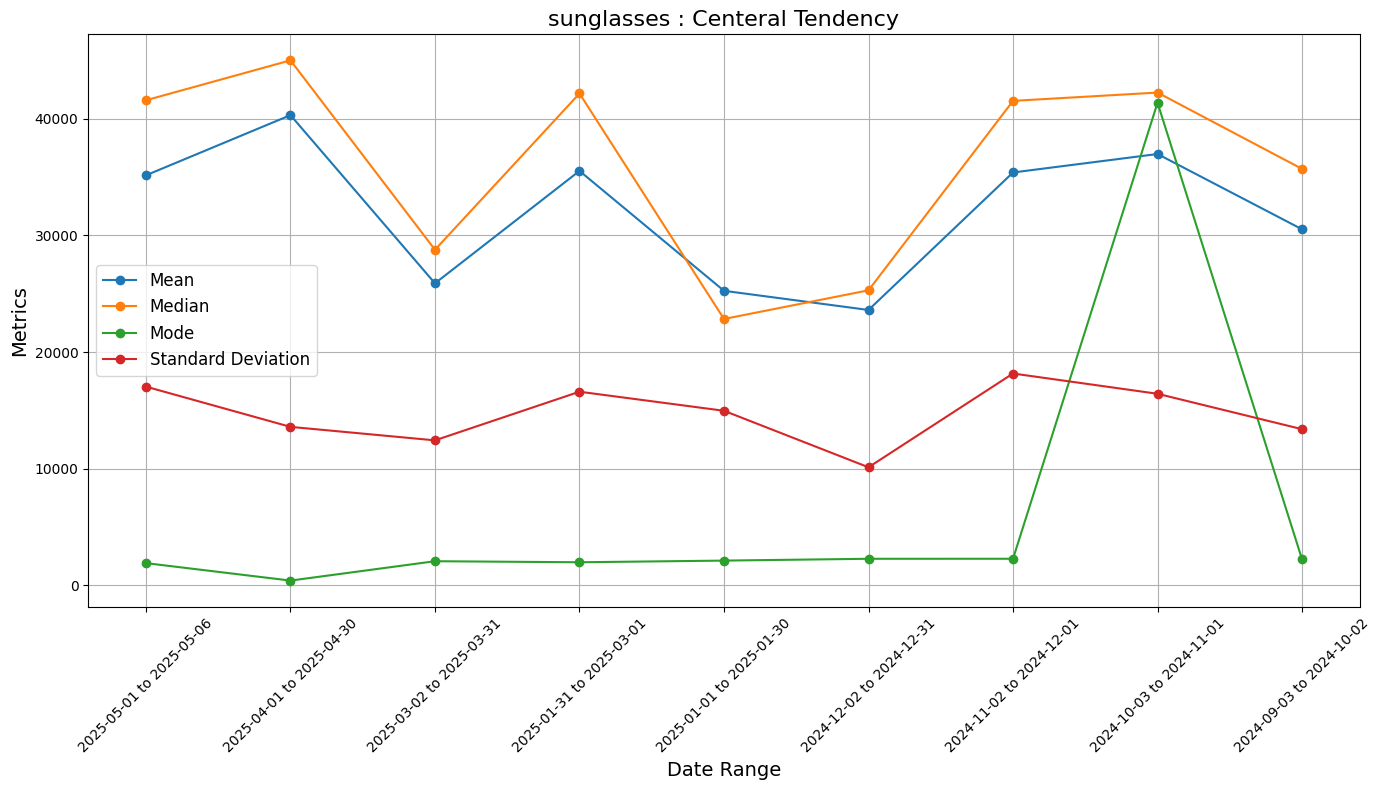

Stats saved to ./statistics_results/sunglasses/centeral_tendency.csv
Percentiles:   search_term  start_date    end_date  5th_percentile  10th_percentile  \
0  sunglasses  2025-05-01  2025-05-06         1922.00           1940.0   
1  sunglasses  2025-04-01  2025-04-30         1882.00          28303.9   
2  sunglasses  2025-03-02  2025-03-31         2003.75           2092.0   
3  sunglasses  2025-01-31  2025-03-01         1971.00           2008.4   
4  sunglasses  2025-01-01  2025-01-30         2090.10           2114.1   
5  sunglasses  2024-12-02  2024-12-31         2218.00           2270.0   
6  sunglasses  2024-11-02  2024-12-01         2317.00           2426.0   
7  sunglasses  2024-10-03  2024-11-01         2505.25           2714.6   
8  sunglasses  2024-09-03  2024-10-02         2222.00           2231.9   

   15th_percentile  50th_percentile  75th_percentile  90th_percentile  \
0          7940.00          41594.0         46604.00          50335.0   
1         31084.00          450

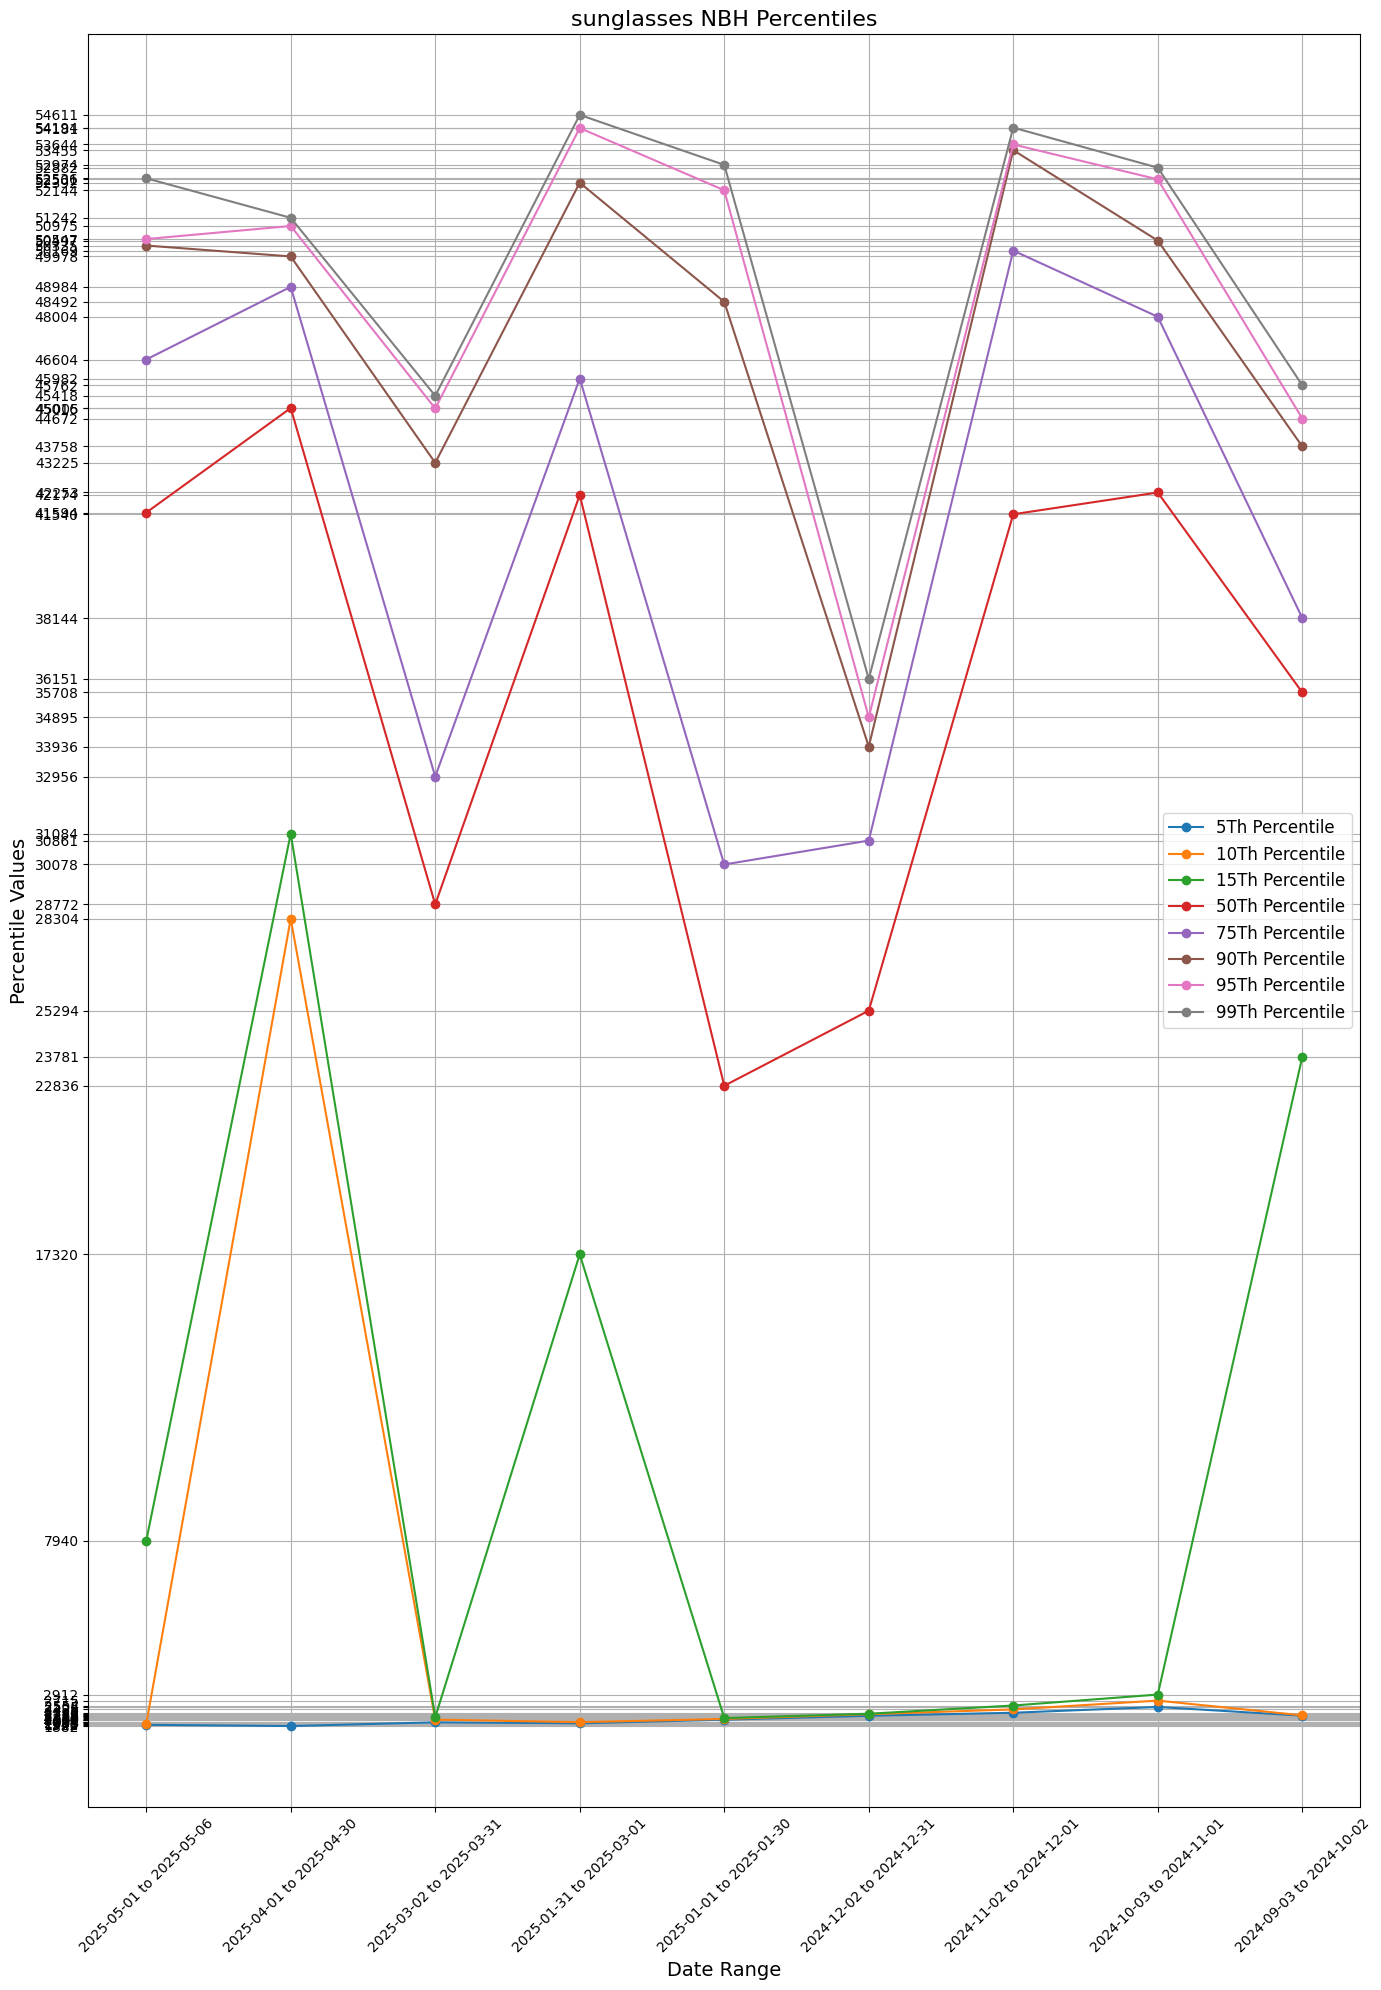

Stats saved to ./statistics_results/sunglasses/percentiles.csv
Processing search term: shirts
Processing date range: 2025-05-01 to 2025-05-06

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-05-01') AND DATE('2025-05-06')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'shirts'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl")

Python(56998) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-05-01', 'nbh': '400'}, {'event_date': '2025-05-01', 'nbh': '400'}, {'event_date': '2025-05-01', 'nbh': '17822'}, {'event_date': '2025-05-01', 'nbh': '32913'}, {'event_date': '2025-05-01', 'nbh': '35438'}, {'event_date': '2025-05-01', 'nbh': '35489'}, {'event_date': '2025-05-01', 'nbh': '35533'}, {'event_date': '2025-05-01', 'nbh': '35577'}, {'event_date': '2025-05-01', 'nbh': '35646'}, {'event_date': '2025-05-01', 'nbh': '44527'}, {'event_date': '2025-05-02', 'nbh': '400'}, {'event_date': '2025-05-02', 'nbh': '400'}, {'event_date': '2025-05-02', 'nbh': '15023'}, {'event_date': '2025-05-02', 'nbh': '15064'}, {'event_date': '2025-05-02', 'nbh': '17763'}, {'event_date': '2025-05-02', 'nbh': '17863'}, {'event_date': '2025-05-02', 'nbh': '33626'}, {'event_date': '2025-05-02', 'nbh': '35393'}, {'event_date': '2025-05-02', 'nbh': '35419'}, {'event_date': '2025-05-02', 'nbh': '35438'}, {'event_date': '2025-05-02', 'nbh': '35473'}, {'event_date': '2025-05-02', 'nbh': '3560

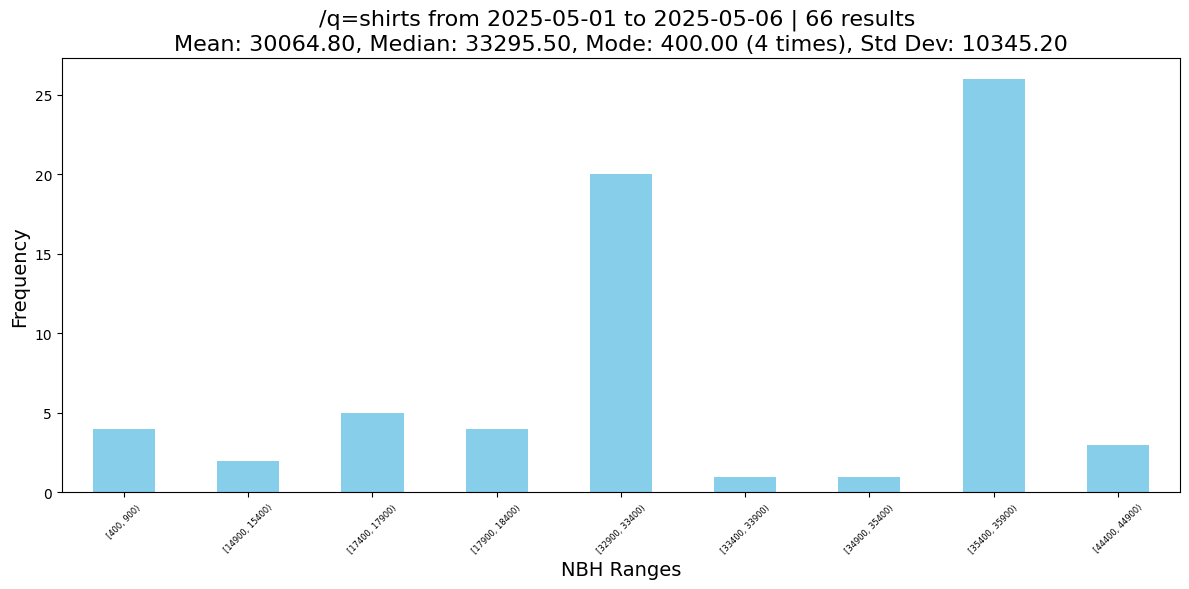

Processing date range: 2025-04-01 to 2025-04-30

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-04-01') AND DATE('2025-04-30')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'shirts'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=shirts%'
            ORDER BY
                event_date, nbh
        


Python(57086) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-04-01', 'nbh': '31407'}, {'event_date': '2025-04-01', 'nbh': '31428'}, {'event_date': '2025-04-01', 'nbh': '31438'}, {'event_date': '2025-04-01', 'nbh': '31440'}, {'event_date': '2025-04-01', 'nbh': '31452'}, {'event_date': '2025-04-01', 'nbh': '34964'}, {'event_date': '2025-04-02', 'nbh': '400'}, {'event_date': '2025-04-02', 'nbh': '31474'}, {'event_date': '2025-04-02', 'nbh': '31476'}, {'event_date': '2025-04-02', 'nbh': '31489'}, {'event_date': '2025-04-02', 'nbh': '31512'}, {'event_date': '2025-04-02', 'nbh': '31514'}, {'event_date': '2025-04-03', 'nbh': '18012'}, {'event_date': '2025-04-03', 'nbh': '31138'}, {'event_date': '2025-04-03', 'nbh': '31536'}, {'event_date': '2025-04-03', 'nbh': '31603'}, {'event_date': '2025-04-03', 'nbh': '43255'}, {'event_date': '2025-04-03', 'nbh': '43257'}, {'event_date': '2025-04-04', 'nbh': '400'}, {'event_date': '2025-04-04', 'nbh': '400'}, {'event_date': '2025-04-04', 'nbh': '18196'}, {'event_date': '2025-04-04', 'nbh': '31

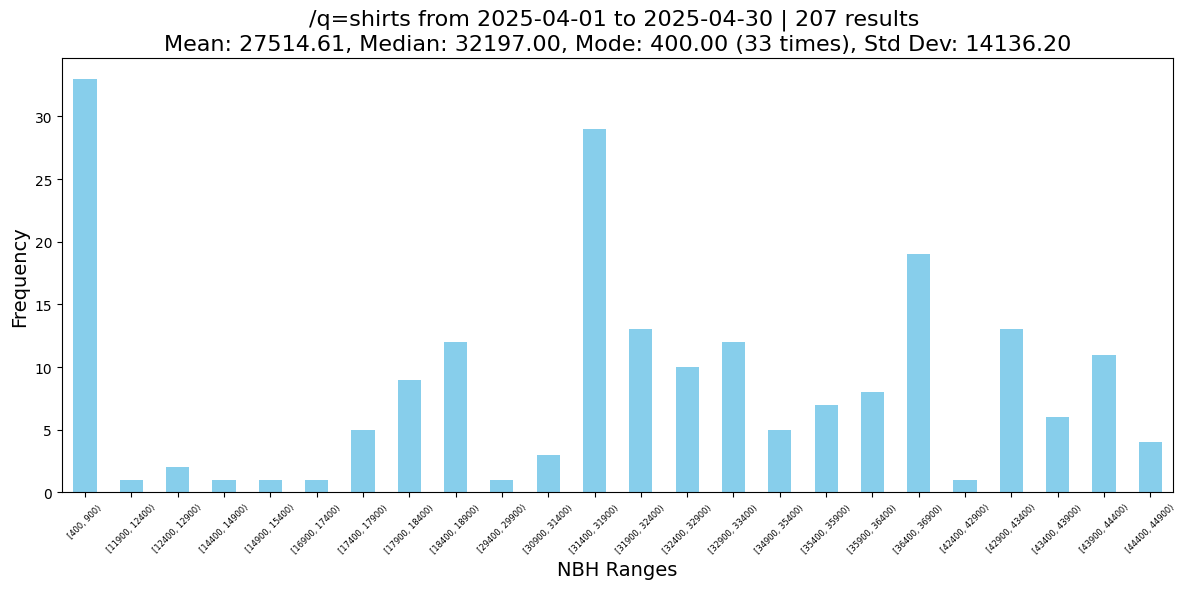

Processing date range: 2025-03-02 to 2025-03-31

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-03-02') AND DATE('2025-03-31')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'shirts'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=shirts%'
            ORDER BY
                event_date, nbh
        


Python(57168) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-03-02', 'nbh': '18171'}, {'event_date': '2025-03-02', 'nbh': '34246'}, {'event_date': '2025-03-02', 'nbh': '34287'}, {'event_date': '2025-03-02', 'nbh': '34288'}, {'event_date': '2025-03-02', 'nbh': '34293'}, {'event_date': '2025-03-02', 'nbh': '36970'}, {'event_date': '2025-03-02', 'nbh': '37462'}, {'event_date': '2025-03-02', 'nbh': '37463'}, {'event_date': '2025-03-02', 'nbh': '37481'}, {'event_date': '2025-03-02', 'nbh': '37489'}, {'event_date': '2025-03-03', 'nbh': '33656'}, {'event_date': '2025-03-03', 'nbh': '34304'}, {'event_date': '2025-03-03', 'nbh': '34389'}, {'event_date': '2025-03-03', 'nbh': '34391'}, {'event_date': '2025-03-03', 'nbh': '34404'}, {'event_date': '2025-03-03', 'nbh': '36678'}, {'event_date': '2025-03-03', 'nbh': '37179'}, {'event_date': '2025-03-03', 'nbh': '37454'}, {'event_date': '2025-03-03', 'nbh': '37501'}, {'event_date': '2025-03-03', 'nbh': '37503'}, {'event_date': '2025-03-04', 'nbh': '18376'}, {'event_date': '2025-03-04', 'nbh

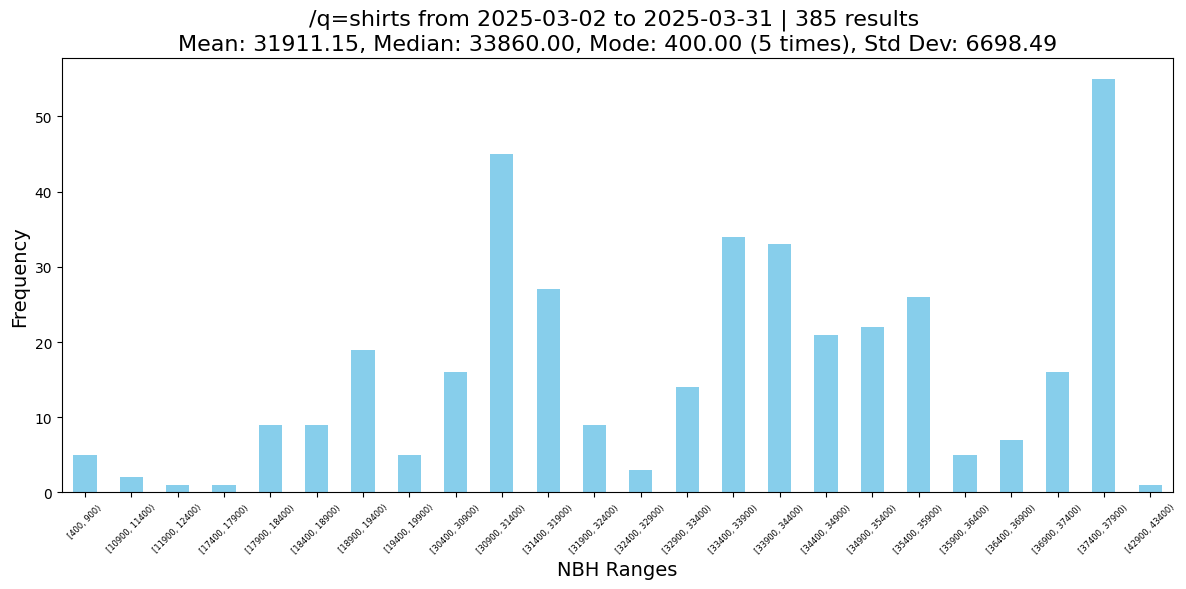

Processing date range: 2025-01-31 to 2025-03-01

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-01-31') AND DATE('2025-03-01')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'shirts'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=shirts%'
            ORDER BY
                event_date, nbh
        


Python(57257) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-01-31', 'nbh': '17301'}, {'event_date': '2025-01-31', 'nbh': '26699'}, {'event_date': '2025-01-31', 'nbh': '26723'}, {'event_date': '2025-01-31', 'nbh': '26784'}, {'event_date': '2025-01-31', 'nbh': '26799'}, {'event_date': '2025-01-31', 'nbh': '26927'}, {'event_date': '2025-01-31', 'nbh': '32457'}, {'event_date': '2025-01-31', 'nbh': '32463'}, {'event_date': '2025-01-31', 'nbh': '32471'}, {'event_date': '2025-01-31', 'nbh': '32497'}, {'event_date': '2025-01-31', 'nbh': '32501'}, {'event_date': '2025-02-01', 'nbh': '17282'}, {'event_date': '2025-02-01', 'nbh': '26635'}, {'event_date': '2025-02-01', 'nbh': '26952'}, {'event_date': '2025-02-01', 'nbh': '26999'}, {'event_date': '2025-02-01', 'nbh': '27034'}, {'event_date': '2025-02-01', 'nbh': '27042'}, {'event_date': '2025-02-01', 'nbh': '27051'}, {'event_date': '2025-02-01', 'nbh': '27053'}, {'event_date': '2025-02-01', 'nbh': '27090'}, {'event_date': '2025-02-01', 'nbh': '27470'}, {'event_date': '2025-02-01', 'nbh

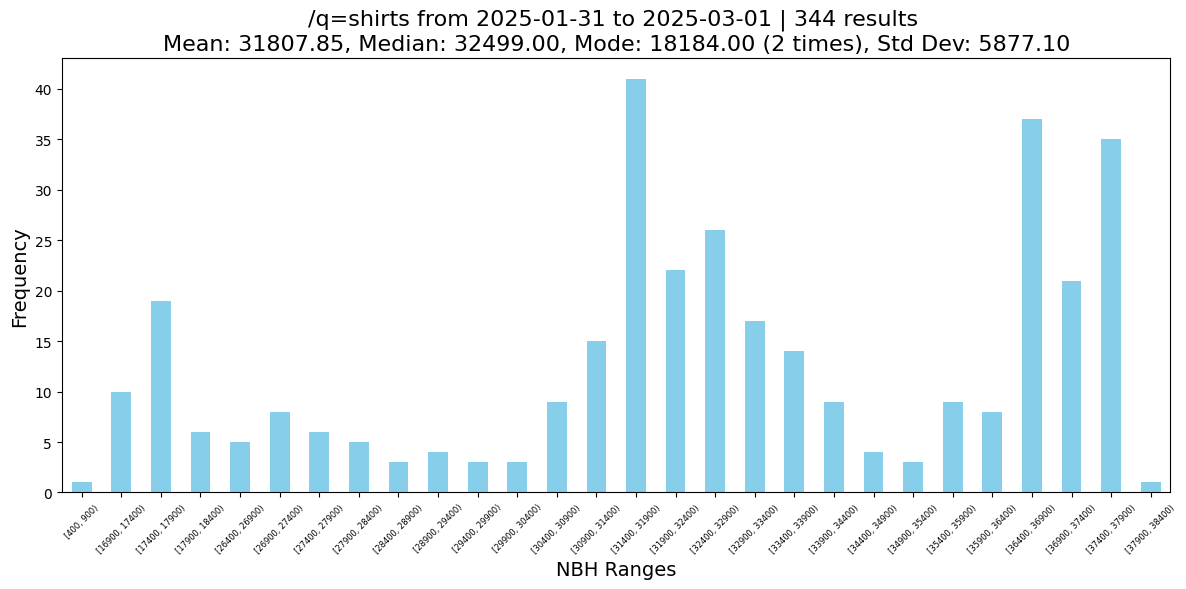

Processing date range: 2025-01-01 to 2025-01-30

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-01-01') AND DATE('2025-01-30')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'shirts'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=shirts%'
            ORDER BY
                event_date, nbh
        


Python(57358) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-01-01', 'nbh': '29106'}, {'event_date': '2025-01-01', 'nbh': '29915'}, {'event_date': '2025-01-01', 'nbh': '29961'}, {'event_date': '2025-01-01', 'nbh': '29962'}, {'event_date': '2025-01-01', 'nbh': '29998'}, {'event_date': '2025-01-01', 'nbh': '30010'}, {'event_date': '2025-01-01', 'nbh': '35952'}, {'event_date': '2025-01-01', 'nbh': '36010'}, {'event_date': '2025-01-01', 'nbh': '36015'}, {'event_date': '2025-01-01', 'nbh': '36029'}, {'event_date': '2025-01-02', 'nbh': '29351'}, {'event_date': '2025-01-02', 'nbh': '29870'}, {'event_date': '2025-01-02', 'nbh': '29872'}, {'event_date': '2025-01-02', 'nbh': '29874'}, {'event_date': '2025-01-02', 'nbh': '29882'}, {'event_date': '2025-01-02', 'nbh': '29891'}, {'event_date': '2025-01-02', 'nbh': '29915'}, {'event_date': '2025-01-02', 'nbh': '35957'}, {'event_date': '2025-01-02', 'nbh': '35970'}, {'event_date': '2025-01-02', 'nbh': '35970'}, {'event_date': '2025-01-03', 'nbh': '29247'}, {'event_date': '2025-01-03', 'nbh

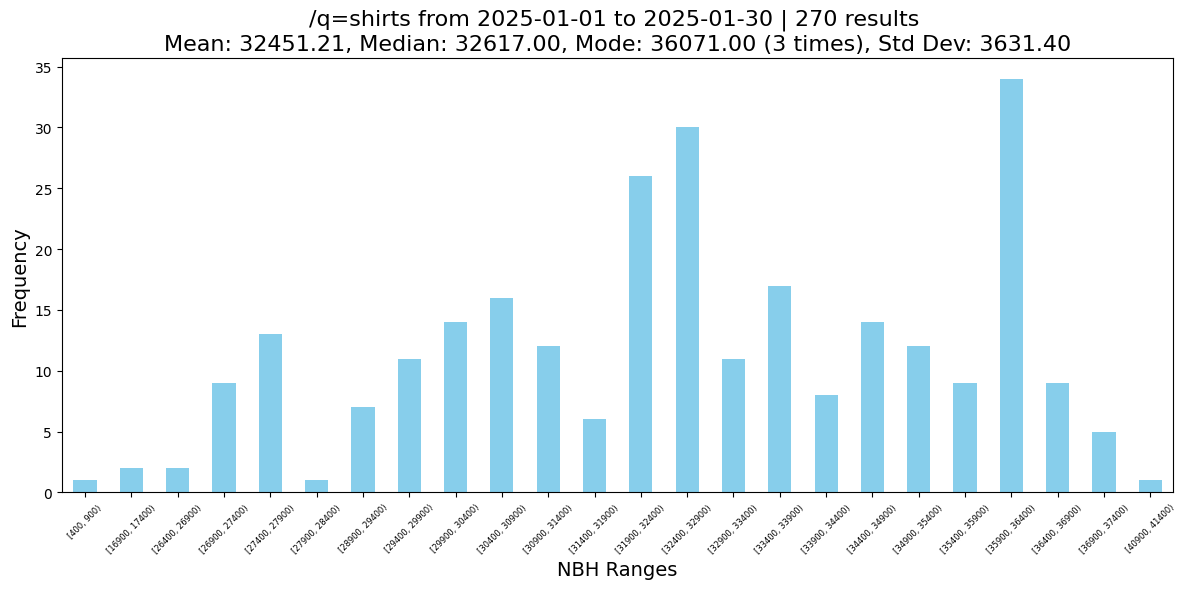

Processing date range: 2024-12-02 to 2024-12-31

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-12-02') AND DATE('2024-12-31')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'shirts'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=shirts%'
            ORDER BY
                event_date, nbh
        


Python(57446) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2024-12-02', 'nbh': '17571'}, {'event_date': '2024-12-02', 'nbh': '17599'}, {'event_date': '2024-12-02', 'nbh': '17601'}, {'event_date': '2024-12-02', 'nbh': '34026'}, {'event_date': '2024-12-02', 'nbh': '34944'}, {'event_date': '2024-12-02', 'nbh': '34966'}, {'event_date': '2024-12-02', 'nbh': '34983'}, {'event_date': '2024-12-02', 'nbh': '34998'}, {'event_date': '2024-12-02', 'nbh': '35016'}, {'event_date': '2024-12-02', 'nbh': '35021'}, {'event_date': '2024-12-02', 'nbh': '35053'}, {'event_date': '2024-12-02', 'nbh': '35070'}, {'event_date': '2024-12-02', 'nbh': '35091'}, {'event_date': '2024-12-02', 'nbh': '35173'}, {'event_date': '2024-12-02', 'nbh': '35224'}, {'event_date': '2024-12-02', 'nbh': '35233'}, {'event_date': '2024-12-02', 'nbh': '35240'}, {'event_date': '2024-12-02', 'nbh': '35241'}, {'event_date': '2024-12-02', 'nbh': '35247'}, {'event_date': '2024-12-02', 'nbh': '35289'}, {'event_date': '2024-12-02', 'nbh': '37676'}, {'event_date': '2024-12-02', 'nbh

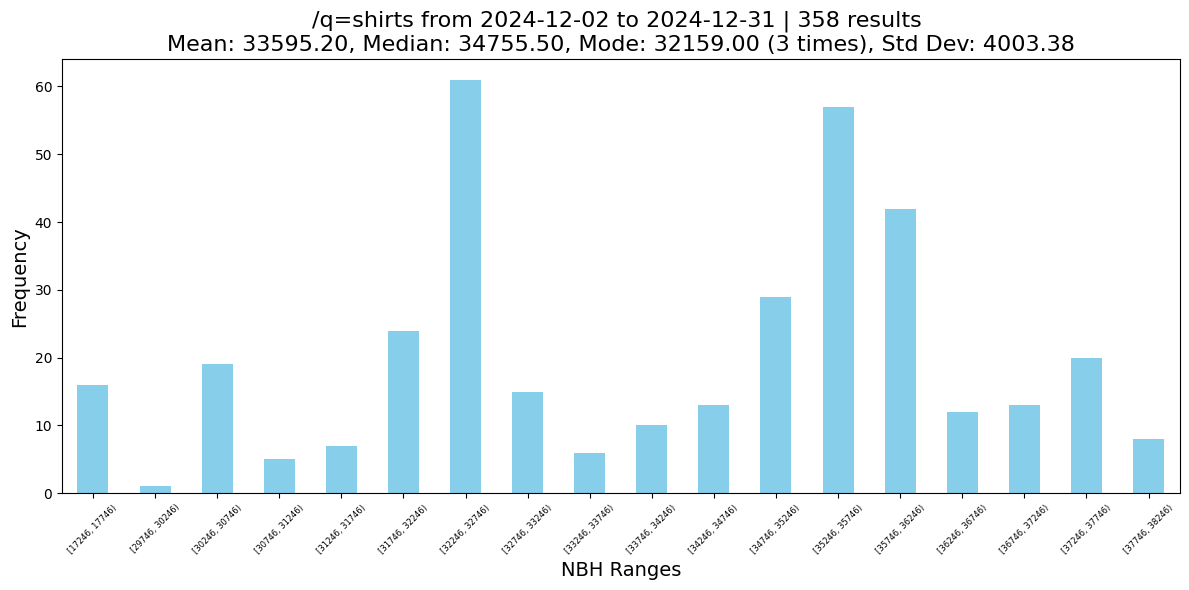

Processing date range: 2024-11-02 to 2024-12-01

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-11-02') AND DATE('2024-12-01')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'shirts'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=shirts%'
            ORDER BY
                event_date, nbh
        


Python(57530) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2024-11-02', 'nbh': '8820'}, {'event_date': '2024-11-02', 'nbh': '8833'}, {'event_date': '2024-11-02', 'nbh': '27710'}, {'event_date': '2024-11-02', 'nbh': '28813'}, {'event_date': '2024-11-02', 'nbh': '28842'}, {'event_date': '2024-11-02', 'nbh': '28847'}, {'event_date': '2024-11-02', 'nbh': '28848'}, {'event_date': '2024-11-02', 'nbh': '28857'}, {'event_date': '2024-11-02', 'nbh': '28865'}, {'event_date': '2024-11-02', 'nbh': '28891'}, {'event_date': '2024-11-02', 'nbh': '28949'}, {'event_date': '2024-11-02', 'nbh': '29771'}, {'event_date': '2024-11-02', 'nbh': '31413'}, {'event_date': '2024-11-02', 'nbh': '31623'}, {'event_date': '2024-11-02', 'nbh': '31674'}, {'event_date': '2024-11-02', 'nbh': '31737'}, {'event_date': '2024-11-02', 'nbh': '31913'}, {'event_date': '2024-11-02', 'nbh': '31929'}, {'event_date': '2024-11-03', 'nbh': '8969'}, {'event_date': '2024-11-03', 'nbh': '28477'}, {'event_date': '2024-11-03', 'nbh': '28611'}, {'event_date': '2024-11-03', 'nbh': 

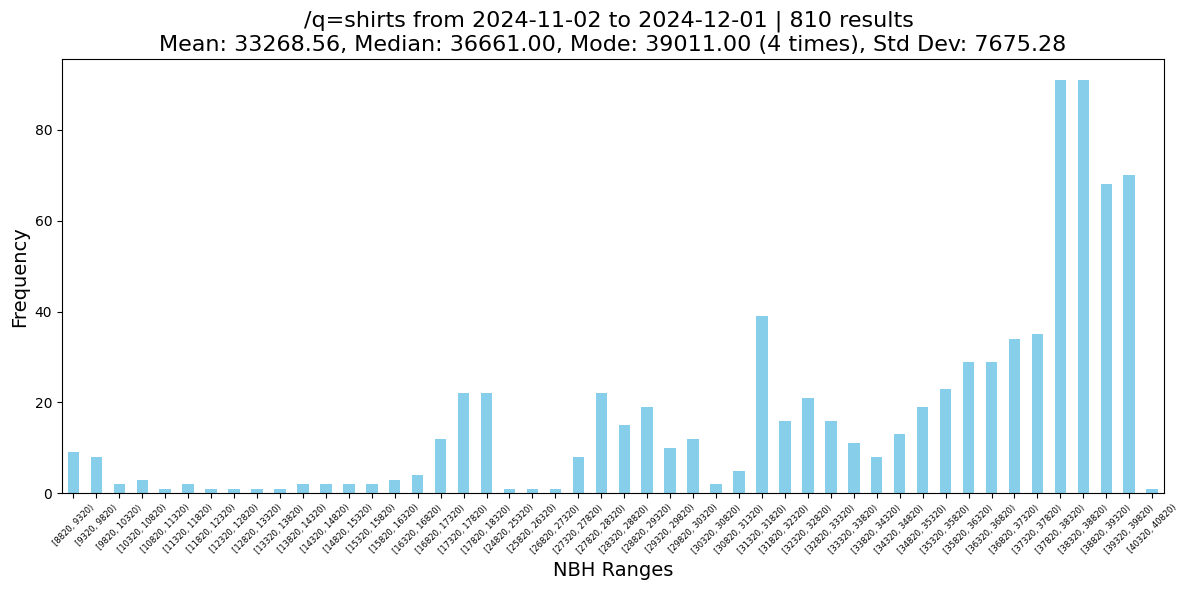

Processing date range: 2024-10-03 to 2024-11-01

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-10-03') AND DATE('2024-11-01')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'shirts'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=shirts%'
            ORDER BY
                event_date, nbh
        


Python(57627) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2024-10-03', 'nbh': '7561'}, {'event_date': '2024-10-03', 'nbh': '7571'}, {'event_date': '2024-10-03', 'nbh': '27501'}, {'event_date': '2024-10-03', 'nbh': '27507'}, {'event_date': '2024-10-03', 'nbh': '27508'}, {'event_date': '2024-10-03', 'nbh': '27546'}, {'event_date': '2024-10-03', 'nbh': '27555'}, {'event_date': '2024-10-03', 'nbh': '33643'}, {'event_date': '2024-10-03', 'nbh': '33726'}, {'event_date': '2024-10-03', 'nbh': '33739'}, {'event_date': '2024-10-03', 'nbh': '33749'}, {'event_date': '2024-10-04', 'nbh': '7562'}, {'event_date': '2024-10-04', 'nbh': '7572'}, {'event_date': '2024-10-04', 'nbh': '7597'}, {'event_date': '2024-10-04', 'nbh': '27372'}, {'event_date': '2024-10-04', 'nbh': '27428'}, {'event_date': '2024-10-04', 'nbh': '27486'}, {'event_date': '2024-10-04', 'nbh': '27495'}, {'event_date': '2024-10-04', 'nbh': '27546'}, {'event_date': '2024-10-04', 'nbh': '27568'}, {'event_date': '2024-10-04', 'nbh': '33568'}, {'event_date': '2024-10-04', 'nbh': '3

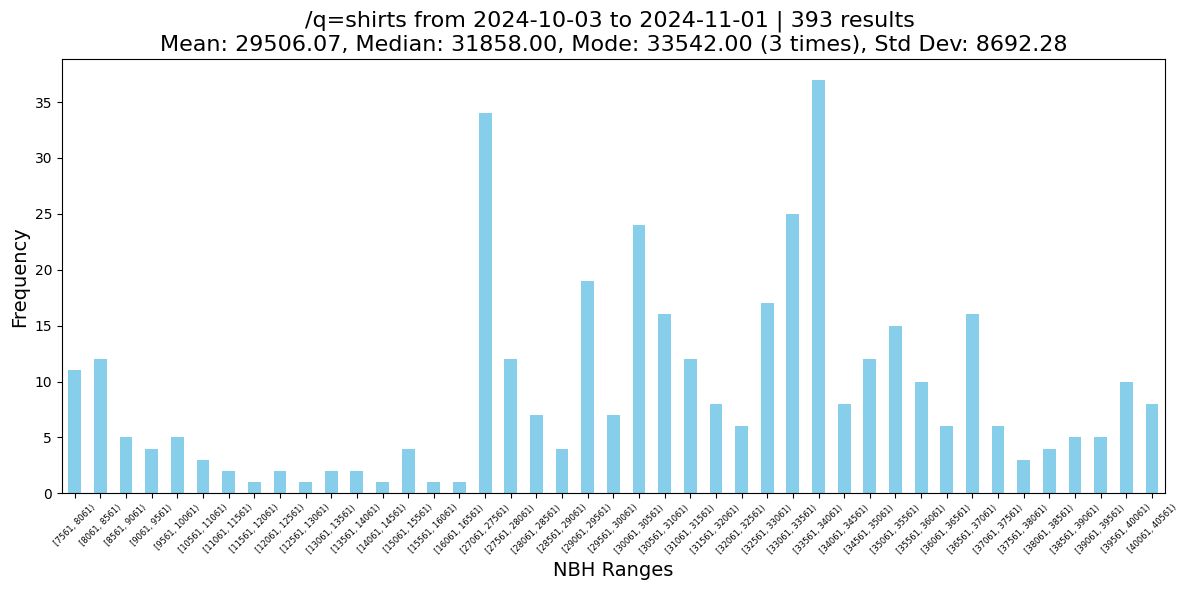

Processing date range: 2024-09-03 to 2024-10-02

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-09-03') AND DATE('2024-10-02')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'shirts'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=shirts%'
            ORDER BY
                event_date, nbh
        


Python(57722) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2024-09-25', 'nbh': '27109'}, {'event_date': '2024-09-25', 'nbh': '27142'}, {'event_date': '2024-09-25', 'nbh': '27160'}, {'event_date': '2024-09-25', 'nbh': '33789'}, {'event_date': '2024-09-25', 'nbh': '33836'}, {'event_date': '2024-09-26', 'nbh': '7383'}, {'event_date': '2024-09-26', 'nbh': '7385'}, {'event_date': '2024-09-26', 'nbh': '27312'}, {'event_date': '2024-09-26', 'nbh': '27401'}, {'event_date': '2024-09-26', 'nbh': '27417'}, {'event_date': '2024-09-26', 'nbh': '27449'}, {'event_date': '2024-09-26', 'nbh': '33692'}, {'event_date': '2024-09-26', 'nbh': '33812'}, {'event_date': '2024-09-26', 'nbh': '33850'}, {'event_date': '2024-09-26', 'nbh': '33859'}, {'event_date': '2024-09-26', 'nbh': '33862'}, {'event_date': '2024-09-27', 'nbh': '7368'}, {'event_date': '2024-09-27', 'nbh': '7373'}, {'event_date': '2024-09-27', 'nbh': '7385'}, {'event_date': '2024-09-27', 'nbh': '27997'}, {'event_date': '2024-09-27', 'nbh': '27997'}, {'event_date': '2024-09-27', 'nbh': '2

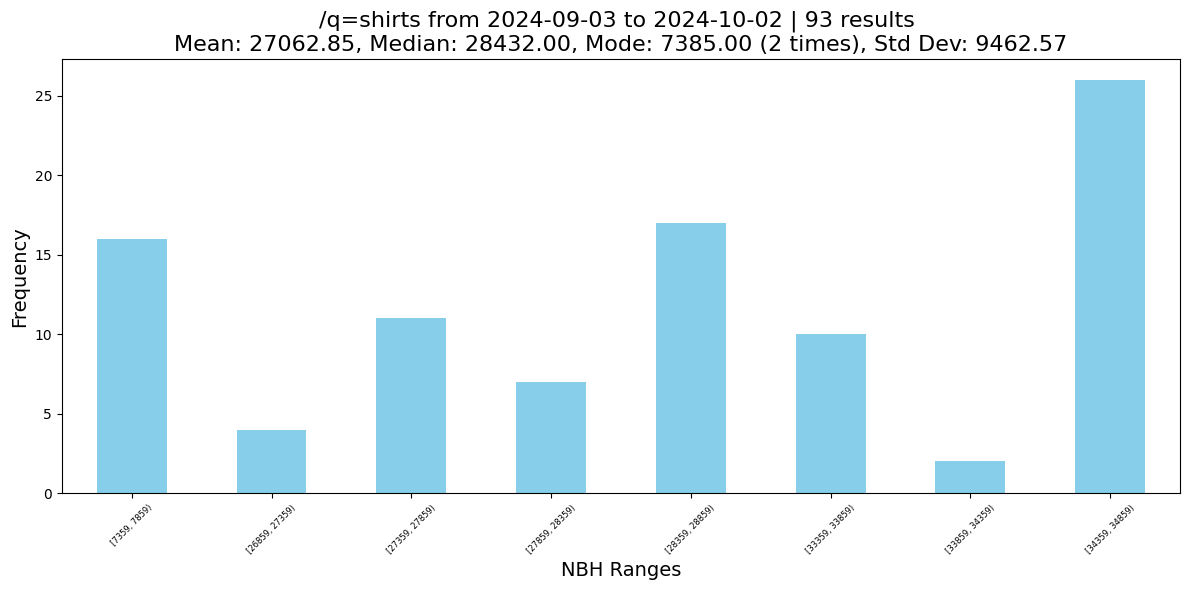

Processing date range: 2024-08-04 to 2024-09-02

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-08-04') AND DATE('2024-09-02')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'shirts'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=shirts%'
            ORDER BY
                event_date, nbh
        


Python(57812) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[]
Result saved to ./statistics_results/shirts/shirts_2024-08-04_2024-09-02.csv
No data found for search term: shirts in range 2024-08-04 to 2024-09-02
Processing date range: 2024-07-05 to 2024-08-03

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-07-05') AND DATE('2024-08-03')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'shirts'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
   

Python(57904) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[]
Result saved to ./statistics_results/shirts/shirts_2024-07-05_2024-08-03.csv
No data found for search term: shirts in range 2024-07-05 to 2024-08-03
Processing date range: 2024-06-05 to 2024-07-04

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-06-05') AND DATE('2024-07-04')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'shirts'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
   

Python(57998) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[]
Result saved to ./statistics_results/shirts/shirts_2024-06-05_2024-07-04.csv
No data found for search term: shirts in range 2024-06-05 to 2024-07-04
Processing date range: 2024-05-06 to 2024-06-04

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-05-06') AND DATE('2024-06-04')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'shirts'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
   

Python(58087) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[]
Result saved to ./statistics_results/shirts/shirts_2024-05-06_2024-06-04.csv
No data found for search term: shirts in range 2024-05-06 to 2024-06-04
Stats: [{'start_date': '2025-05-01', 'end_date': '2025-05-06', 'mean': np.float64(30064.803030303032), 'median': np.float64(33295.5), 'mode': np.float64(400.0), 'std_dev': np.float64(10345.202500482563)}, {'start_date': '2025-04-01', 'end_date': '2025-04-30', 'mean': np.float64(27514.613526570047), 'median': np.float64(32197.0), 'mode': np.float64(400.0), 'std_dev': np.float64(14136.196513536826)}, {'start_date': '2025-03-02', 'end_date': '2025-03-31', 'mean': np.float64(31911.15064935065), 'median': np.float64(33860.0), 'mode': np.float64(400.0), 'std_dev': np.float64(6698.494917093616)}, {'start_date': '2025-01-31', 'end_date': '2025-03-01', 'mean': np.float64(31807.851744186046), 'median': np.float64(32499.0), 'mode': np.float64(18184.0), 'std_dev': np.float64(5877.10203111011)}, {'start_date': '2025-01-01', 'end_date': '2025-01-30',

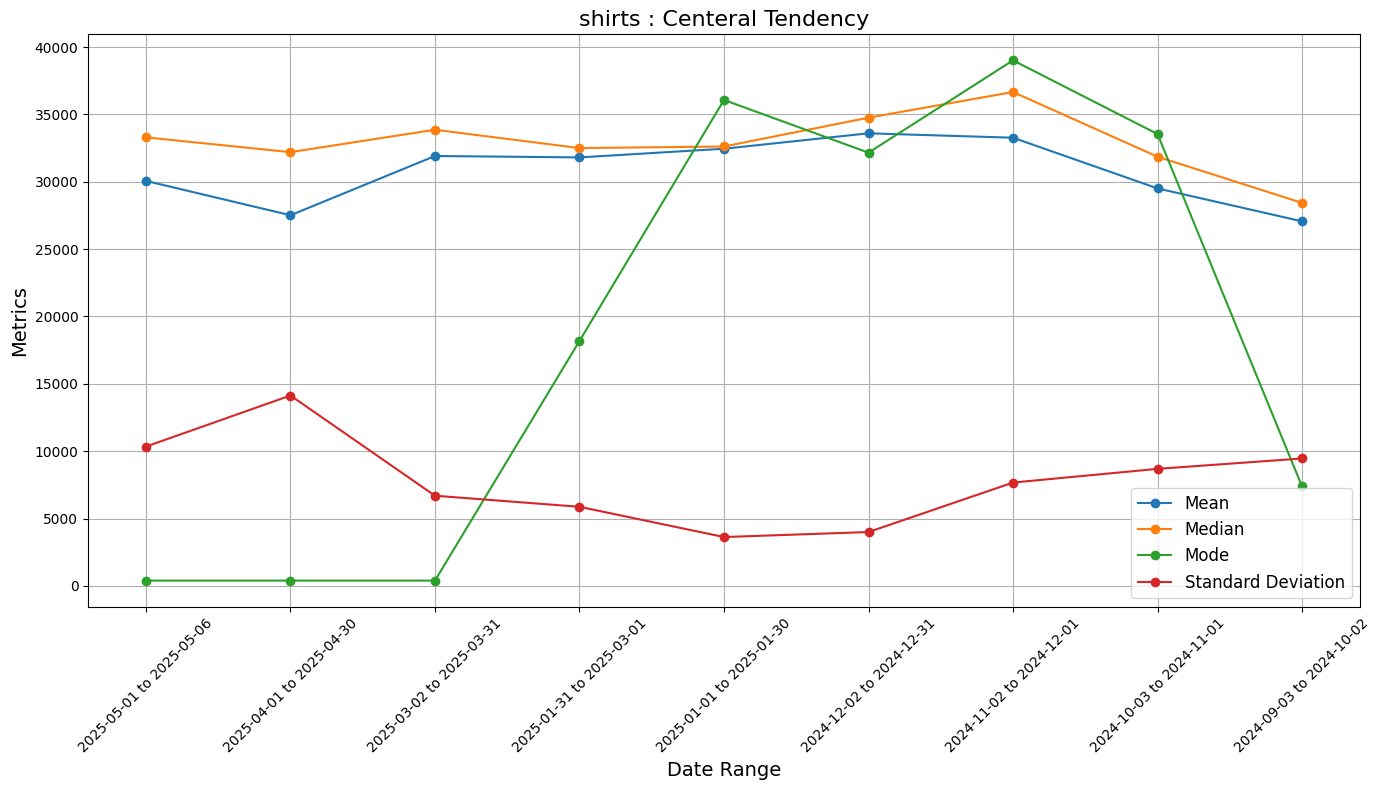

Stats saved to ./statistics_results/shirts/centeral_tendency.csv
Percentiles:   search_term  start_date    end_date  5th_percentile  10th_percentile  \
0      shirts  2025-05-01  2025-05-06         4055.75          17669.0   
1      shirts  2025-04-01  2025-04-30          400.00            400.0   
2      shirts  2025-03-02  2025-03-31        18428.60          19258.6   
3      shirts  2025-01-31  2025-03-01        17486.20          18245.8   
4      shirts  2025-01-01  2025-01-30        27402.50          28268.6   
5      shirts  2024-12-02  2024-12-31        30294.70          30907.8   
6      shirts  2024-11-02  2024-12-01        16492.50          17904.6   
7      shirts  2024-10-03  2024-11-01         8434.60          10963.6   
8      shirts  2024-09-03  2024-10-02         7379.00           7443.2   

   15th_percentile  50th_percentile  75th_percentile  90th_percentile  \
0         17852.75          33295.5         35576.50          35611.0   
1           400.00          32197.0

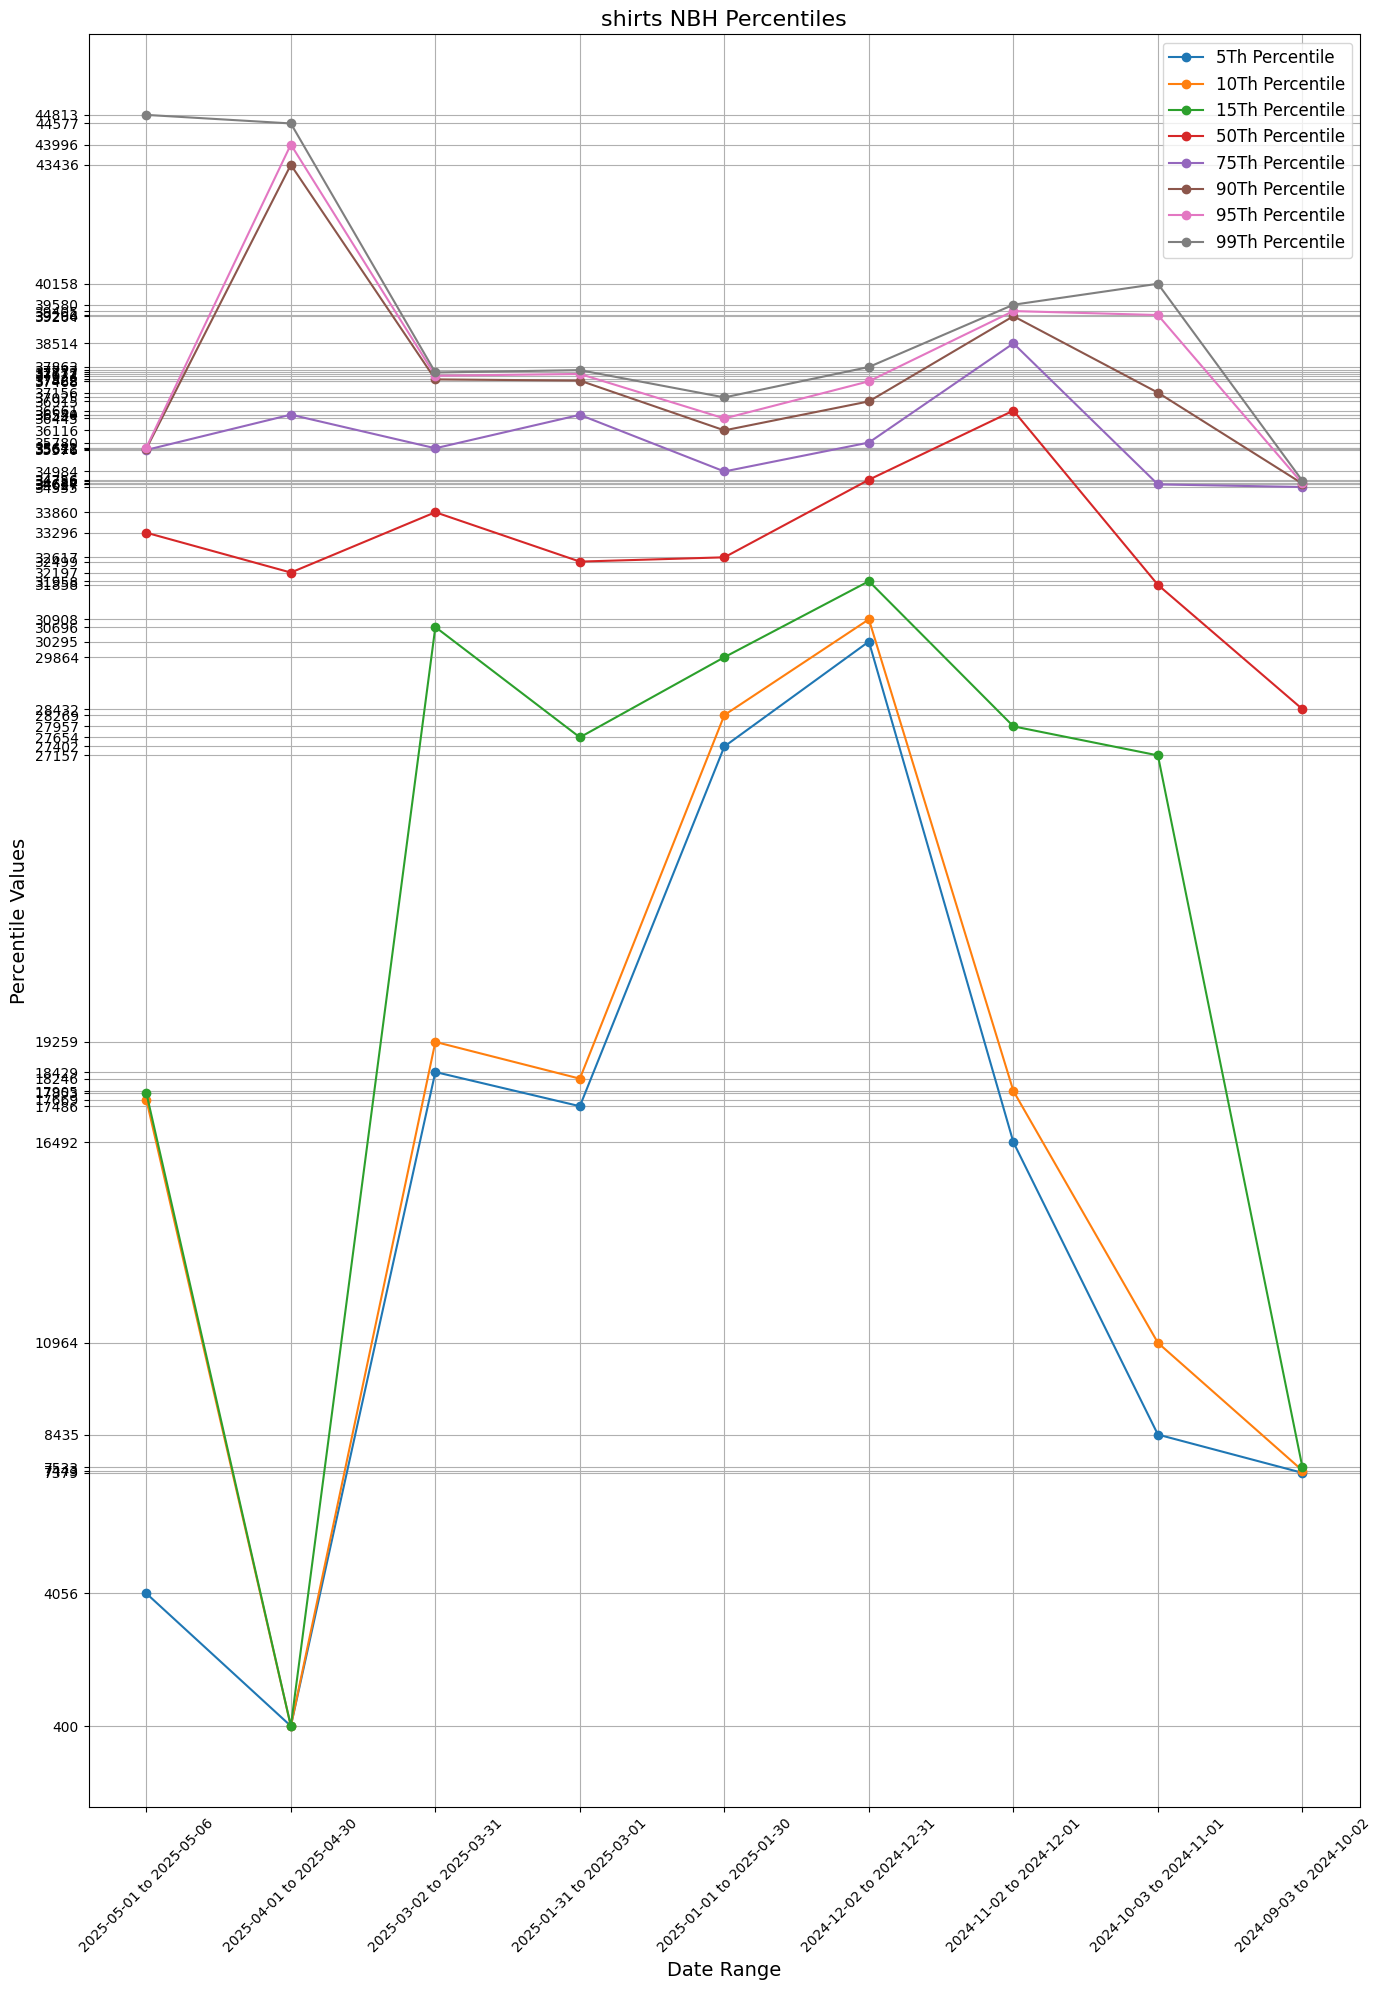

Stats saved to ./statistics_results/shirts/percentiles.csv
Processing search term: 5g mobile low price
Processing date range: 2025-05-01 to 2025-05-06

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-05-01') AND DATE('2025-05-06')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = '5g mobile low price'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR

Python(58181) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-05-01', 'nbh': '400'}, {'event_date': '2025-05-01', 'nbh': '400'}, {'event_date': '2025-05-01', 'nbh': '403'}, {'event_date': '2025-05-01', 'nbh': '403'}, {'event_date': '2025-05-01', 'nbh': '405'}, {'event_date': '2025-05-01', 'nbh': '691'}, {'event_date': '2025-05-01', 'nbh': '691'}, {'event_date': '2025-05-01', 'nbh': '692'}, {'event_date': '2025-05-01', 'nbh': '1514'}, {'event_date': '2025-05-01', 'nbh': '1526'}, {'event_date': '2025-05-01', 'nbh': '1561'}, {'event_date': '2025-05-01', 'nbh': '1574'}, {'event_date': '2025-05-01', 'nbh': '1580'}, {'event_date': '2025-05-02', 'nbh': '385'}, {'event_date': '2025-05-02', 'nbh': '388'}, {'event_date': '2025-05-02', 'nbh': '1254'}, {'event_date': '2025-05-02', 'nbh': '1422'}, {'event_date': '2025-05-02', 'nbh': '1428'}, {'event_date': '2025-05-02', 'nbh': '1452'}, {'event_date': '2025-05-02', 'nbh': '1455'}, {'event_date': '2025-05-02', 'nbh': '1496'}, {'event_date': '2025-05-02', 'nbh': '1510'}, {'event_date': '202

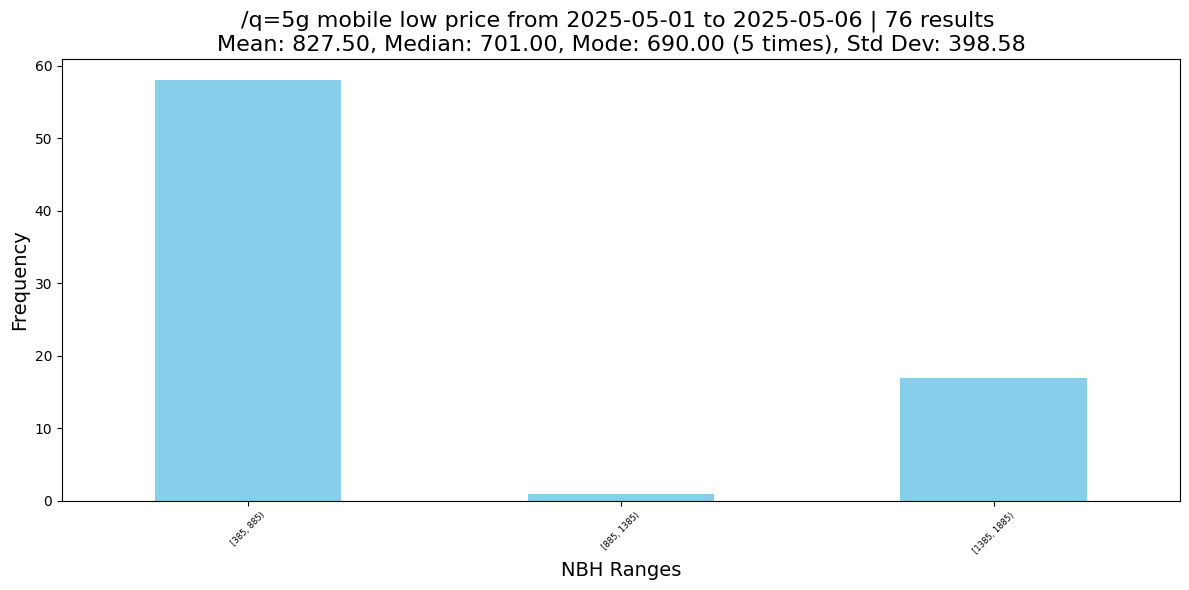

Processing date range: 2025-04-01 to 2025-04-30

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-04-01') AND DATE('2025-04-30')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = '5g mobile low price'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=5g%20mobile%20low%20price%'
            ORDER BY
               

Python(58273) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-04-01', 'nbh': '49'}, {'event_date': '2025-04-01', 'nbh': '51'}, {'event_date': '2025-04-01', 'nbh': '511'}, {'event_date': '2025-04-01', 'nbh': '524'}, {'event_date': '2025-04-01', 'nbh': '547'}, {'event_date': '2025-04-01', 'nbh': '710'}, {'event_date': '2025-04-01', 'nbh': '713'}, {'event_date': '2025-04-01', 'nbh': '715'}, {'event_date': '2025-04-01', 'nbh': '715'}, {'event_date': '2025-04-01', 'nbh': '721'}, {'event_date': '2025-04-02', 'nbh': '47'}, {'event_date': '2025-04-02', 'nbh': '492'}, {'event_date': '2025-04-02', 'nbh': '496'}, {'event_date': '2025-04-02', 'nbh': '501'}, {'event_date': '2025-04-02', 'nbh': '502'}, {'event_date': '2025-04-02', 'nbh': '506'}, {'event_date': '2025-04-02', 'nbh': '721'}, {'event_date': '2025-04-02', 'nbh': '730'}, {'event_date': '2025-04-02', 'nbh': '732'}, {'event_date': '2025-04-02', 'nbh': '733'}, {'event_date': '2025-04-02', 'nbh': '733'}, {'event_date': '2025-04-02', 'nbh': '735'}, {'event_date': '2025-04-02', 'nbh'

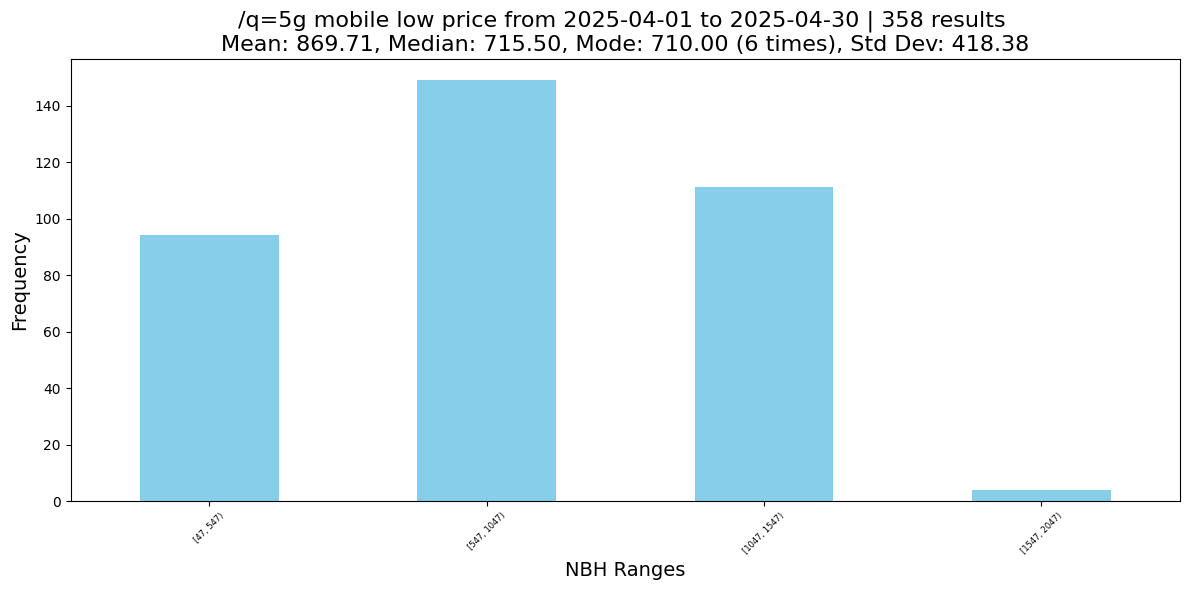

Processing date range: 2025-03-02 to 2025-03-31

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-03-02') AND DATE('2025-03-31')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = '5g mobile low price'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=5g%20mobile%20low%20price%'
            ORDER BY
               

Python(58363) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-03-02', 'nbh': '531'}, {'event_date': '2025-03-02', 'nbh': '540'}, {'event_date': '2025-03-02', 'nbh': '778'}, {'event_date': '2025-03-02', 'nbh': '779'}, {'event_date': '2025-03-02', 'nbh': '782'}, {'event_date': '2025-03-02', 'nbh': '782'}, {'event_date': '2025-03-02', 'nbh': '783'}, {'event_date': '2025-03-02', 'nbh': '784'}, {'event_date': '2025-03-02', 'nbh': '784'}, {'event_date': '2025-03-02', 'nbh': '785'}, {'event_date': '2025-03-02', 'nbh': '786'}, {'event_date': '2025-03-02', 'nbh': '787'}, {'event_date': '2025-03-02', 'nbh': '788'}, {'event_date': '2025-03-02', 'nbh': '789'}, {'event_date': '2025-03-02', 'nbh': '789'}, {'event_date': '2025-03-02', 'nbh': '790'}, {'event_date': '2025-03-02', 'nbh': '790'}, {'event_date': '2025-03-02', 'nbh': '791'}, {'event_date': '2025-03-02', 'nbh': '791'}, {'event_date': '2025-03-02', 'nbh': '791'}, {'event_date': '2025-03-02', 'nbh': '792'}, {'event_date': '2025-03-03', 'nbh': '506'}, {'event_date': '2025-03-03', 'n

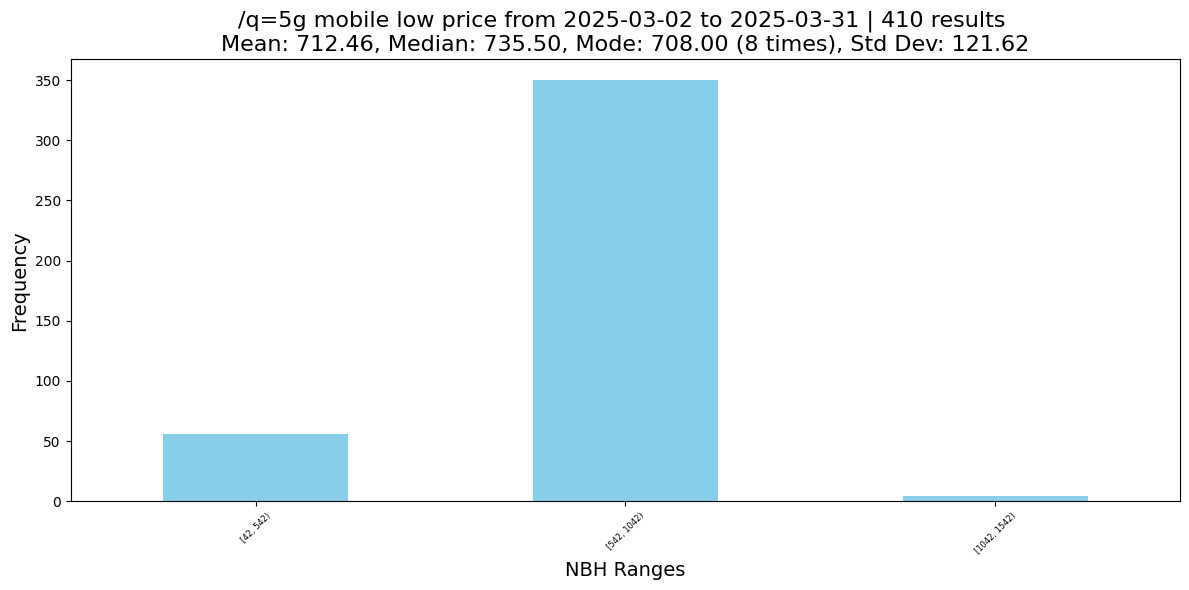

Processing date range: 2025-01-31 to 2025-03-01

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-01-31') AND DATE('2025-03-01')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = '5g mobile low price'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=5g%20mobile%20low%20price%'
            ORDER BY
               

Python(58463) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-01-31', 'nbh': '1222'}, {'event_date': '2025-01-31', 'nbh': '1230'}, {'event_date': '2025-01-31', 'nbh': '1236'}, {'event_date': '2025-01-31', 'nbh': '1239'}, {'event_date': '2025-01-31', 'nbh': '1240'}, {'event_date': '2025-01-31', 'nbh': '1241'}, {'event_date': '2025-01-31', 'nbh': '1243'}, {'event_date': '2025-01-31', 'nbh': '1244'}, {'event_date': '2025-01-31', 'nbh': '1255'}, {'event_date': '2025-01-31', 'nbh': '1255'}, {'event_date': '2025-01-31', 'nbh': '1257'}, {'event_date': '2025-01-31', 'nbh': '1257'}, {'event_date': '2025-02-01', 'nbh': '656'}, {'event_date': '2025-02-01', 'nbh': '668'}, {'event_date': '2025-02-01', 'nbh': '1184'}, {'event_date': '2025-02-01', 'nbh': '1184'}, {'event_date': '2025-02-01', 'nbh': '1184'}, {'event_date': '2025-02-01', 'nbh': '1185'}, {'event_date': '2025-02-01', 'nbh': '1185'}, {'event_date': '2025-02-01', 'nbh': '1187'}, {'event_date': '2025-02-01', 'nbh': '1187'}, {'event_date': '2025-02-01', 'nbh': '1193'}, {'event_dat

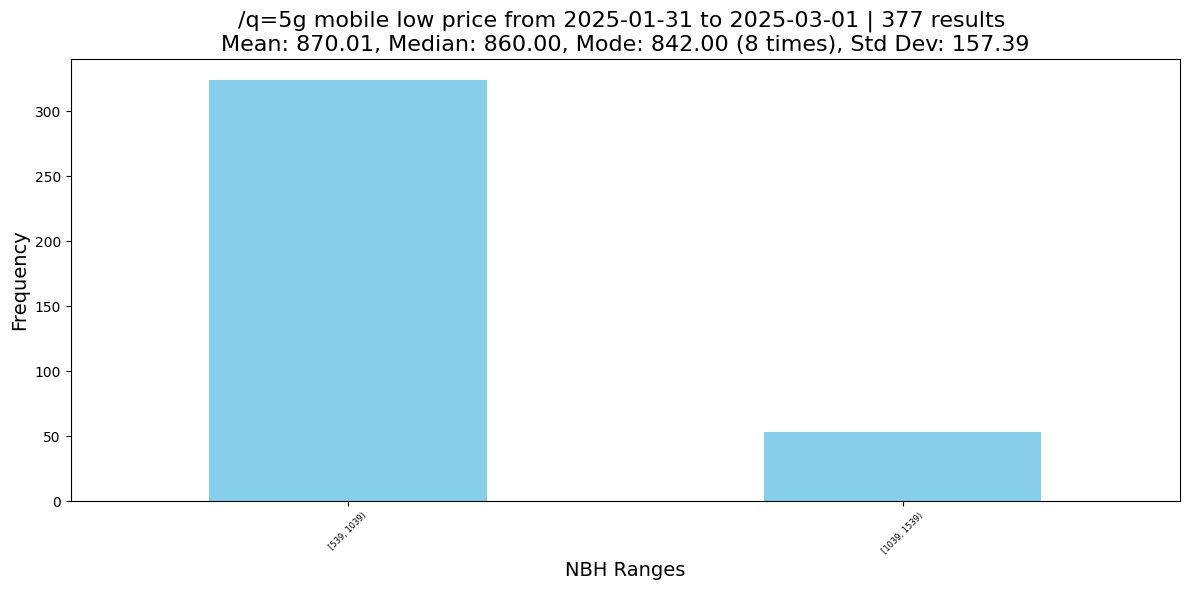

Processing date range: 2025-01-01 to 2025-01-30

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-01-01') AND DATE('2025-01-30')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = '5g mobile low price'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=5g%20mobile%20low%20price%'
            ORDER BY
               

Python(58563) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-01-01', 'nbh': '818'}, {'event_date': '2025-01-01', 'nbh': '824'}, {'event_date': '2025-01-01', 'nbh': '831'}, {'event_date': '2025-01-01', 'nbh': '831'}, {'event_date': '2025-01-01', 'nbh': '833'}, {'event_date': '2025-01-01', 'nbh': '836'}, {'event_date': '2025-01-01', 'nbh': '838'}, {'event_date': '2025-01-01', 'nbh': '838'}, {'event_date': '2025-01-02', 'nbh': '770'}, {'event_date': '2025-01-02', 'nbh': '771'}, {'event_date': '2025-01-02', 'nbh': '774'}, {'event_date': '2025-01-02', 'nbh': '781'}, {'event_date': '2025-01-02', 'nbh': '809'}, {'event_date': '2025-01-02', 'nbh': '811'}, {'event_date': '2025-01-02', 'nbh': '811'}, {'event_date': '2025-01-02', 'nbh': '812'}, {'event_date': '2025-01-02', 'nbh': '812'}, {'event_date': '2025-01-02', 'nbh': '813'}, {'event_date': '2025-01-02', 'nbh': '815'}, {'event_date': '2025-01-02', 'nbh': '827'}, {'event_date': '2025-01-02', 'nbh': '833'}, {'event_date': '2025-01-03', 'nbh': '759'}, {'event_date': '2025-01-03', 'n

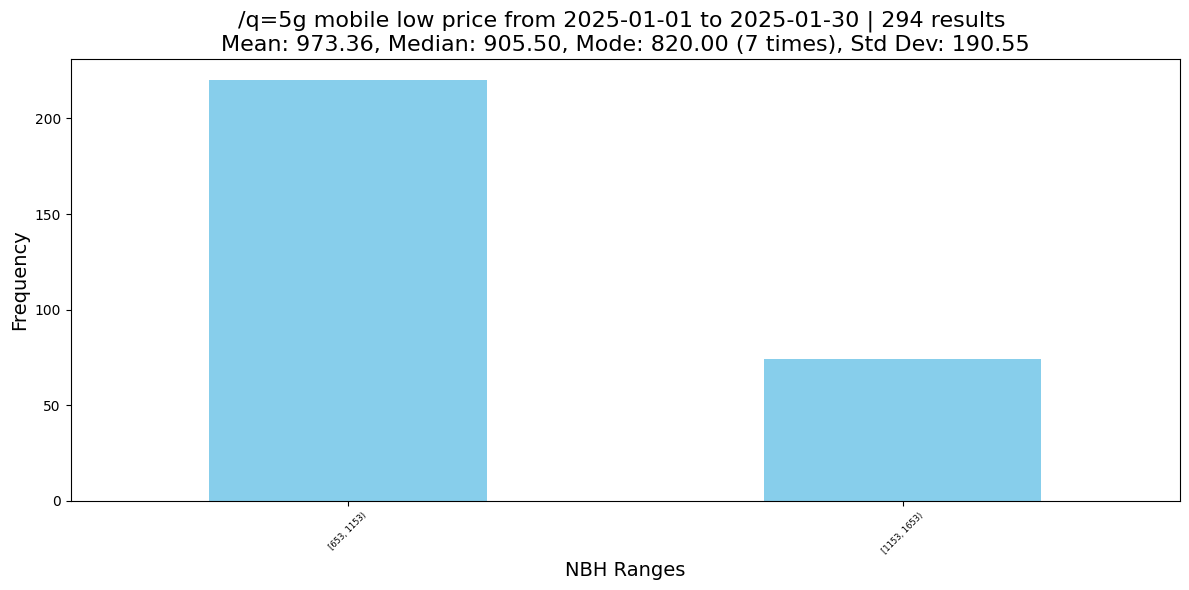

Processing date range: 2024-12-02 to 2024-12-31

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-12-02') AND DATE('2024-12-31')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = '5g mobile low price'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=5g%20mobile%20low%20price%'
            ORDER BY
               

Python(58654) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2024-12-02', 'nbh': '514'}, {'event_date': '2024-12-02', 'nbh': '515'}, {'event_date': '2024-12-02', 'nbh': '517'}, {'event_date': '2024-12-02', 'nbh': '519'}, {'event_date': '2024-12-02', 'nbh': '521'}, {'event_date': '2024-12-02', 'nbh': '523'}, {'event_date': '2024-12-02', 'nbh': '524'}, {'event_date': '2024-12-02', 'nbh': '525'}, {'event_date': '2024-12-02', 'nbh': '1170'}, {'event_date': '2024-12-02', 'nbh': '1170'}, {'event_date': '2024-12-02', 'nbh': '1172'}, {'event_date': '2024-12-02', 'nbh': '1173'}, {'event_date': '2024-12-02', 'nbh': '1174'}, {'event_date': '2024-12-02', 'nbh': '1175'}, {'event_date': '2024-12-02', 'nbh': '1176'}, {'event_date': '2024-12-02', 'nbh': '1177'}, {'event_date': '2024-12-02', 'nbh': '1184'}, {'event_date': '2024-12-02', 'nbh': '1192'}, {'event_date': '2024-12-02', 'nbh': '1193'}, {'event_date': '2024-12-02', 'nbh': '1210'}, {'event_date': '2024-12-02', 'nbh': '1211'}, {'event_date': '2024-12-02', 'nbh': '1232'}, {'event_date': '2

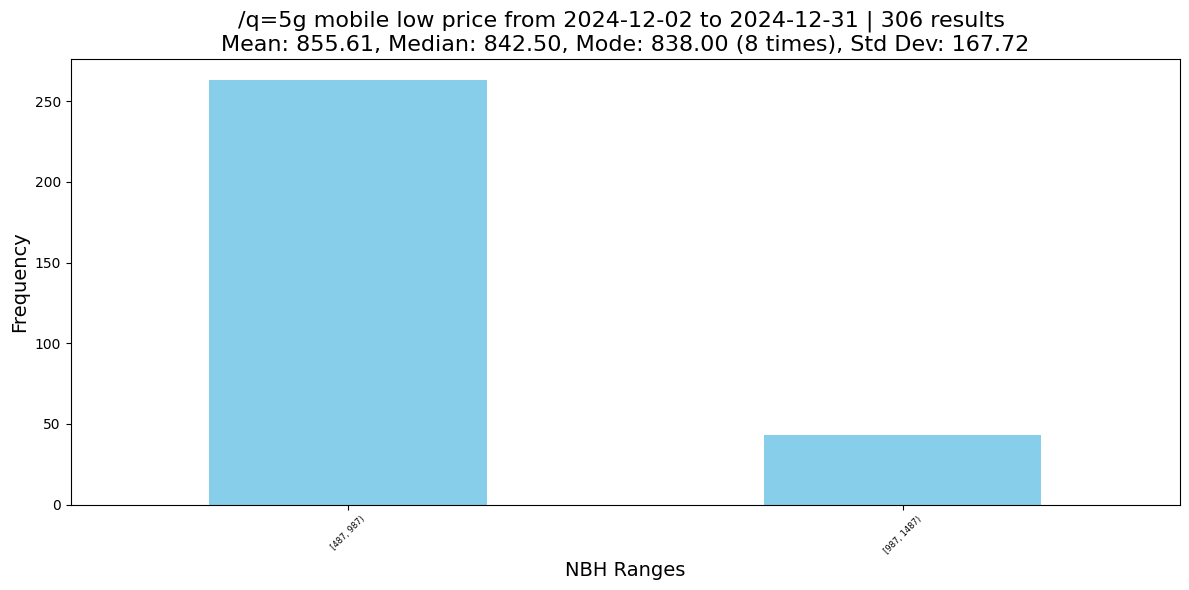

Processing date range: 2024-11-02 to 2024-12-01

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-11-02') AND DATE('2024-12-01')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = '5g mobile low price'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=5g%20mobile%20low%20price%'
            ORDER BY
               

Python(58759) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2024-11-02', 'nbh': '636'}, {'event_date': '2024-11-02', 'nbh': '640'}, {'event_date': '2024-11-02', 'nbh': '646'}, {'event_date': '2024-11-02', 'nbh': '648'}, {'event_date': '2024-11-02', 'nbh': '657'}, {'event_date': '2024-11-03', 'nbh': '655'}, {'event_date': '2024-11-03', 'nbh': '662'}, {'event_date': '2024-11-03', 'nbh': '662'}, {'event_date': '2024-11-03', 'nbh': '2174'}, {'event_date': '2024-11-03', 'nbh': '2442'}, {'event_date': '2024-11-03', 'nbh': '2526'}, {'event_date': '2024-11-04', 'nbh': '658'}, {'event_date': '2024-11-04', 'nbh': '667'}, {'event_date': '2024-11-04', 'nbh': '667'}, {'event_date': '2024-11-04', 'nbh': '2641'}, {'event_date': '2024-11-04', 'nbh': '2645'}, {'event_date': '2024-11-05', 'nbh': '658'}, {'event_date': '2024-11-05', 'nbh': '661'}, {'event_date': '2024-11-05', 'nbh': '663'}, {'event_date': '2024-11-05', 'nbh': '664'}, {'event_date': '2024-11-05', 'nbh': '665'}, {'event_date': '2024-11-05', 'nbh': '665'}, {'event_date': '2024-11-05

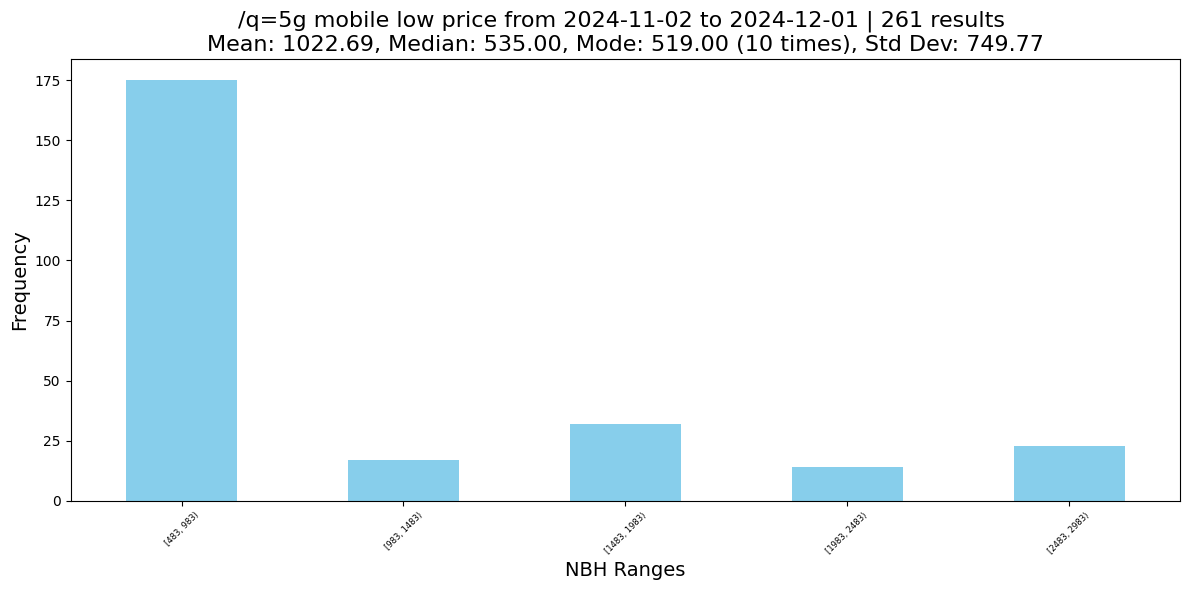

Processing date range: 2024-10-03 to 2024-11-01

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-10-03') AND DATE('2024-11-01')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = '5g mobile low price'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=5g%20mobile%20low%20price%'
            ORDER BY
               

Python(58844) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2024-10-03', 'nbh': '453'}, {'event_date': '2024-10-03', 'nbh': '454'}, {'event_date': '2024-10-03', 'nbh': '455'}, {'event_date': '2024-10-03', 'nbh': '456'}, {'event_date': '2024-10-03', 'nbh': '457'}, {'event_date': '2024-10-03', 'nbh': '460'}, {'event_date': '2024-10-03', 'nbh': '460'}, {'event_date': '2024-10-03', 'nbh': '1614'}, {'event_date': '2024-10-03', 'nbh': '1620'}, {'event_date': '2024-10-04', 'nbh': '431'}, {'event_date': '2024-10-04', 'nbh': '432'}, {'event_date': '2024-10-04', 'nbh': '432'}, {'event_date': '2024-10-04', 'nbh': '435'}, {'event_date': '2024-10-04', 'nbh': '451'}, {'event_date': '2024-10-04', 'nbh': '1609'}, {'event_date': '2024-10-04', 'nbh': '1614'}, {'event_date': '2024-10-05', 'nbh': '422'}, {'event_date': '2024-10-05', 'nbh': '423'}, {'event_date': '2024-10-05', 'nbh': '424'}, {'event_date': '2024-10-05', 'nbh': '424'}, {'event_date': '2024-10-05', 'nbh': '1612'}, {'event_date': '2024-10-06', 'nbh': '421'}, {'event_date': '2024-10-06

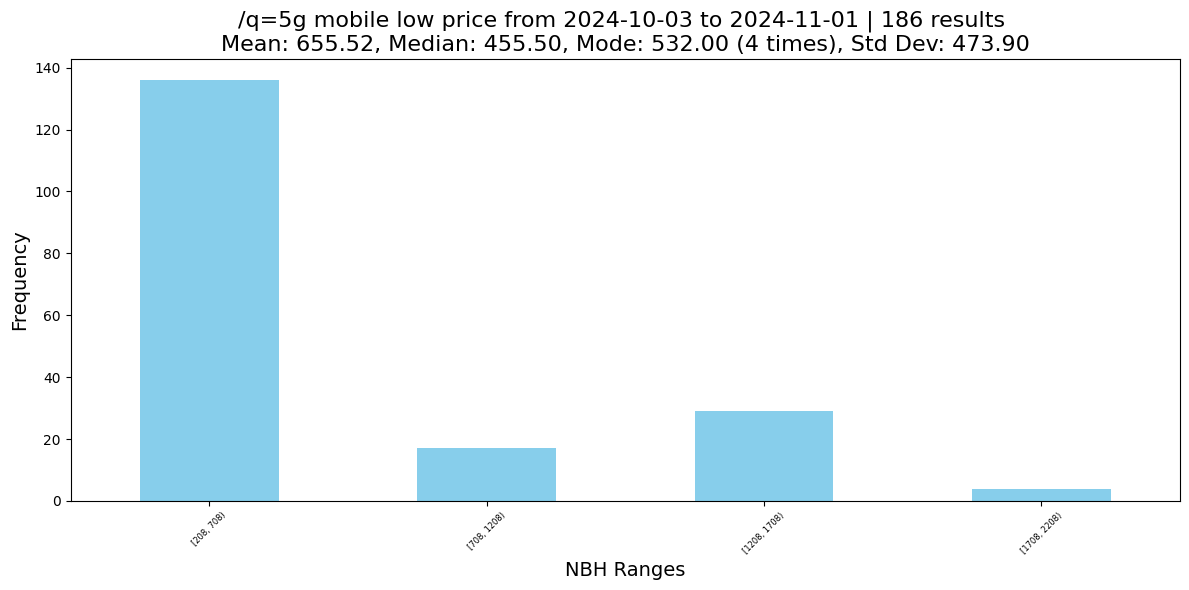

Processing date range: 2024-09-03 to 2024-10-02

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-09-03') AND DATE('2024-10-02')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = '5g mobile low price'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=5g%20mobile%20low%20price%'
            ORDER BY
               

Python(58934) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2024-09-25', 'nbh': '478'}, {'event_date': '2024-09-25', 'nbh': '1756'}, {'event_date': '2024-09-25', 'nbh': '1756'}, {'event_date': '2024-09-25', 'nbh': '1756'}, {'event_date': '2024-09-26', 'nbh': '473'}, {'event_date': '2024-09-26', 'nbh': '473'}, {'event_date': '2024-09-26', 'nbh': '474'}, {'event_date': '2024-09-26', 'nbh': '474'}, {'event_date': '2024-09-26', 'nbh': '475'}, {'event_date': '2024-09-26', 'nbh': '475'}, {'event_date': '2024-09-26', 'nbh': '1751'}, {'event_date': '2024-09-26', 'nbh': '1760'}, {'event_date': '2024-09-26', 'nbh': '1760'}, {'event_date': '2024-09-27', 'nbh': '464'}, {'event_date': '2024-09-27', 'nbh': '465'}, {'event_date': '2024-09-27', 'nbh': '466'}, {'event_date': '2024-09-27', 'nbh': '468'}, {'event_date': '2024-09-27', 'nbh': '469'}, {'event_date': '2024-09-27', 'nbh': '471'}, {'event_date': '2024-09-27', 'nbh': '1725'}, {'event_date': '2024-09-27', 'nbh': '1725'}, {'event_date': '2024-09-27', 'nbh': '1734'}, {'event_date': '2024-0

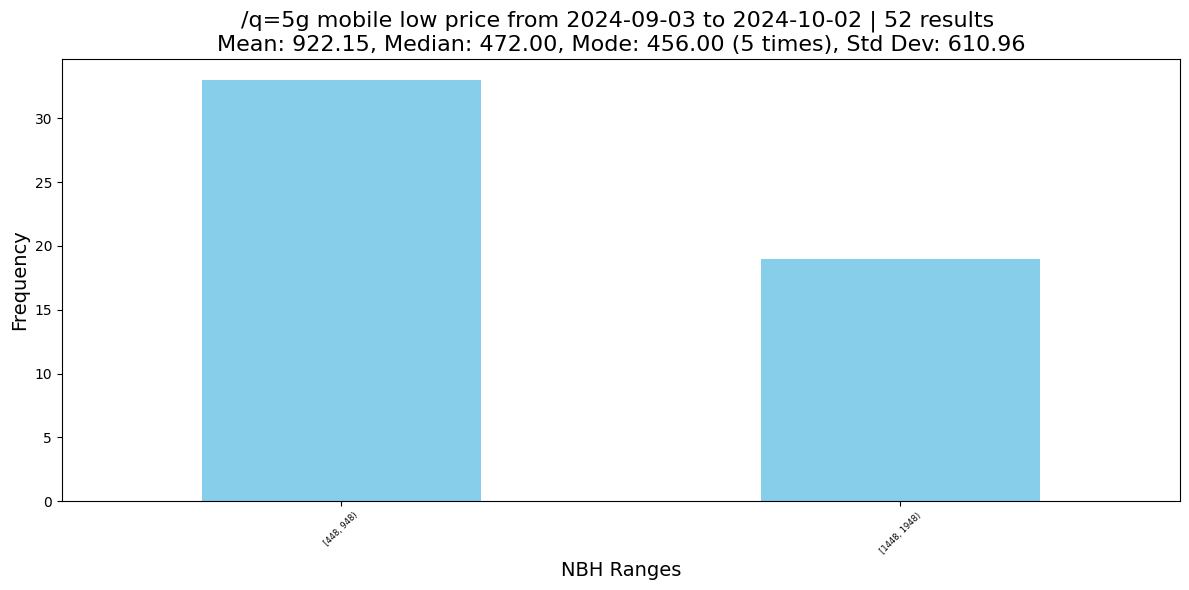

Processing date range: 2024-08-04 to 2024-09-02

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-08-04') AND DATE('2024-09-02')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = '5g mobile low price'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=5g%20mobile%20low%20price%'
            ORDER BY
               

Python(59020) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[]
Result saved to ./statistics_results/5g mobile low price/5g mobile low price_2024-08-04_2024-09-02.csv
No data found for search term: 5g mobile low price in range 2024-08-04 to 2024-09-02
Processing date range: 2024-07-05 to 2024-08-03

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-07-05') AND DATE('2024-08-03')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = '5g mobile low price'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSO

Python(59111) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[]
Result saved to ./statistics_results/5g mobile low price/5g mobile low price_2024-07-05_2024-08-03.csv
No data found for search term: 5g mobile low price in range 2024-07-05 to 2024-08-03
Processing date range: 2024-06-05 to 2024-07-04

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-06-05') AND DATE('2024-07-04')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = '5g mobile low price'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSO

Python(59202) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[]
Result saved to ./statistics_results/5g mobile low price/5g mobile low price_2024-06-05_2024-07-04.csv
No data found for search term: 5g mobile low price in range 2024-06-05 to 2024-07-04
Processing date range: 2024-05-06 to 2024-06-04

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2024-05-06') AND DATE('2024-06-04')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = '5g mobile low price'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSO

Python(59295) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[]
Result saved to ./statistics_results/5g mobile low price/5g mobile low price_2024-05-06_2024-06-04.csv
No data found for search term: 5g mobile low price in range 2024-05-06 to 2024-06-04
Stats: [{'start_date': '2025-05-01', 'end_date': '2025-05-06', 'mean': np.float64(827.5), 'median': np.float64(701.0), 'mode': np.float64(690.0), 'std_dev': np.float64(398.5825385036329)}, {'start_date': '2025-04-01', 'end_date': '2025-04-30', 'mean': np.float64(869.7067039106146), 'median': np.float64(715.5), 'mode': np.float64(710.0), 'std_dev': np.float64(418.3798556962449)}, {'start_date': '2025-03-02', 'end_date': '2025-03-31', 'mean': np.float64(712.4609756097561), 'median': np.float64(735.5), 'mode': np.float64(708.0), 'std_dev': np.float64(121.61675621676847)}, {'start_date': '2025-01-31', 'end_date': '2025-03-01', 'mean': np.float64(870.0079575596817), 'median': np.float64(860.0), 'mode': np.float64(842.0), 'std_dev': np.float64(157.38569793736735)}, {'start_date': '2025-01-01', 'end_date'

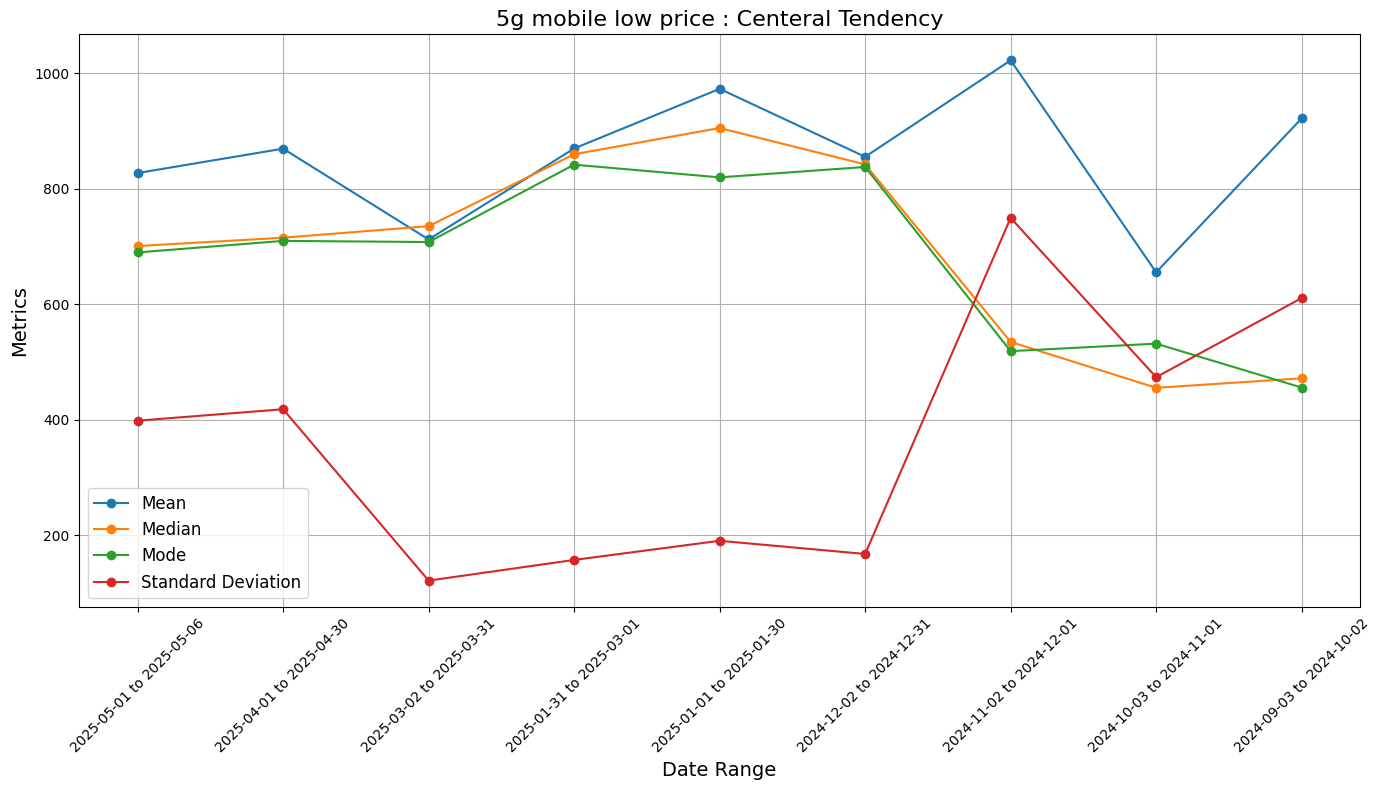

Stats saved to ./statistics_results/5g mobile low price/centeral_tendency.csv
Percentiles:            search_term  start_date    end_date  5th_percentile  \
0  5g mobile low price  2025-05-01  2025-05-06          399.50   
1  5g mobile low price  2025-04-01  2025-04-30          410.85   
2  5g mobile low price  2025-03-02  2025-03-31          493.00   
3  5g mobile low price  2025-01-31  2025-03-01          567.00   
4  5g mobile low price  2025-01-01  2025-01-30          775.95   
5  5g mobile low price  2024-12-02  2024-12-31          523.25   
6  5g mobile low price  2024-11-02  2024-12-01          494.00   
7  5g mobile low price  2024-10-03  2024-11-01          239.00   
8  5g mobile low price  2024-09-03  2024-10-02          453.55   

   10th_percentile  15th_percentile  50th_percentile  75th_percentile  \
0            403.0           407.50            701.0           728.00   
1            421.0           431.00            715.5          1409.75   
2            514.9           

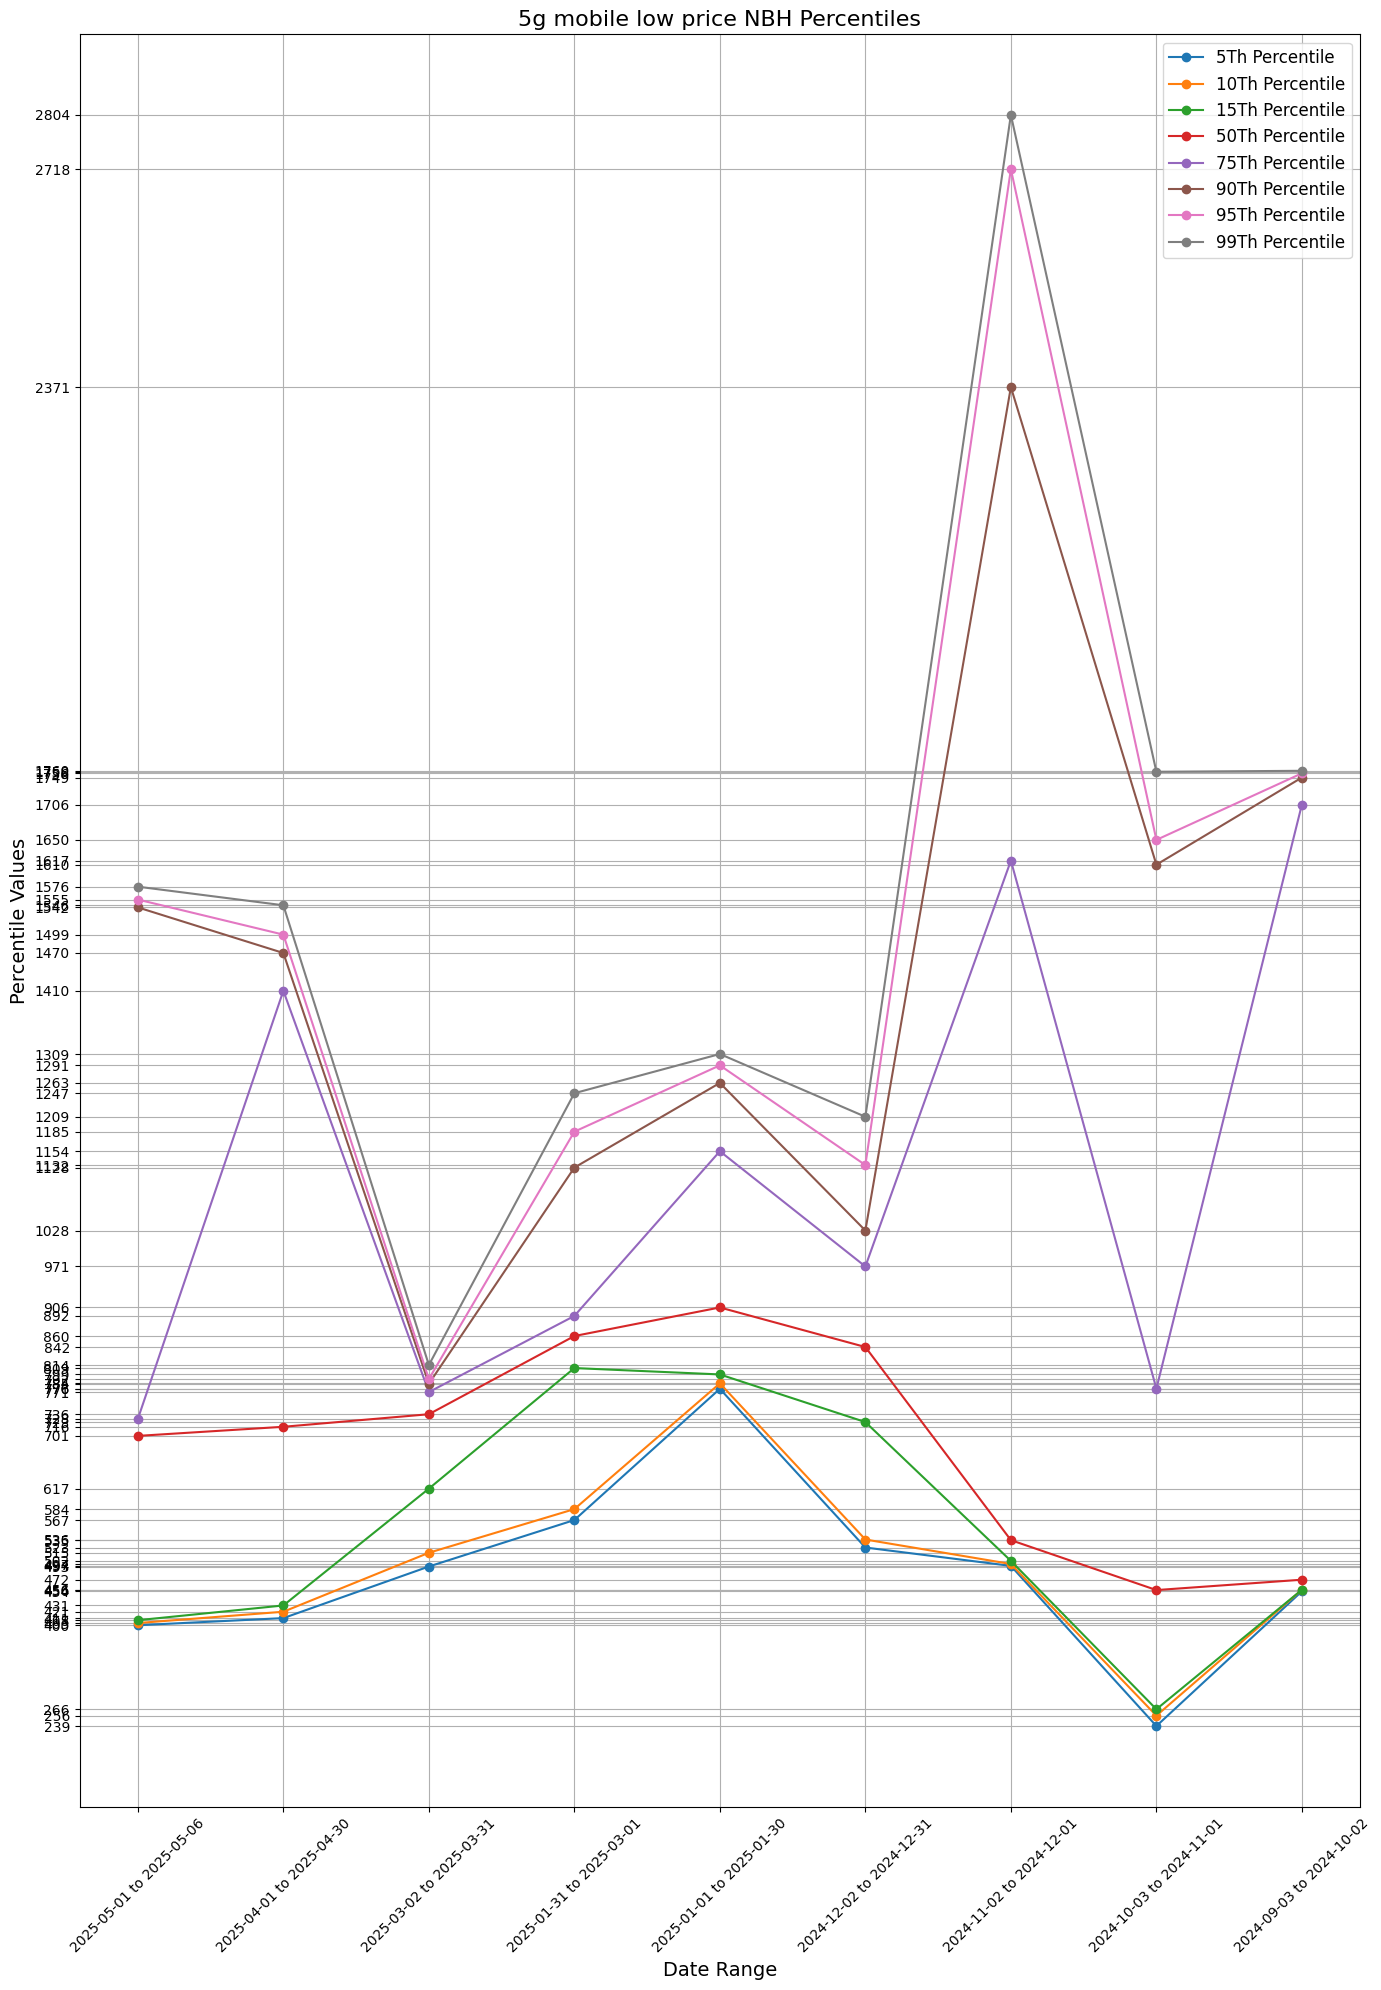

Stats saved to ./statistics_results/5g mobile low price/percentiles.csv


In [136]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def load_results_with_400(file_path):
    """
    Load the results with 400 from a CSV file.
    """
    return pd.read_csv(file_path)

def generate_date_ranges(start_date, end_date, days_jump):
    """
    Generate date ranges using the helper function.
    """
    return helpers.generate_date_ranges(start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d"), days_jump=days_jump)

def execute_nbh_query(project_id, search_term, start_date, end_date , csv_path=None , csv_name=None):
    """
    Execute the NBH query for a given date range.
    """
    query = NBHRawQuery.SimpleNBHDateRangeQuery(project_id=project_id, search_term=search_term, start_date=start_date, end_date=end_date)
    print(query.query)
    result =  BigQueryExecutor.BigQueryExecutor().execute_query(query, cache=True)

    if csv_name and csv_path:
        # Save the result to a CSV file
        result.to_csv(f"{csv_path}/{csv_name}.csv", index=False)
        print(f"Result saved to {csv_path}/{csv_name}.csv")
    return result

def calculate_nbh_range_frequency(result, range_diff):
    """
    Calculate the frequency of NBH values within specified ranges, ignoring those with zero frequency.
    """
    if result.empty:
        return pd.Series()

    result['event_date'] = pd.to_datetime(result['event_date'])
    nbh_values = result['nbh'].astype(int)

    if nbh_values.empty:
        return pd.Series()

    min_nbh = nbh_values.min()
    max_nbh = nbh_values.max()

    # Handle the case where min and max are the same to avoid zero-length bins
    if min_nbh == max_nbh:
        print(f"Single unique NBH value detected: {min_nbh}")
        return pd.Series({f"[{min_nbh}, {min_nbh + range_diff})": len(nbh_values)})

    bins = np.arange(min_nbh, max_nbh + range_diff, range_diff)

    # Ensure at least two bins are created if range_diff is larger than the data range
    if len(bins) <= 1:
        bins = np.array([min_nbh, max_nbh + range_diff])

    print(f"--------*--- Bins {len(bins)} ---*-----------\n {bins}")
    frequency, _ = np.histogram(nbh_values, bins=bins)
    bin_labels = pd.IntervalIndex.from_breaks(bins, closed='left')
    frequency_series = pd.Series(frequency, index=bin_labels)

    # Filter out bins with zero frequency
    frequency_series = frequency_series[frequency_series > 0]
    return frequency_series

def plot_nbh_range_frequency(nbh_range_frequency, title="NBH Range Frequency", save_path=None , image_name = None):
    """
    Plot the frequency of NBH ranges as a bar graph with thinner bars and x-axis labels.
    Optionally save the plot as a PNG file to a specified path.
    """
    plt.figure(figsize=(12, 6))
    nbh_range_frequency.plot(kind='bar', color='skyblue', width=0.5)  # Reduced bar width
    plt.title(title, fontsize=16)
    plt.xlabel('NBH Ranges', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=45, fontsize=6)  # Reduced font size for x-axis labels
    plt.tight_layout()
    
    if save_path and image_name:
        image_name = f"{save_path}/{image_name}.png"
        plt.savefig(image_name, format='png', dpi=300)
        print(f"Plot saved to {image_name}")
    
    plt.show()

project_id = "noonbisearch"
end_date = pd.to_datetime("2025-05-06")
start_date = pd.to_datetime("2024-05-06")
days_jump = 30
date_ranges = generate_date_ranges(start_date, end_date, days_jump)[::-1]
print(f"Date ranges: {date_ranges}")
bins_range = 500
results_folder_path = "./statistics_results"

# results_with_400_df_arr = results_with_400_df['search_query'].tolist()
results_with_400_df_arr = ["sunglasses" , "shirts" , "5g mobile low price"]
for search_term in results_with_400_df_arr:
    
    print(f"Processing search term: {search_term}")
    search_term_folder_path = f"{results_folder_path}/{search_term}"
    stats = []
    percentiles = []
        
    for date_range in date_ranges:
        range_start, range_end = date_range
        print(f"Processing date range: {range_start} to {range_end}")
        
        # create a folder in a path with the search_term name
        helpers.create_folder_if_not_exists(search_term_folder_path)

        # Execute the NBH query for the current search term and date range
        result = execute_nbh_query(project_id, search_term, range_start, range_end , csv_path=search_term_folder_path, csv_name=f"{search_term}_{range_start}_{range_end}")
        
        if result.empty:
            print(f"No data found for search term: {search_term} in range {range_start} to {range_end}")
            continue

        
        # Calculate the NBH range frequency
        nbh_range_frequency = calculate_nbh_range_frequency(result, bins_range)
        # Calculate and plot the mean NBH value
        mean_nbh = result['nbh'].astype(float).mean()
        # Calculate the median, mode, and standard deviation of NBH values
        median_nbh = result['nbh'].astype(float).median()
        mode_nbh = result['nbh'].astype(float).mode()[0] if not result['nbh'].mode().empty else None
        mode_freq = result['nbh'].astype(float).value_counts().iloc[0] if mode_nbh is not None else None
        std_dev_nbh = result['nbh'].astype(float).std()

        print(f"Median NBH: {median_nbh}")
        print(f"Mode NBH: {mode_nbh} , Frequency: {mode_freq}")
        print(f"Standard Deviation NBH: {std_dev_nbh}")
        print(f"Mean NBH: {mean_nbh}")

        result['nbh'] = pd.to_numeric(result['nbh'], errors='coerce')

        # push to perctiles array , 5ht , 10th , 15th , 50th , 75th , 90th , 95th , 99th
        percentiles.append({
            "search_term": search_term,
            "start_date": range_start,
            "end_date": range_end,
            "5th_percentile": np.percentile(result['nbh'], 5),
            "10th_percentile": np.percentile(result['nbh'], 10),
            "15th_percentile": np.percentile(result['nbh'], 15),
            "50th_percentile": np.percentile(result['nbh'], 50),
            "75th_percentile": np.percentile(result['nbh'], 75),
            "90th_percentile": np.percentile(result['nbh'], 90),
            "95th_percentile": np.percentile(result['nbh'], 95),
            "99th_percentile": np.percentile(result['nbh'], 99)
        })

        plot_nbh_range_frequency(
            nbh_range_frequency,
            save_path=search_term_folder_path,
            image_name=f"{range_start}_{range_end}_nbh_range_frequency",
            title=f"/q={search_term} from {range_start} to {range_end} | {len(result)} results \nMean: {mean_nbh:.2f}, Median: {median_nbh:.2f}, Mode: {mode_nbh:.2f} ({mode_freq} times), Std Dev: {std_dev_nbh:.2f}"
        )

        stats.append({"start_date": range_start, "end_date": range_end, "mean": mean_nbh, "median": median_nbh, "mode": mode_nbh, "std_dev": std_dev_nbh})
    
    # Convert stats to a DataFrame for easier plotting
    print(f"Stats: {stats}")
    stats_df = pd.DataFrame(stats)


    # Ensure the DataFrame is not empty
    if not stats_df.empty:
        stats_df['date_range'] = stats_df.apply(lambda row: f"{row['start_date']} to {row['end_date']}", axis=1)

        # Plot the metrics
        plt.figure(figsize=(14, 8))
        plt.plot(stats_df['date_range'], stats_df['mean'], label='Mean', marker='o')
        plt.plot(stats_df['date_range'], stats_df['median'], label='Median', marker='o')
        plt.plot(stats_df['date_range'], stats_df['mode'], label='Mode', marker='o')
        plt.plot(stats_df['date_range'], stats_df['std_dev'], label='Standard Deviation', marker='o')

        plt.title(f"{search_term} : Centeral Tendency", fontsize=16)
        plt.xlabel("Date Range", fontsize=14)
        plt.ylabel("Metrics", fontsize=14)
        plt.xticks(rotation=45, fontsize=10)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        image_name = f"{search_term_folder_path}/centeral_tendency.png"
        plt.savefig(image_name, format='png', dpi=300)
        plt.show()

        # Save the stats DataFrame to a CSV file
        stats_df.to_csv(f"{search_term_folder_path}/centeral_tendency.csv", index=False)
        print(f"Stats saved to {search_term_folder_path}/centeral_tendency.csv")
    else:
        print("No stats available to plot.")

    if percentiles:
        percentiles_df = pd.DataFrame(percentiles)
        percentiles_df['date_range'] = percentiles_df.apply(lambda row: f"{row['start_date']} to {row['end_date']}", axis=1)
        print(f"Percentiles: {percentiles_df}")

        # Define the percentile columns you want to plot
        percentile_cols = ['5th_percentile', '10th_percentile', '15th_percentile', '50th_percentile',
                        '75th_percentile', '90th_percentile', '95th_percentile', '99th_percentile']

        # Plot the percentiles
        plt.figure(figsize=(14, 20))
        for col in percentile_cols:
            plt.plot(percentiles_df['date_range'], percentiles_df[col], label=col.replace('_', ' ').title(), marker='o')

        plt.title(f"{search_term} NBH Percentiles", fontsize=16)
        plt.xlabel("Date Range", fontsize=14)
        plt.ylabel("Percentile Values", fontsize=14)
        plt.xticks(rotation=45, fontsize=10)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.tight_layout()

        # Force Y-axis ticks to include all percentile values
        all_percentile_values = np.unique(percentiles_df[percentile_cols].values.flatten())
        if all_percentile_values.size > 0:
            plt.yticks(all_percentile_values)
        else:
            print("No percentile values to set Y-axis ticks.")

        image_name = f"{search_term_folder_path}/percentiles.png"
        plt.savefig(image_name, format='png', dpi=300)
        plt.show()

        percentiles_df.to_csv(f"{search_term_folder_path}/percentiles.csv", index=False)
        print(f"Stats saved to {search_term_folder_path}/percentiles.csv")
    else:
        print("No percentiles available to plot.")

    
    



            SELECT
                DATE(event_time) AS event_date,
                COUNT(*) AS frequency_400_hits
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-02-01') AND DATE('2025-05-01')
                AND property_code = 'noon'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.nbh") = "400"
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
            GROUP BY
                event_date
            ORDER BY
                event_date
        
['[2025-02-01, 2025-02-05)', '[2025-02-06, 2025-02-10)', '[2025-02-11, 2025-02-15)', '[2025-02-16, 2025-02-20)', '[2025-02-21, 2025-02-25)', '[2025-02-26, 2025-03-02)', '[2025-03-03, 2025-03-07)', '[2025-03-08, 2025-

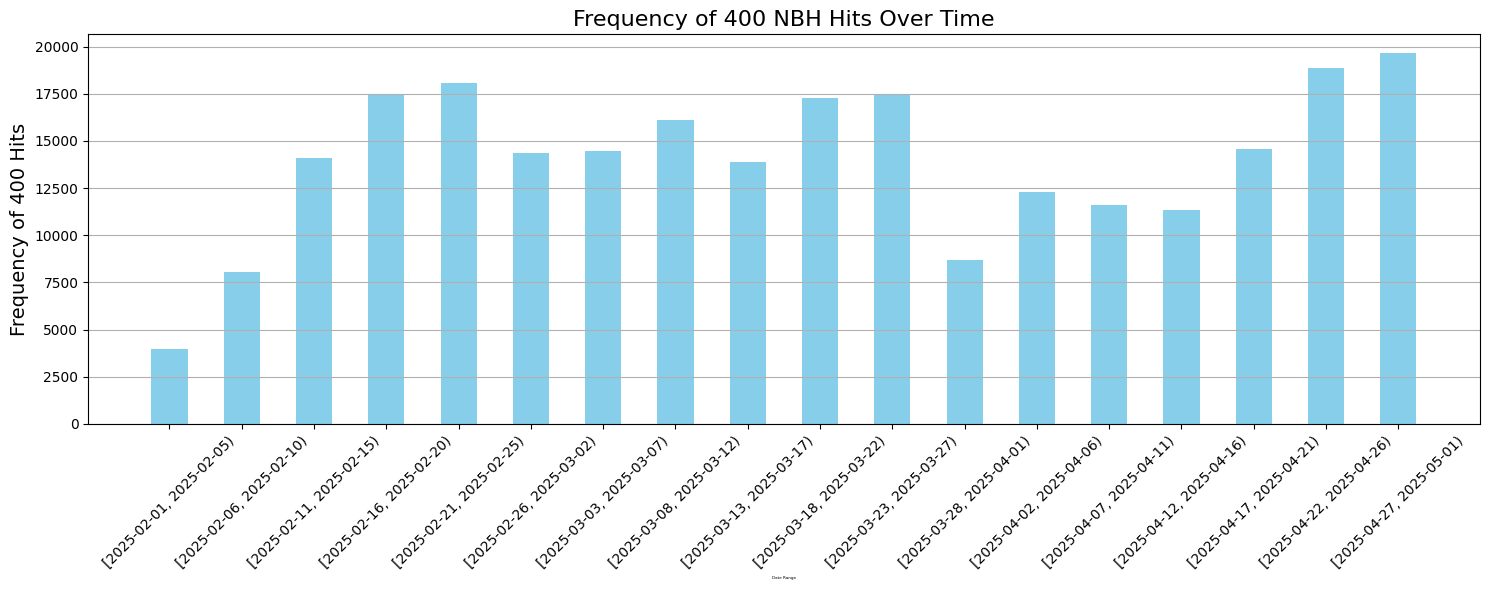

In [174]:
from datetime import datetime, timedelta
def analyze_400_freq(start_date, end_date):
    """
    Analyze the frequency of 400 NBH values for a given search term and date range.
    """
    result = Raw400FreqQuery.Frequency400NBHQuery(
            project_id=project_id,
            start_date=start_date,
            end_date=end_date
        )
    print(result.query)
    result = BigQueryExecutor.BigQueryExecutor().execute_query(result, cache=True)
    return result

def visualize_400_nbh_frequency(df, date_interval_days):
    """
    Visualizes the frequency of 400 NBH hits over specified date ranges.

    Args:
        df: Pandas DataFrame with 'event_date' and 'frequency_400_hits' columns.
        date_interval_days: The number of days for each interval in the plot.
    """
    if df is None or df.empty:
        print("No data to visualize.")
        return

    # Ensure 'event_date' is in datetime format
    df['event_date'] = pd.to_datetime(df['event_date'])

    # Determine the overall date range from the data
    start_date = df['event_date'].min()
    end_date = df['event_date'].max()

    # Generate date ranges
    date_ranges = helpers.generate_date_ranges(start_date, end_date, days_jump=date_interval_days)

    # Calculate the frequency of 400 hits within each date range
    counts = []
    labels = []
    for start, end in date_ranges:
        count = 0
        for _, row in df.iterrows():
            event_date = pd.to_datetime(row['event_date'])
            if pd.to_datetime(start) <= event_date < pd.to_datetime(end):
                count += int(row['frequency_400_hits'])
        counts.append(int(count))
        labels.append(f"[{start}, {end})")

    print(labels , '\n' , counts)
    
    # Plot the frequency of 400 hits
    plt.figure(figsize=(15, 6))
    plt.bar(labels, counts, color='skyblue', width=0.5)
    plt.xlabel('Date Range', fontsize=3)
    plt.ylabel('Frequency of 400 Hits', fontsize=14)
    plt.title('Frequency of 400 NBH Hits Over Time', fontsize=16)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

   


res = analyze_400_freq("2025-02-01", "2025-05-01")
visualize_400_nbh_frequency(res, date_interval_days=5)

Processing search term: shoes
Processing date range: 2025-03-06 to 2025-05-06

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-03-06') AND DATE('2025-05-06')
                AND property_code = 'noon'
                AND locale = 'en-ae'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'shoes'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/sea

Python(42541) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-03-06', 'nbh': '31844'}, {'event_date': '2025-03-06', 'nbh': '31894'}, {'event_date': '2025-03-06', 'nbh': '31909'}, {'event_date': '2025-03-06', 'nbh': '32155'}, {'event_date': '2025-03-06', 'nbh': '32155'}, {'event_date': '2025-03-06', 'nbh': '32156'}, {'event_date': '2025-03-06', 'nbh': '32158'}, {'event_date': '2025-03-06', 'nbh': '32159'}, {'event_date': '2025-03-06', 'nbh': '32174'}, {'event_date': '2025-03-06', 'nbh': '32197'}, {'event_date': '2025-03-06', 'nbh': '32203'}, {'event_date': '2025-03-06', 'nbh': '32210'}, {'event_date': '2025-03-06', 'nbh': '32220'}, {'event_date': '2025-03-06', 'nbh': '32234'}, {'event_date': '2025-03-06', 'nbh': '32246'}, {'event_date': '2025-03-06', 'nbh': '32503'}, {'event_date': '2025-03-06', 'nbh': '32513'}, {'event_date': '2025-03-06', 'nbh': '32619'}, {'event_date': '2025-03-06', 'nbh': '32641'}, {'event_date': '2025-03-06', 'nbh': '32647'}, {'event_date': '2025-03-06', 'nbh': '32818'}, {'event_date': '2025-03-06', 'nbh

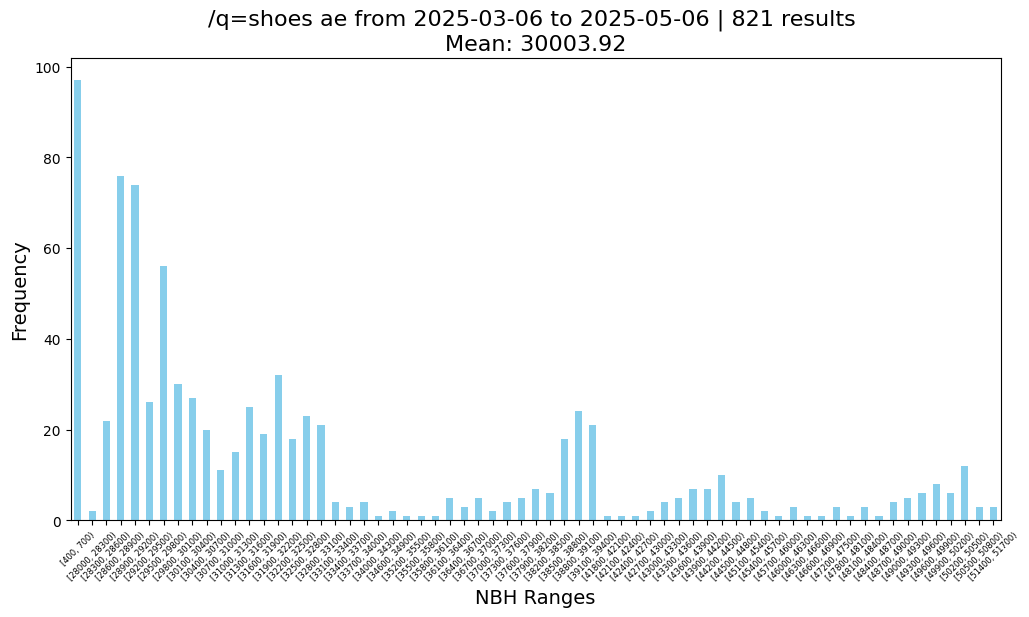

--------*--- Bins 1000 ---*-----------
 [   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   27   28
   29   30   31   32   33   34   35   36   37   38   39   40   41   42
   43   44   45   46   47   48   49   50   51   52   53   54   55   56
   57   58   59   60   61   62   63   64   65   66   67   68   69   70
   71   72   73   74   75   76   77   78   79   80   81   82   83   84
   85   86   87   88   89   90   91   92   93   94   95   96   97   98
   99  100  101  102  103  104  105  106  107  108  109  110  111  112
  113  114  115  116  117  118  119  120  121  122  123  124  125  126
  127  128  129  130  131  132  133  134  135  136  137  138  139  140
  141  142  143  144  145  146  147  148  149  150  151  152  153  154
  155  156  157  158  159  160  161  162  163  164  165  166  167  168
  169  170  171  172  173  174  175  176  177  178  179  180  181  182
  183  184  185  186  187  188  189  

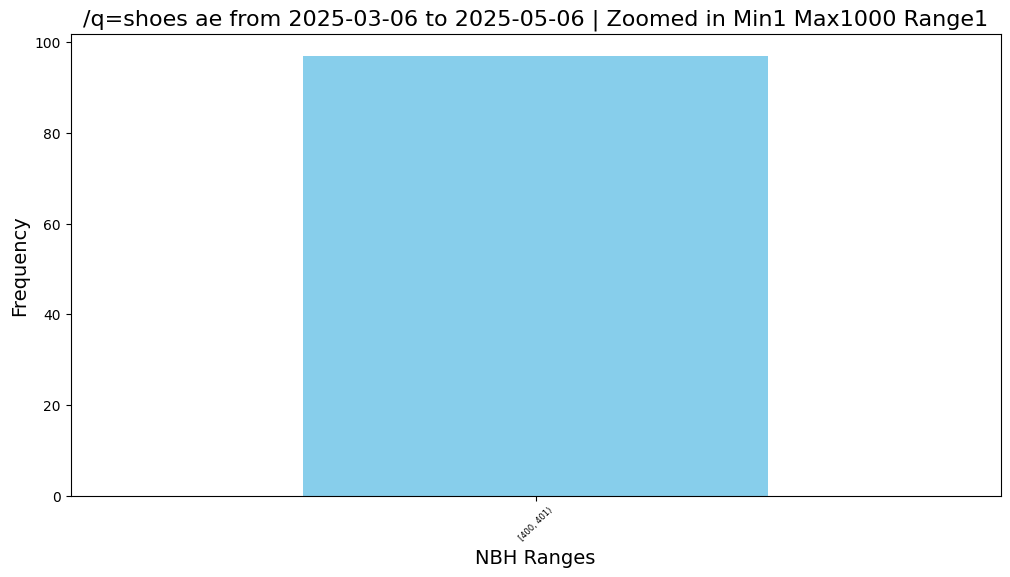

Processing search term: shoes
Processing date range: 2025-03-06 to 2025-05-06

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-03-06') AND DATE('2025-05-06')
                AND property_code = 'noon'
                AND locale = 'en-sa'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'shoes'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/sea

Python(42638) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-03-06', 'nbh': '41122'}, {'event_date': '2025-03-06', 'nbh': '43228'}, {'event_date': '2025-03-06', 'nbh': '43229'}, {'event_date': '2025-03-06', 'nbh': '43231'}, {'event_date': '2025-03-06', 'nbh': '43231'}, {'event_date': '2025-03-06', 'nbh': '43239'}, {'event_date': '2025-03-06', 'nbh': '43247'}, {'event_date': '2025-03-06', 'nbh': '43248'}, {'event_date': '2025-03-06', 'nbh': '43264'}, {'event_date': '2025-03-06', 'nbh': '43492'}, {'event_date': '2025-03-06', 'nbh': '43504'}, {'event_date': '2025-03-06', 'nbh': '43550'}, {'event_date': '2025-03-06', 'nbh': '43733'}, {'event_date': '2025-03-07', 'nbh': '41222'}, {'event_date': '2025-03-07', 'nbh': '43078'}, {'event_date': '2025-03-07', 'nbh': '43142'}, {'event_date': '2025-03-07', 'nbh': '43419'}, {'event_date': '2025-03-07', 'nbh': '43419'}, {'event_date': '2025-03-07', 'nbh': '43445'}, {'event_date': '2025-03-07', 'nbh': '43513'}, {'event_date': '2025-03-07', 'nbh': '43571'}, {'event_date': '2025-03-07', 'nbh

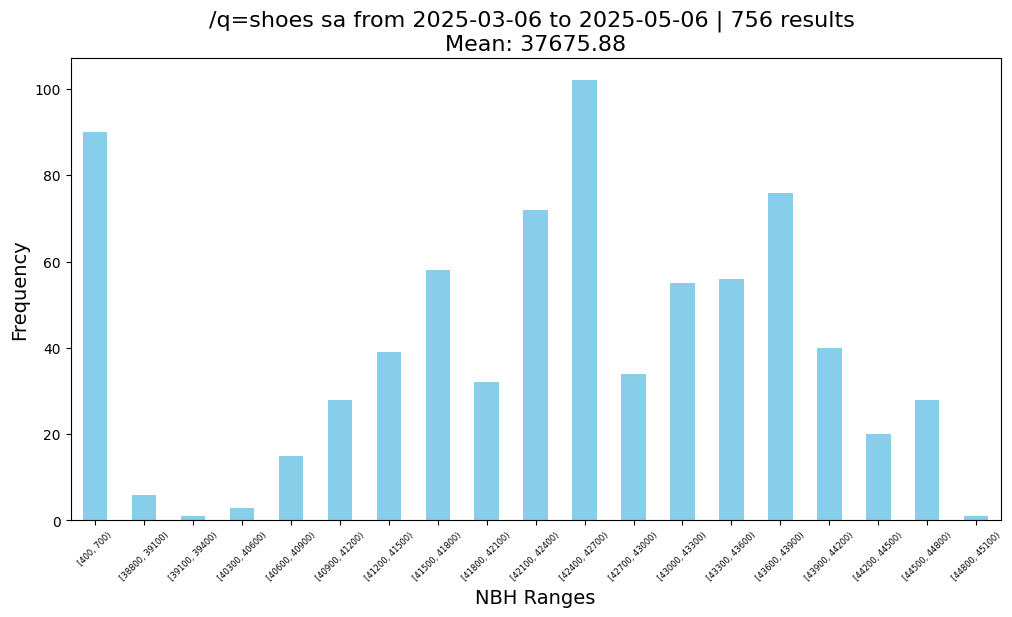

--------*--- Bins 1000 ---*-----------
 [   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   27   28
   29   30   31   32   33   34   35   36   37   38   39   40   41   42
   43   44   45   46   47   48   49   50   51   52   53   54   55   56
   57   58   59   60   61   62   63   64   65   66   67   68   69   70
   71   72   73   74   75   76   77   78   79   80   81   82   83   84
   85   86   87   88   89   90   91   92   93   94   95   96   97   98
   99  100  101  102  103  104  105  106  107  108  109  110  111  112
  113  114  115  116  117  118  119  120  121  122  123  124  125  126
  127  128  129  130  131  132  133  134  135  136  137  138  139  140
  141  142  143  144  145  146  147  148  149  150  151  152  153  154
  155  156  157  158  159  160  161  162  163  164  165  166  167  168
  169  170  171  172  173  174  175  176  177  178  179  180  181  182
  183  184  185  186  187  188  189  

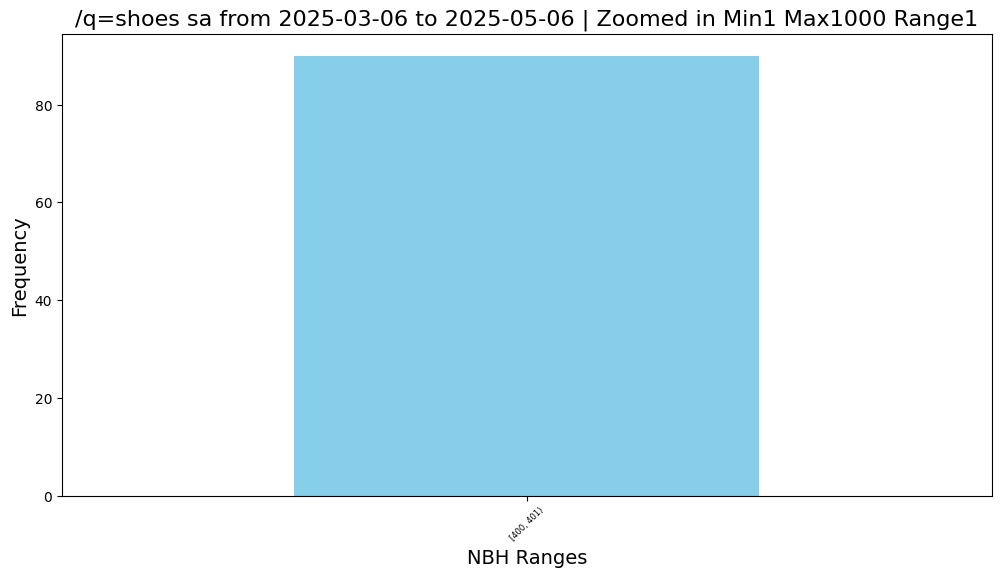

Processing search term: man shoes
Processing date range: 2025-03-06 to 2025-05-06

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-03-06') AND DATE('2025-05-06')
                AND property_code = 'noon'
                AND locale = 'en-ae'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'man shoes'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LI

Python(42746) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-03-06', 'nbh': '27841'}, {'event_date': '2025-03-06', 'nbh': '27849'}, {'event_date': '2025-03-06', 'nbh': '28019'}, {'event_date': '2025-03-07', 'nbh': '27375'}, {'event_date': '2025-03-07', 'nbh': '27448'}, {'event_date': '2025-03-07', 'nbh': '27464'}, {'event_date': '2025-03-07', 'nbh': '27528'}, {'event_date': '2025-03-08', 'nbh': '25645'}, {'event_date': '2025-03-08', 'nbh': '25682'}, {'event_date': '2025-03-08', 'nbh': '25808'}, {'event_date': '2025-03-08', 'nbh': '26206'}, {'event_date': '2025-03-08', 'nbh': '26227'}, {'event_date': '2025-03-08', 'nbh': '26831'}, {'event_date': '2025-03-09', 'nbh': '24474'}, {'event_date': '2025-03-09', 'nbh': '24692'}, {'event_date': '2025-03-09', 'nbh': '25404'}, {'event_date': '2025-03-10', 'nbh': '23022'}, {'event_date': '2025-03-10', 'nbh': '24175'}, {'event_date': '2025-03-10', 'nbh': '24213'}, {'event_date': '2025-03-11', 'nbh': '22369'}, {'event_date': '2025-03-11', 'nbh': '22542'}, {'event_date': '2025-03-11', 'nbh

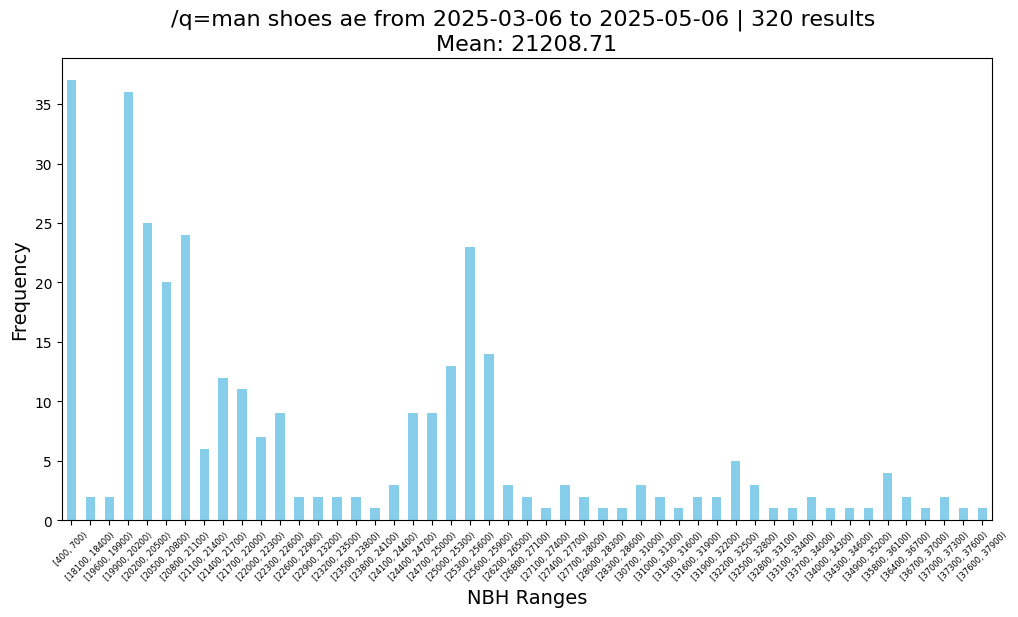

--------*--- Bins 1000 ---*-----------
 [   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   27   28
   29   30   31   32   33   34   35   36   37   38   39   40   41   42
   43   44   45   46   47   48   49   50   51   52   53   54   55   56
   57   58   59   60   61   62   63   64   65   66   67   68   69   70
   71   72   73   74   75   76   77   78   79   80   81   82   83   84
   85   86   87   88   89   90   91   92   93   94   95   96   97   98
   99  100  101  102  103  104  105  106  107  108  109  110  111  112
  113  114  115  116  117  118  119  120  121  122  123  124  125  126
  127  128  129  130  131  132  133  134  135  136  137  138  139  140
  141  142  143  144  145  146  147  148  149  150  151  152  153  154
  155  156  157  158  159  160  161  162  163  164  165  166  167  168
  169  170  171  172  173  174  175  176  177  178  179  180  181  182
  183  184  185  186  187  188  189  

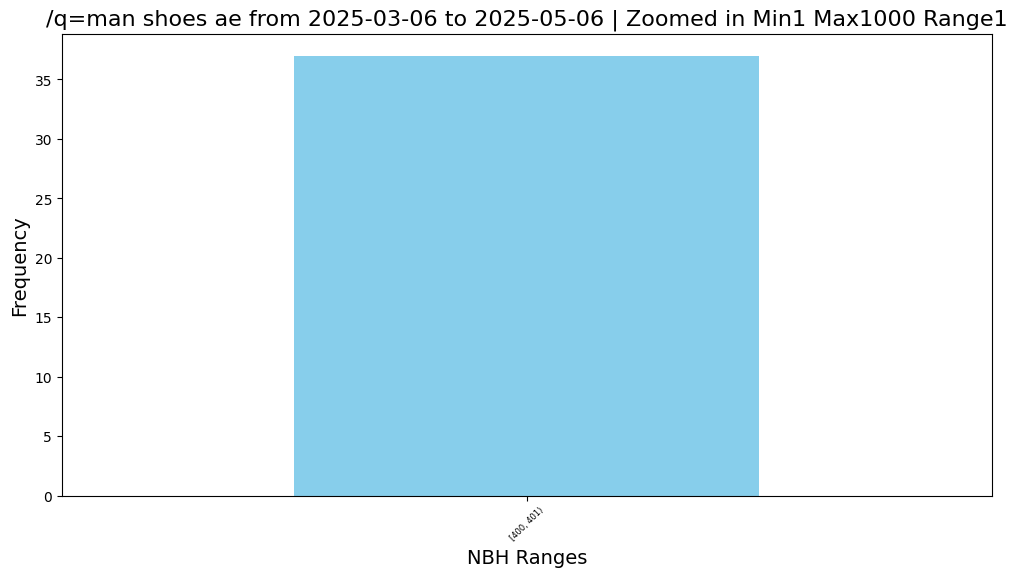

Processing search term: hoodie
Processing date range: 2025-03-06 to 2025-05-06

            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-03-06') AND DATE('2025-05-06')
                AND property_code = 'noon'
                AND locale = 'en-ae'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'hoodie'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/s

Python(42845) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[{'event_date': '2025-03-06', 'nbh': '31810'}, {'event_date': '2025-03-06', 'nbh': '31824'}, {'event_date': '2025-03-06', 'nbh': '31826'}, {'event_date': '2025-03-06', 'nbh': '31830'}, {'event_date': '2025-03-06', 'nbh': '31847'}, {'event_date': '2025-03-06', 'nbh': '31978'}, {'event_date': '2025-03-06', 'nbh': '31978'}, {'event_date': '2025-03-06', 'nbh': '31988'}, {'event_date': '2025-03-07', 'nbh': '31941'}, {'event_date': '2025-03-07', 'nbh': '31946'}, {'event_date': '2025-03-07', 'nbh': '31955'}, {'event_date': '2025-03-07', 'nbh': '31976'}, {'event_date': '2025-03-07', 'nbh': '31976'}, {'event_date': '2025-03-07', 'nbh': '31979'}, {'event_date': '2025-03-07', 'nbh': '31980'}, {'event_date': '2025-03-07', 'nbh': '31982'}, {'event_date': '2025-03-07', 'nbh': '31983'}, {'event_date': '2025-03-07', 'nbh': '31985'}, {'event_date': '2025-03-07', 'nbh': '31985'}, {'event_date': '2025-03-07', 'nbh': '31985'}, {'event_date': '2025-03-08', 'nbh': '31956'}, {'event_date': '2025-03-08', 'nbh

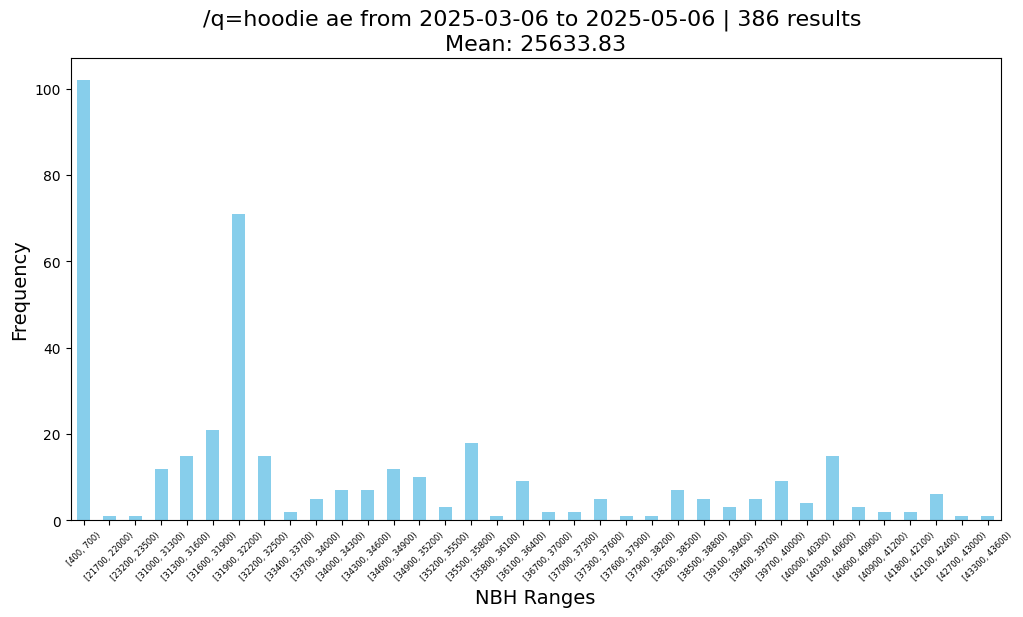

--------*--- Bins 1000 ---*-----------
 [   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   27   28
   29   30   31   32   33   34   35   36   37   38   39   40   41   42
   43   44   45   46   47   48   49   50   51   52   53   54   55   56
   57   58   59   60   61   62   63   64   65   66   67   68   69   70
   71   72   73   74   75   76   77   78   79   80   81   82   83   84
   85   86   87   88   89   90   91   92   93   94   95   96   97   98
   99  100  101  102  103  104  105  106  107  108  109  110  111  112
  113  114  115  116  117  118  119  120  121  122  123  124  125  126
  127  128  129  130  131  132  133  134  135  136  137  138  139  140
  141  142  143  144  145  146  147  148  149  150  151  152  153  154
  155  156  157  158  159  160  161  162  163  164  165  166  167  168
  169  170  171  172  173  174  175  176  177  178  179  180  181  182
  183  184  185  186  187  188  189  

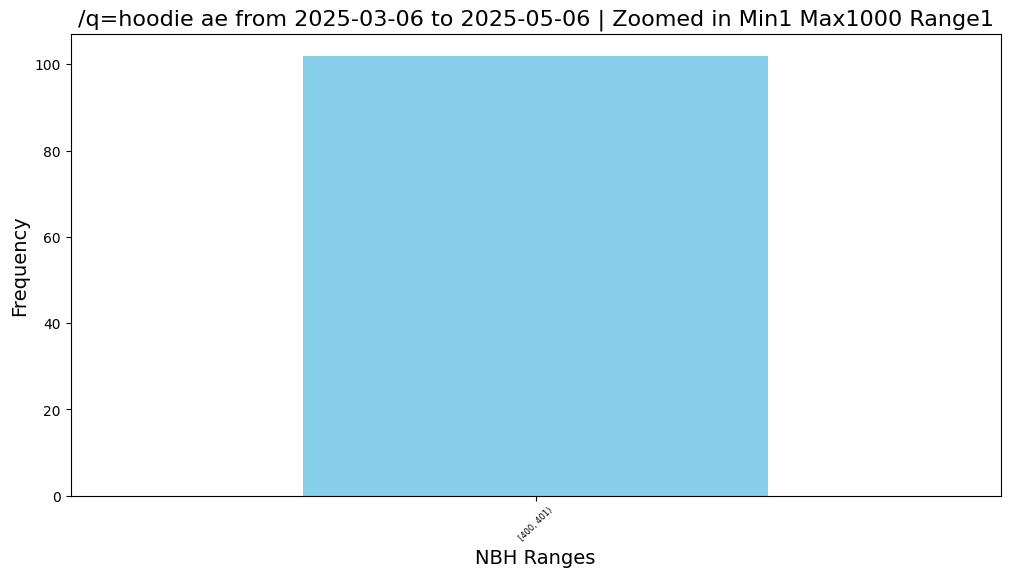

In [222]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def load_results_with_400(file_path):
    """
    Load the results with 400 from a CSV file.
    """
    return pd.read_csv(file_path)

def generate_date_ranges(start_date, end_date, days_jump):
    """
    Generate date ranges using the helper function.
    """
    return helpers.generate_date_ranges(start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d"), days_jump=days_jump)

def execute_nbh_query(project_id, search_term, start_date, end_date , country_code = None , csv_path=None , csv_name=None):
    """
    Execute the NBH query for a given date range.
    """
    query = NBHRawQuery.SimpleNBHDateRangeQuery(project_id=project_id, search_term=search_term, start_date=start_date, end_date=end_date , country_code=country_code)
    print(query.query)
    result =  BigQueryExecutor.BigQueryExecutor().execute_query(query, cache=True)

    if csv_name and csv_path:
        # Save the result to a CSV file
        result.to_csv(f"{csv_path}/{csv_name}.csv", index=False)
        print(f"Result saved to {csv_path}/{csv_name}.csv")
    return result

def calculate_nbh_range_frequency(result, range_diff , zoom_in_dict=None):
    """
    Calculate the frequency of NBH values within specified ranges, ignoring those with zero frequency.
    """
    if result.empty:
        return pd.Series()

    result['event_date'] = pd.to_datetime(result['event_date'])
    nbh_values = result['nbh'].astype(int)

    if nbh_values.empty:
        return pd.Series()

    min_nbh = nbh_values.min()
    max_nbh = nbh_values.max()

    # Handle the case where min and max are the same to avoid zero-length bins
    if min_nbh == max_nbh:
        print(f"Single unique NBH value detected: {min_nbh}")
        return pd.Series({f"[{min_nbh}, {min_nbh + range_diff})": len(nbh_values)})

    bins = np.arange(min_nbh, max_nbh + range_diff, range_diff)

    if zoom_in_dict:
        # Zoom in on the specified range
        local_min_nbh = zoom_in_dict['min_nbh']
        local_max_nbh = zoom_in_dict['max_nbh']
        local_range_diff = zoom_in_dict['range_diff']
        bins = np.arange(local_min_nbh, local_max_nbh + local_range_diff, local_range_diff)

    # Ensure at least two bins are created if range_diff is larger than the data range
    if len(bins) <= 1:
        bins = np.array([min_nbh, max_nbh + range_diff])

    print(f"--------*--- Bins {len(bins)} ---*-----------\n {bins}")
    frequency, _ = np.histogram(nbh_values, bins=bins)
    bin_labels = pd.IntervalIndex.from_breaks(bins, closed='left')
    frequency_series = pd.Series(frequency, index=bin_labels)

    # Filter out bins with zero frequency
    frequency_series = frequency_series[frequency_series > 0]
    return frequency_series

def plot_nbh_range_frequency(nbh_range_frequency, title="NBH Range Frequency", save_path=None , image_name = None):
    """
    Plot the frequency of NBH ranges as a bar graph with thinner bars and x-axis labels.
    Optionally save the plot as a PNG file to a specified path.
    """
    plt.figure(figsize=(12, 6))
    nbh_range_frequency.plot(kind='bar', color='skyblue', width=0.5)  # Reduced bar width
    plt.title(title, fontsize=16)
    plt.xlabel('NBH Ranges', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=45, fontsize=6)  # Reduced font size for x-axis labels
    
    if save_path and image_name:
        image_name = f"{save_path}/{image_name}.png"
        plt.savefig(image_name, format='png', dpi=300)
        print(f"Plot saved to {image_name}")
    
    plt.show()

project_id = "noonbisearch"
end_date = pd.to_datetime("2025-05-06")
start_date = pd.to_datetime("2025-03-06")
days_jump = 600
date_ranges = generate_date_ranges(start_date, end_date, days_jump)[::-1]
bins_range = 300
results_folder_path = "./statistics_results"
zoom_in_dict = {
    "min_nbh" : 1,
    "max_nbh" : 1000,
    "range_diff" : 1
}
nbh = 400

results_with_400_df_arr = [("shoes" , "ae")]
results_with_400_df_arr = [("oppo reno 12" , None)]
surely_flagged_queries = [("shoes" , "ae") , ("shoes" , "sa") , ("man shoes" , "ae") , ("hoodie" , "ae")]
for search_term, country_code in surely_flagged_queries:
    
    print(f"Processing search term: {search_term}")
    search_term_folder_path = f"{results_folder_path}/{search_term}"
    stats = []
    percentiles = []
        
    for date_range in date_ranges:
        range_start, range_end = date_range
        print(f"Processing date range: {range_start} to {range_end}")
        
        # create a folder in a path with the search_term name
        helpers.create_folder_if_not_exists(search_term_folder_path)

        # Execute the NBH query for the current search term and date range
        result = execute_nbh_query(project_id, search_term, range_start, range_end ,country_code=country_code)
        
        if result.empty:
            print(f"No data found for search term: {search_term} in range {range_start} to {range_end}")
            continue

        
        # Calculate the NBH range frequency
        mean_nbh = result['nbh'].astype(float).mean()
        # Calculate and plot the mean NBH value
        nbh_range_frequency = calculate_nbh_range_frequency(result, bins_range)



        plot_nbh_range_frequency(
            nbh_range_frequency,
            save_path=search_term_folder_path,
            image_name=f"{range_start}_{range_end}_nbh_range_frequency",
            title=f"/q={search_term} {country_code} from {range_start} to {range_end} | {len(result)} results \nMean: {mean_nbh:.2f}",
        )


        # plot zoomed in
        nbh_range_frequency = calculate_nbh_range_frequency(result, bins_range , zoom_in_dict=zoom_in_dict)
        plot_nbh_range_frequency(
            nbh_range_frequency,
            save_path=search_term_folder_path,
            image_name=f"{range_start}_{range_end}zoomed_in_nbh_range_frequency",
            title=f"/q={search_term} {country_code} from {range_start} to {range_end} | Zoomed in Min{zoom_in_dict['min_nbh']} Max{zoom_in_dict['max_nbh']} Range{zoom_in_dict['range_diff']}",
        )

        
        

    


    


            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-03-01') AND DATE('2025-05-06')
                AND property_code = 'noon'
                AND locale = 'en-ae'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'shoes'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, '$.nbh') = '400'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=shoes%'
            

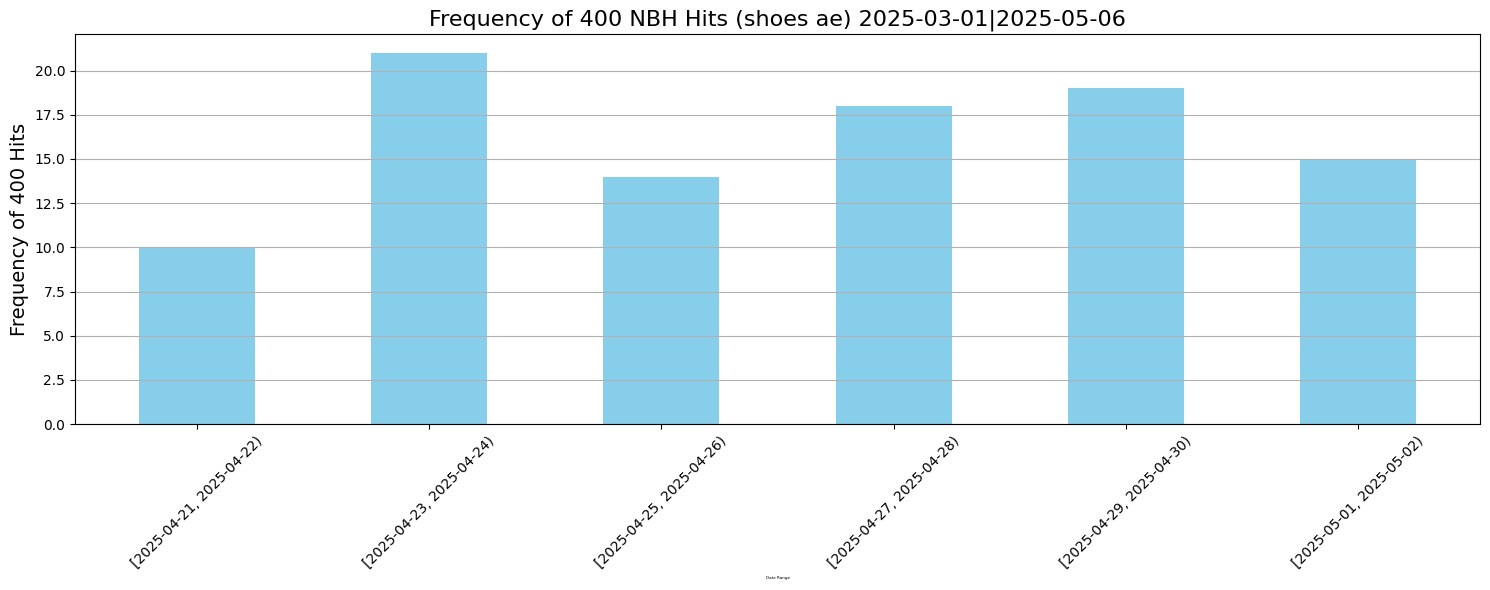


            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-03-01') AND DATE('2025-05-06')
                AND property_code = 'noon'
                AND locale = 'en-sa'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'shoes'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, '$.nbh') = '400'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=shoes%'
            

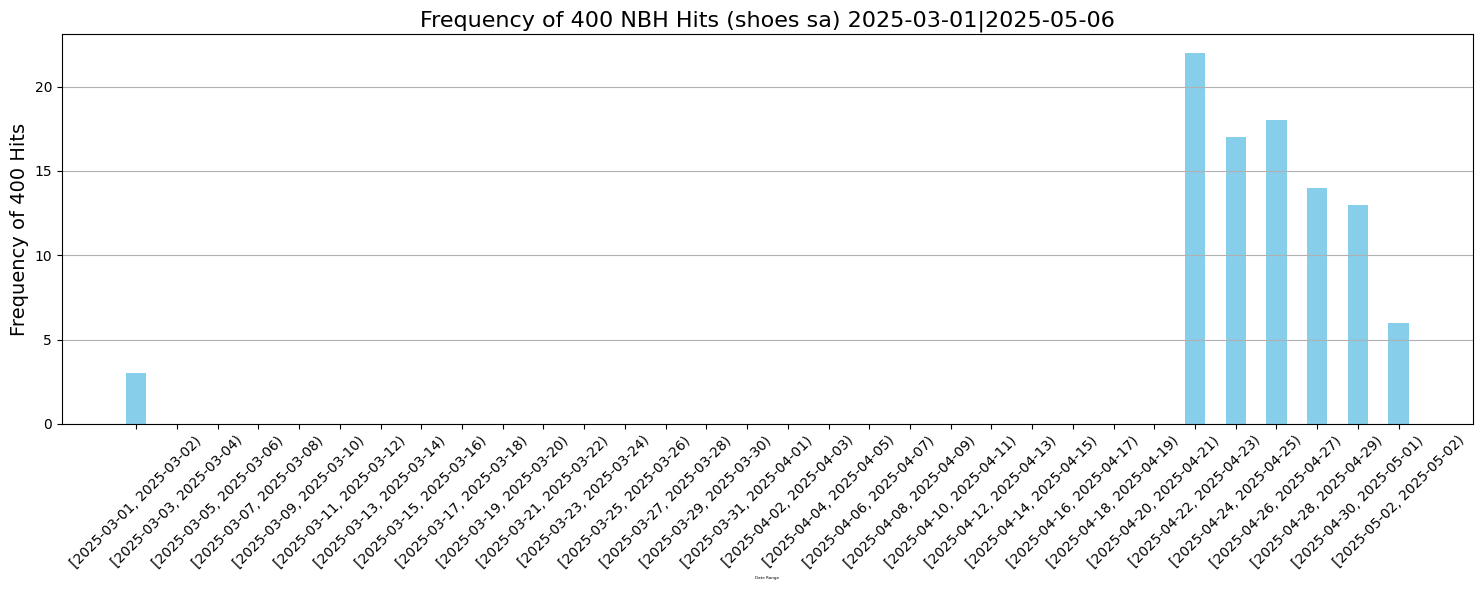


            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-03-01') AND DATE('2025-05-06')
                AND property_code = 'noon'
                AND locale = 'en-ae'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'man shoes'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, '$.nbh') = '400'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=man%20shoes%'
  

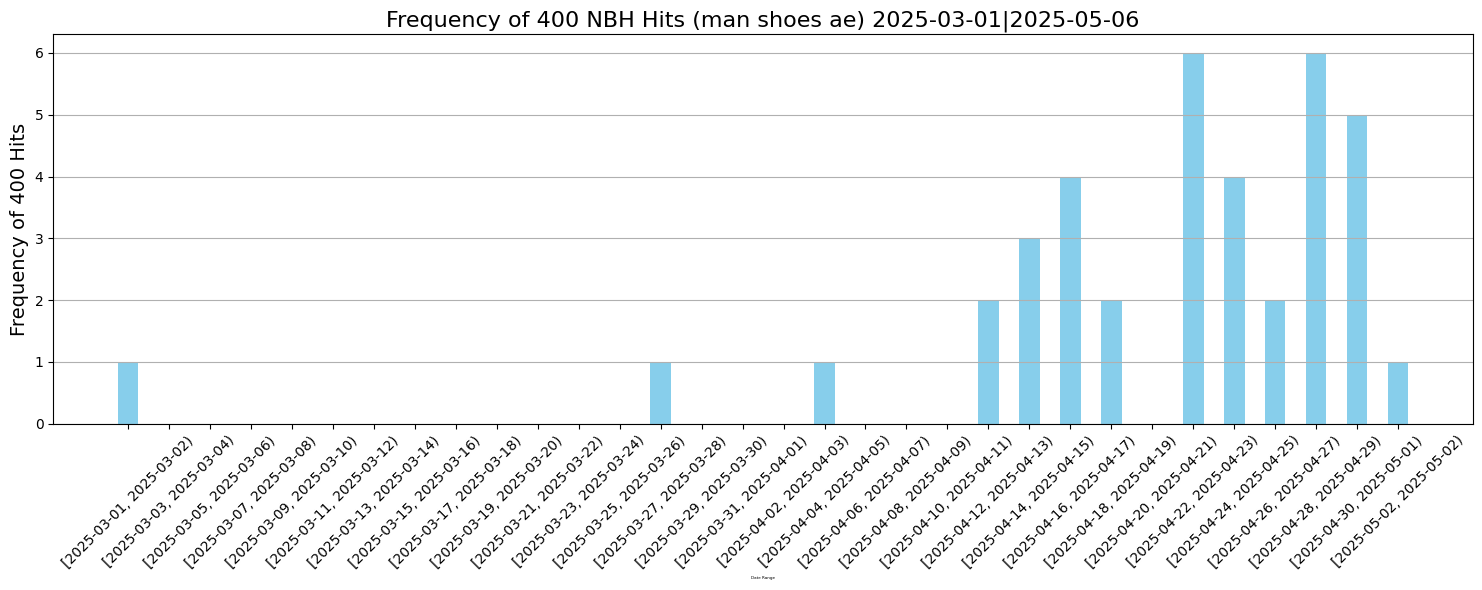


            SELECT
                DATE(event_time) AS event_date,
                CAST(JSON_EXTRACT_SCALAR(event_misc, "$.nbh") AS BIGNUMERIC) AS nbh
            FROM
                `noonprd-mp-analytics.noon_analytics_tool.raw_events_v2`
            WHERE
                event_date BETWEEN DATE('2025-03-01') AND DATE('2025-05-06')
                AND property_code = 'noon'
                AND locale = 'en-ae'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.mc") = "noon"
                AND event_type = 'page_catalog'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.st")) = 'hoodie'
                AND lower(JSON_EXTRACT_SCALAR(event_misc, "$.td.eid")) = 'google'
                AND JSON_VALUE(event_misc, "$.ed.cd.hit") = "false"
                AND JSON_EXTRACT_SCALAR(event_misc, '$.nbh') = '400'
                AND JSON_EXTRACT_SCALAR(event_misc, "$.st") IS NOT NULL
                AND JSON_EXTRACT_SCALAR(event_misc, "$.curl") LIKE '/search?q=hoodie%'
          

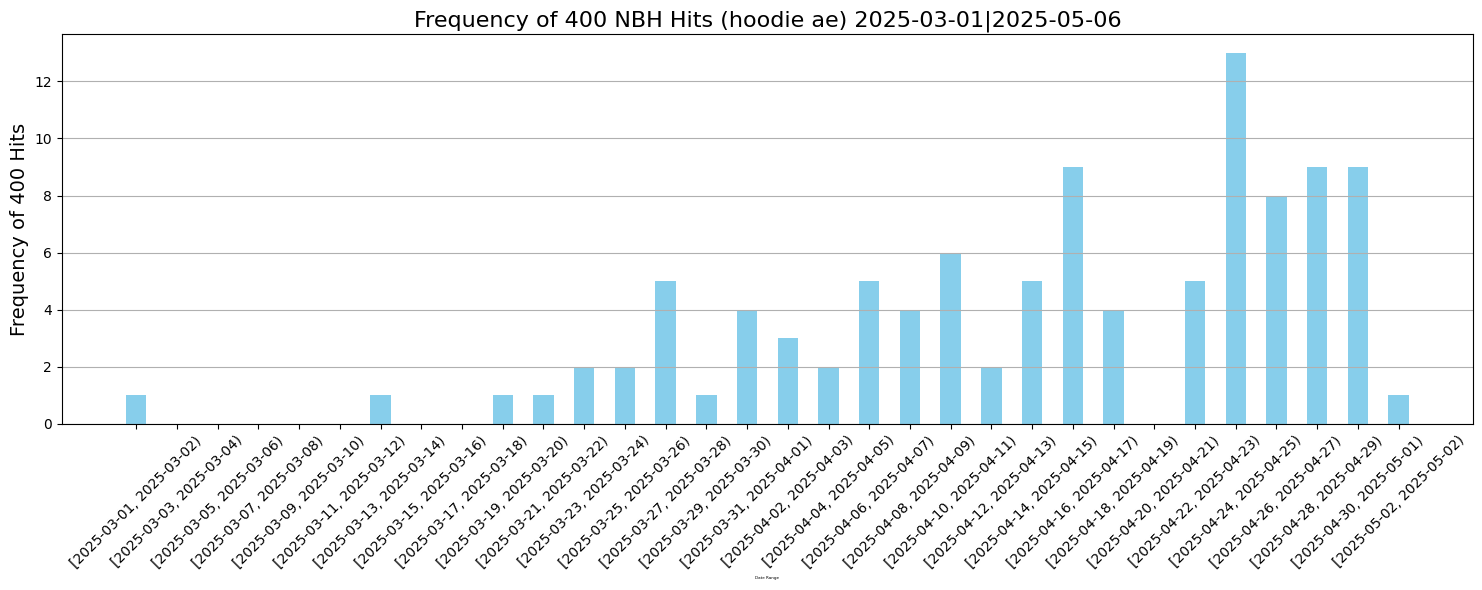

In [221]:
def execute_nbh_query(project_id, search_term, start_date, end_date , country_code = None , csv_path=None , csv_name=None , **kwargs):
    """
    Execute the NBH query for a given date range.
    """
    query = NBHRawQuery.SimpleNBHDateRangeQuery(project_id=project_id, search_term=search_term, start_date=start_date, end_date=end_date , country_code=country_code , **kwargs)
    print(query.query)
    result =  BigQueryExecutor.BigQueryExecutor().execute_query(query, cache=True)

    if csv_name and csv_path:
        # Save the result to a CSV file
        result.to_csv(f"{csv_path}/{csv_name}.csv", index=False)
        print(f"Result saved to {csv_path}/{csv_name}.csv")
    return result 
def visualize_400_nbh_frequency_per_date(df, date_interval_days , search_term= ""  ,tstart_date = None , tend_date = None):
    """
    Visualizes the frequency of 400 NBH hits over specified date ranges.

    Args:
        df: Pandas DataFrame with 'event_date' and 'frequency_400_hits' columns.
        date_interval_days: The number of days for each interval in the plot.
    """
    if df is None or df.empty:
        print("No data to visualize.")
        return

    # Ensure 'event_date' is in datetime format
    df['event_date'] = pd.to_datetime(df['event_date'])

    # Determine the overall date range from the data
    start_date = df['event_date'].min()
    end_date = df['event_date'].max()

    # Generate date ranges
    date_ranges = helpers.generate_date_ranges(start_date, end_date, days_jump=date_interval_days)

    # Calculate the frequency of 400 hits within each date range
    counts = []
    labels = []
    for start, end in date_ranges:
        count = 0
        for _, row in df.iterrows():
            event_date = pd.to_datetime(row['event_date'])
            if pd.to_datetime(start) <= event_date <= pd.to_datetime(end):
                count += 1
        counts.append(int(count))
        labels.append(f"[{start}, {end})")

    print(labels , '\n' , counts)
    
    # Plot the frequency of 400 hits
    plt.figure(figsize=(15, 6))
    plt.bar(labels, counts, color='skyblue', width=0.5)
    plt.xlabel('Date Range', fontsize=3)
    plt.ylabel('Frequency of 400 Hits', fontsize=14)
    plt.title(f'Frequency of 400 NBH Hits ({search_term}) {tstart_date}|{tend_date}', fontsize=16)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()


project_id = "noonbisearch"
start_date = "2025-03-01"
end_date = "2025-05-06"
days_jump = 600
bins_range = 300
results_folder_path = "./statistics_results"
nbh = 400

results_with_400_df_arr = [("shoes" , "ae")]
results_with_400_df_arr = [("oppo reno 12" , None)]
surely_flagged_queries = [("shoes" , "ae") , ("shoes" , "sa") , ("man shoes" , "ae") , ("hoodie" , "ae")]
for search_term, country_code in surely_flagged_queries:

    result = execute_nbh_query(project_id, search_term, start_date=start_date, end_date=end_date ,country_code=country_code , nbh=nbh)
    print(result)
    visualize_400_nbh_frequency_per_date(result, date_interval_days=2  ,search_term=f"{search_term} {country_code}" , tstart_date=start_date , tend_date=end_date)
        
        
